In [1]:
%matplotlib inline

# Astrometric fitting

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.1


In this tutorial we'll walk through the simplest astrometric example with `exoplanet` and then explain how to build up a more complicated example with parallax measurements. For our dataset, we'll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Data 
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract). 

In [3]:
from astropy.io import ascii
from astropy.time import Time

# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(dirname + "astro.txt", format="csv", fill_values=[(".", '0')])

# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping 
# the primary and secondary star
ind = (astro_dates.value > 1975.) & (astro_dates.value < 1999.73) \
    & (~astro_data_full["rho"].mask) & (~astro_data_full["PA"].mask)

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = 'jd'
astro_jds = astro_dates[ind].value

Many of these measurements in this heterogeneous dataset do not have reported error measurements. For these, we assume a modest uncertainty of $1^\circ$ in position angle and $0.01^{\prime\prime}$ in separation for the sake of specifying something, but we'll include a jitter term for both of these measurements as well. The scatter in points around the final solution will be a decent guide of what the measurement uncertainties actually were.

In [4]:
import numpy as np

astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# Convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi/180.
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg) # radians

## Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit. 

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


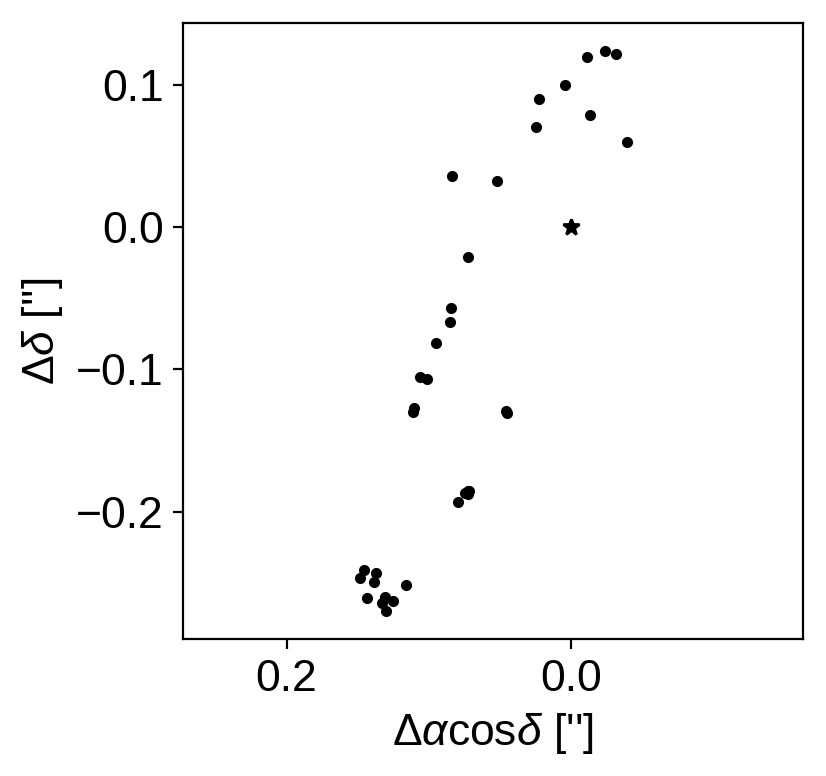

In [5]:
import matplotlib.pyplot as plt

# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0,0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the "raw" measurements are the values of $\rho$ (separation) and $\theta$ (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot $\rho$ vs. time and P.A. vs. time.

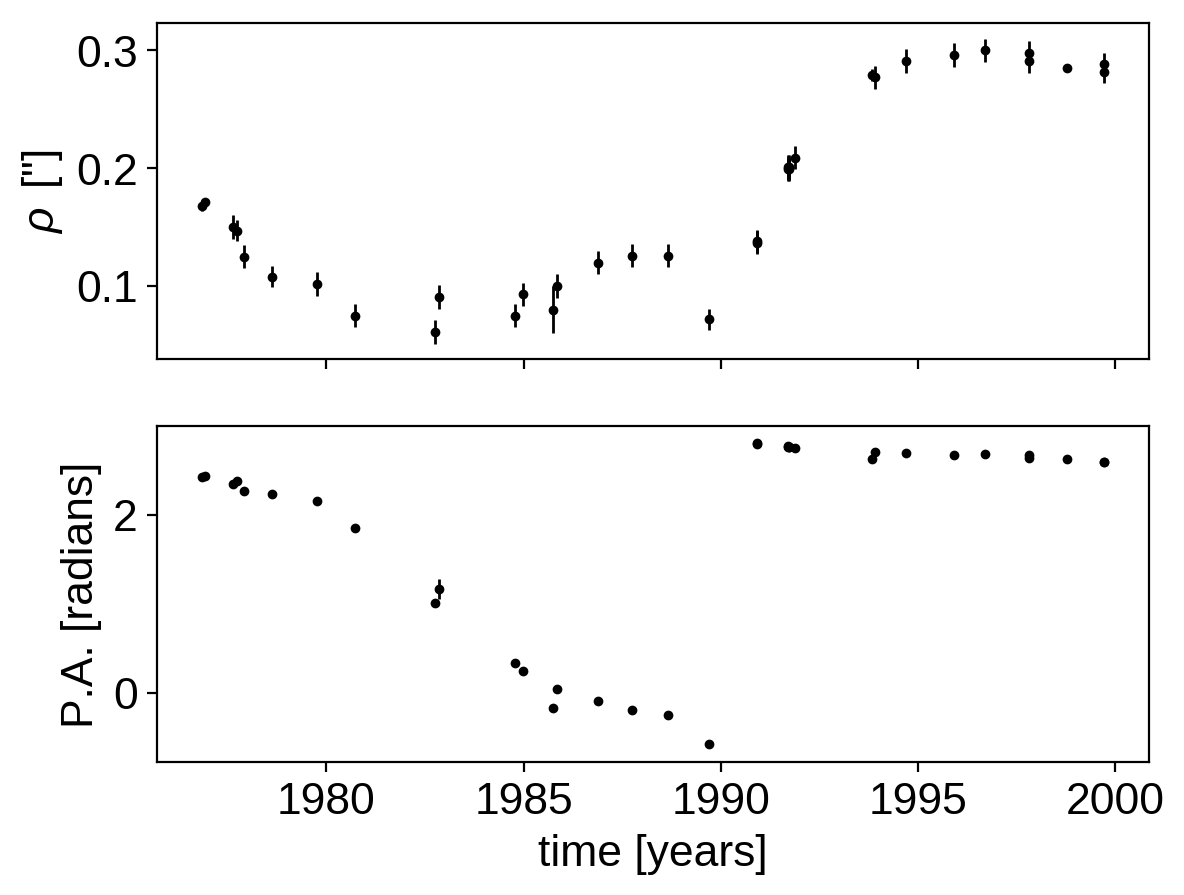

In [6]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r'P.A. [radians]')
ax[1].set_xlabel("time [years]");

## Fitting the astrometric orbit with *exoplanet*

To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample to find the best parameters.

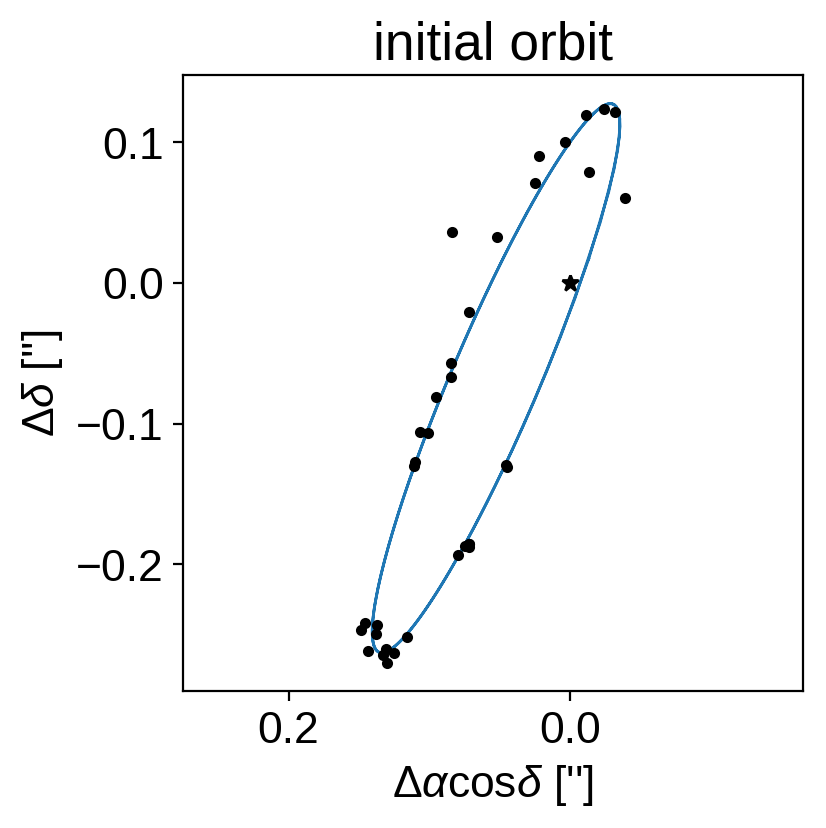

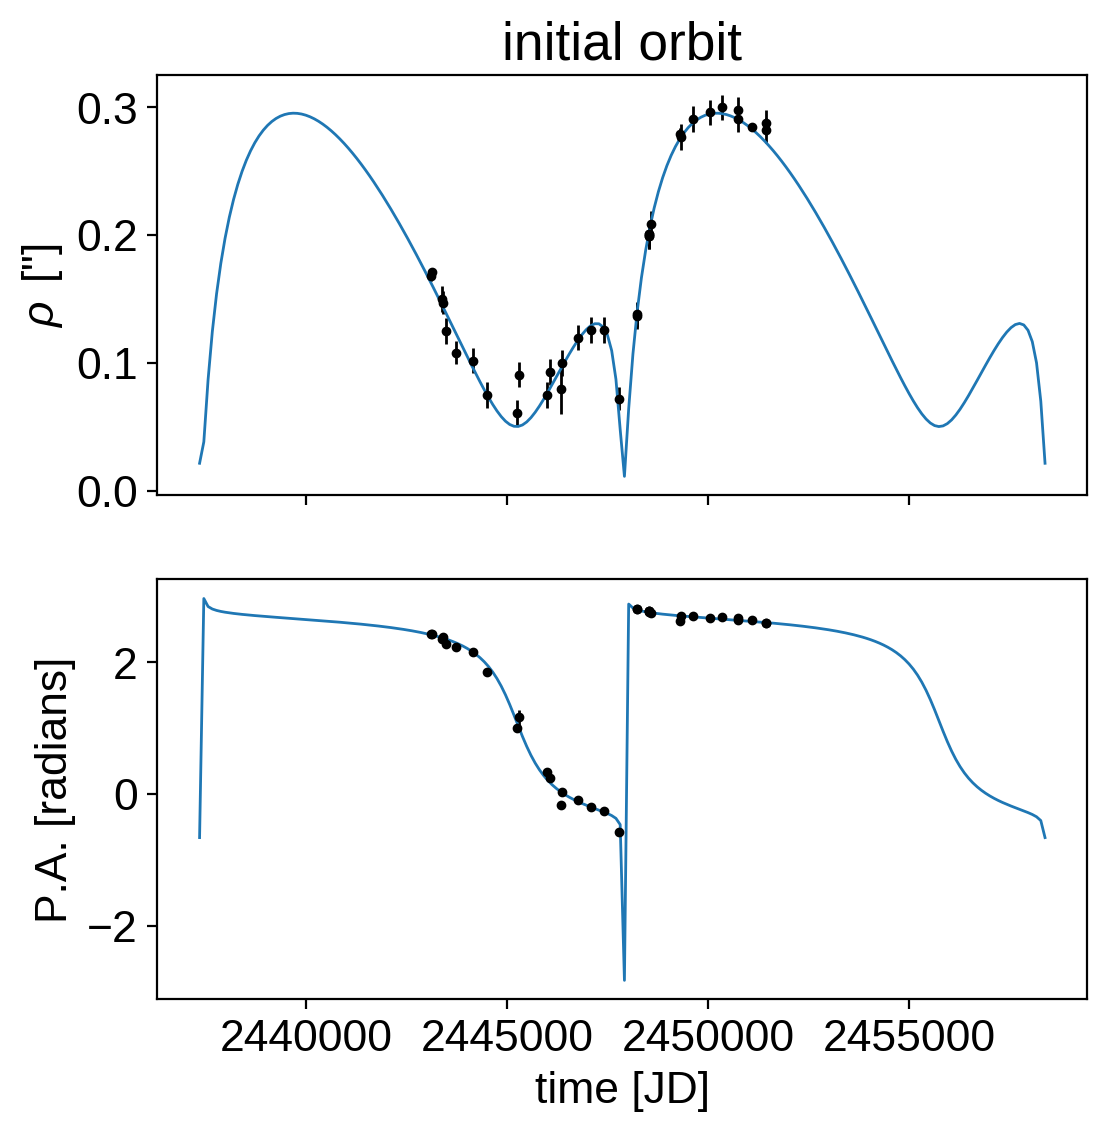

In [7]:
import pymc3 as pm 
import theano
import theano.tensor as tt

import exoplanet as xo
from exoplanet.distributions import Angle

from astropy import constants

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.324  # arcsec
parallax = 1  # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax
e = 0.798
i = 96.0 * deg  # [rad]
omega = 251.6 * deg - np.pi  # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg 
P = 28.8 * 365.25 # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value  # [Julian Date]

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    a=a, t_periastron=T0, period=P, incl=i, ecc=e,
    omega=omega, Omega=Omega)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
t = np.linspace(T0 - P, T0 + P, num=200) # days
rho, theta = theano.function([], orbit.get_relative_angles(t, parallax))()

# Plot the orbit 
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho * np.cos(theta) # X is north
ys = rho * np.sin(theta) # Y is east
ax.plot(ys, xs, color="C0", lw=1)

# plot the data
xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".k")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit");

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit");

ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t, theta, color="C0", lw=1)
ax[1].set_ylabel(r'P.A. [radians]')
ax[1].set_xlabel("time [JD]");

Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.

In [8]:
yr = 365.25

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 500, astro_jds.max() + 500, num=1000)

def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec 
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=100)("m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0])
            plx = pm.Deterministic("plx", 1e-3 * m_plx)
            
        a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 25 years, 
        # so we'll set a broad prior on logP
        logP = pm.Normal("logP", mu=np.log(25*yr), sd=10.0, testval=np.log(28.8*yr))
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = (Omega + omega)/2 and m = (Omega - omega)/2 instead of omega and Omega
        # directly
        omega0 = 251.6 * deg - np.pi
        Omega0 = 159.6 * deg
        p = Angle("p", testval=0.5*(Omega0 + omega0))
        m = Angle("m", testval=0.5*(Omega0 - omega0))
        omega = pm.Deterministic("omega", p - m)
        Omega = pm.Deterministic("Omega", p + m)

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periasteron
        # passage directly
        phase = Angle("phase", testval=0.0)
        tperi = pm.Deterministic("tperi", T0 + P * phase / (2*np.pi))

        # Geometric uiform prior on cos(incl)
        cos_incl = pm.Uniform("cos_incl", lower=-1, upper=1, testval=np.cos(96.0 * deg))
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.798)

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a=a * au_to_R_sun, t_periastron=tperi, period=P, 
            incl=incl, ecc=ecc, omega=omega, Omega=Omega)
        if parallax is not None:
            pm.Deterministic("M_tot", orbit.m_total)

        # Compute the model in rho and theta
        rho_model, theta_model = orbit.get_relative_angles(astro_jds, plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal("log_rho_s", mu=np.log(np.median(rho_err)), sd=5.0)
        log_theta_s = pm.Normal("log_theta_s", mu=np.log(np.median(theta_err)), sd=5.0)
        rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
        theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))

        # define the likelihood function, e.g., a Gaussian on both rho and theta
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho_data)

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to 
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting 
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)

        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[log_rho_s, log_theta_s])
        map_soln = xo.optimize(map_soln, vars=[phase])
        map_soln = xo.optimize(map_soln, vars=[p, m, ecc])
        map_soln = xo.optimize(map_soln, vars=[logP, a_ang, phase])
        map_soln = xo.optimize(map_soln)
    
    return model, map_soln

model, map_soln = get_model()

optimizing logp for variables: [log_theta_s, log_rho_s]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.048555e+02]

1it [00:00, 292.22it/s, logp=1.048555e+02]

2it [00:00, 371.70it/s, logp=1.048555e+02]

3it [00:00, 357.73it/s, logp=1.448865e+02]

4it [00:00, 359.51it/s, logp=1.056457e+02]

5it [00:00, 380.51it/s, logp=1.457994e+02]

6it [00:00, 372.10it/s, logp=1.469999e+02]

7it [00:00, 377.61it/s, logp=1.471434e+02]

8it [00:00, 381.75it/s, logp=1.471440e+02]

9it [00:00, 389.41it/s, logp=1.471440e+02]

10it [00:00, 391.50it/s, logp=1.471440e+02]

11it [00:03,  3.61it/s, logp=1.471440e+02] 


message: Optimization terminated successfully.
logp: 104.85554109314324 -> 147.14399186006233


optimizing logp for variables: [phase]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.471440e+02]

1it [00:00, 296.06it/s, logp=1.471440e+02]

2it [00:00, 420.12it/s, logp=1.471440e+02]

3it [00:00, 468.72it/s, logp=-1.185831e+04]

4it [00:00, 525.70it/s, logp=1.471671e+02] 

5it [00:00, 541.62it/s, logp=1.472136e+02]

6it [00:00, 582.95it/s, logp=1.473986e+02]

7it [00:00, 615.99it/s, logp=1.481189e+02]

8it [00:00, 640.52it/s, logp=1.507231e+02]

9it [00:00, 645.59it/s, logp=1.565965e+02]

10it [00:00, 646.20it/s, logp=1.634911e+02]

11it [00:00, 652.35it/s, logp=1.666396e+02]

12it [00:00, 659.14it/s, logp=1.675455e+02]

13it [00:00, 662.61it/s, logp=1.676215e+02]

14it [00:00, 668.00it/s, logp=1.676248e+02]

15it [00:00, 670.82it/s, logp=1.676282e+02]

16it [00:00, 675.98it/s, logp=1.676337e+02]

17it [00:00, 676.94it/s, logp=1.676403e+02]

18it [00:00, 680.47it/s, logp=1.676419e+02]

19it [00:00, 683.89it/s, logp=1.676422e+02]

20it [00:00, 686.84it/s, logp=1.676422e+02]

21it [00:00, 682.41it/s, logp=1.676422e+02]

22it [00:00, 682.85it/s, logp=1.676422e+02]

23it [00:00, 30.31it/s, logp=1.676422e+02] 


message: Optimization terminated successfully.
logp: 147.14399186006233 -> 167.64220598198332


optimizing logp for variables: [ecc, m, p]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.676422e+02]

1it [00:00, 213.91it/s, logp=1.676422e+02]

2it [00:00, 280.28it/s, logp=1.676422e+02]

3it [00:00, 326.30it/s, logp=-4.521021e+03]

4it [00:00, 387.43it/s, logp=1.682354e+02] 

5it [00:00, 418.37it/s, logp=1.667490e+02]

6it [00:00, 441.29it/s, logp=1.683674e+02]

7it [00:00, 464.58it/s, logp=1.686220e+02]

8it [00:00, 482.09it/s, logp=1.694033e+02]

9it [00:00, 504.42it/s, logp=1.714304e+02]

10it [00:00, 509.80it/s, logp=1.784310e+02]

11it [00:00, 524.90it/s, logp=1.921973e+02]

12it [00:00, 531.27it/s, logp=1.936845e+02]

13it [00:00, 531.82it/s, logp=1.964254e+02]

14it [00:00, 537.71it/s, logp=2.010939e+02]

15it [00:00, 540.12it/s, logp=2.074741e+02]

16it [00:00, 543.26it/s, logp=2.094264e+02]

17it [00:00, 542.10it/s, logp=2.098562e+02]

18it [00:00, 533.13it/s, logp=2.098999e+02]

19it [00:00, 529.93it/s, logp=2.099152e+02]

20it [00:00, 528.02it/s, logp=2.099416e+02]

21it [00:00, 530.74it/s, logp=2.099853e+02]

22it [00:00, 524.30it/s, logp=2.100398e+02]

23it [00:00, 522.33it/s, logp=2.100552e+02]

24it [00:00, 520.84it/s, logp=2.100609e+02]

25it [00:00, 520.80it/s, logp=2.100614e+02]

26it [00:00, 521.84it/s, logp=2.100617e+02]

27it [00:00, 522.51it/s, logp=2.100622e+02]

28it [00:00, 516.00it/s, logp=2.100629e+02]

29it [00:00, 513.11it/s, logp=2.100633e+02]

30it [00:00, 508.23it/s, logp=2.100634e+02]

31it [00:00, 506.28it/s, logp=2.100634e+02]

32it [00:00, 503.50it/s, logp=2.100634e+02]

33it [00:00, 502.34it/s, logp=2.100634e+02]

34it [00:00, 499.92it/s, logp=2.100634e+02]

35it [00:00, 46.32it/s, logp=2.100634e+02] 


message: Optimization terminated successfully.
logp: 167.64220598198335 -> 210.06340668298841


optimizing logp for variables: [phase, a_ang, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.100634e+02]

1it [00:00, 258.05it/s, logp=2.100634e+02]

2it [00:00, 355.68it/s, logp=2.100634e+02]

3it [00:00, 385.10it/s, logp=-4.378171e+03]

4it [00:00, 405.33it/s, logp=2.102114e+02] 

5it [00:00, 398.61it/s, logp=2.103607e+02]

6it [00:00, 398.93it/s, logp=2.104883e+02]

7it [00:00, 391.44it/s, logp=2.105011e+02]

8it [00:00, 388.00it/s, logp=2.105011e+02]

9it [00:00, 389.62it/s, logp=2.105014e+02]

10it [00:00, 384.11it/s, logp=2.105014e+02]

11it [00:00, 372.22it/s, logp=2.105014e+02]

12it [00:00, 13.41it/s, logp=2.105014e+02] 


message: Optimization terminated successfully.
logp: 210.06340668298841 -> 210.50136989148822


optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.105014e+02]

1it [00:00, 271.62it/s, logp=2.105014e+02]

2it [00:00, 385.20it/s, logp=2.105014e+02]

3it [00:00, 427.25it/s, logp=-4.041226e+03]

4it [00:00, 464.38it/s, logp=2.124628e+02] 

5it [00:00, 478.75it/s, logp=1.648448e+02]

6it [00:00, 499.22it/s, logp=2.125361e+02]

7it [00:00, 509.71it/s, logp=2.126469e+02]

8it [00:00, 518.02it/s, logp=2.128268e+02]

9it [00:00, 519.64it/s, logp=2.130889e+02]

10it [00:00, 518.85it/s, logp=2.132127e+02]

11it [00:00, 509.93it/s, logp=2.131910e+02]

12it [00:00, 505.58it/s, logp=2.132712e+02]

13it [00:00, 508.19it/s, logp=2.133790e+02]

14it [00:00, 506.64it/s, logp=2.135772e+02]

15it [00:00, 504.59it/s, logp=2.139432e+02]

16it [00:00, 500.13it/s, logp=2.145105e+02]

17it [00:00, 497.30it/s, logp=2.146599e+02]

18it [00:00, 493.48it/s, logp=2.148474e+02]

19it [00:00, 481.03it/s, logp=2.149170e+02]

20it [00:00, 476.20it/s, logp=2.149377e+02]

21it [00:00, 474.23it/s, logp=2.149628e+02]

22it [00:00, 472.68it/s, logp=2.149864e+02]

23it [00:00, 469.96it/s, logp=2.150041e+02]

24it [00:00, 468.07it/s, logp=2.150108e+02]

25it [00:00, 466.65it/s, logp=2.150182e+02]

26it [00:00, 464.41it/s, logp=2.150205e+02]

27it [00:00, 461.48it/s, logp=2.150210e+02]

28it [00:00, 458.59it/s, logp=2.150212e+02]

29it [00:00, 456.86it/s, logp=2.150212e+02]

30it [00:00, 454.08it/s, logp=2.150212e+02]

31it [00:00, 449.65it/s, logp=2.150212e+02]

32it [00:00, 446.95it/s, logp=2.150212e+02]

33it [00:00, 445.60it/s, logp=2.150212e+02]

34it [00:00, 441.57it/s, logp=2.150212e+02]

35it [00:00, 435.63it/s, logp=2.150212e+02]

36it [00:00, 50.24it/s, logp=2.150212e+02] 


message: Optimization terminated successfully.
logp: 210.50136989148822 -> 215.02117742210874


Now that we have a maximum a posteriori estimate of the parameters, let's take a look at the results to make sure that they seem reasonable.

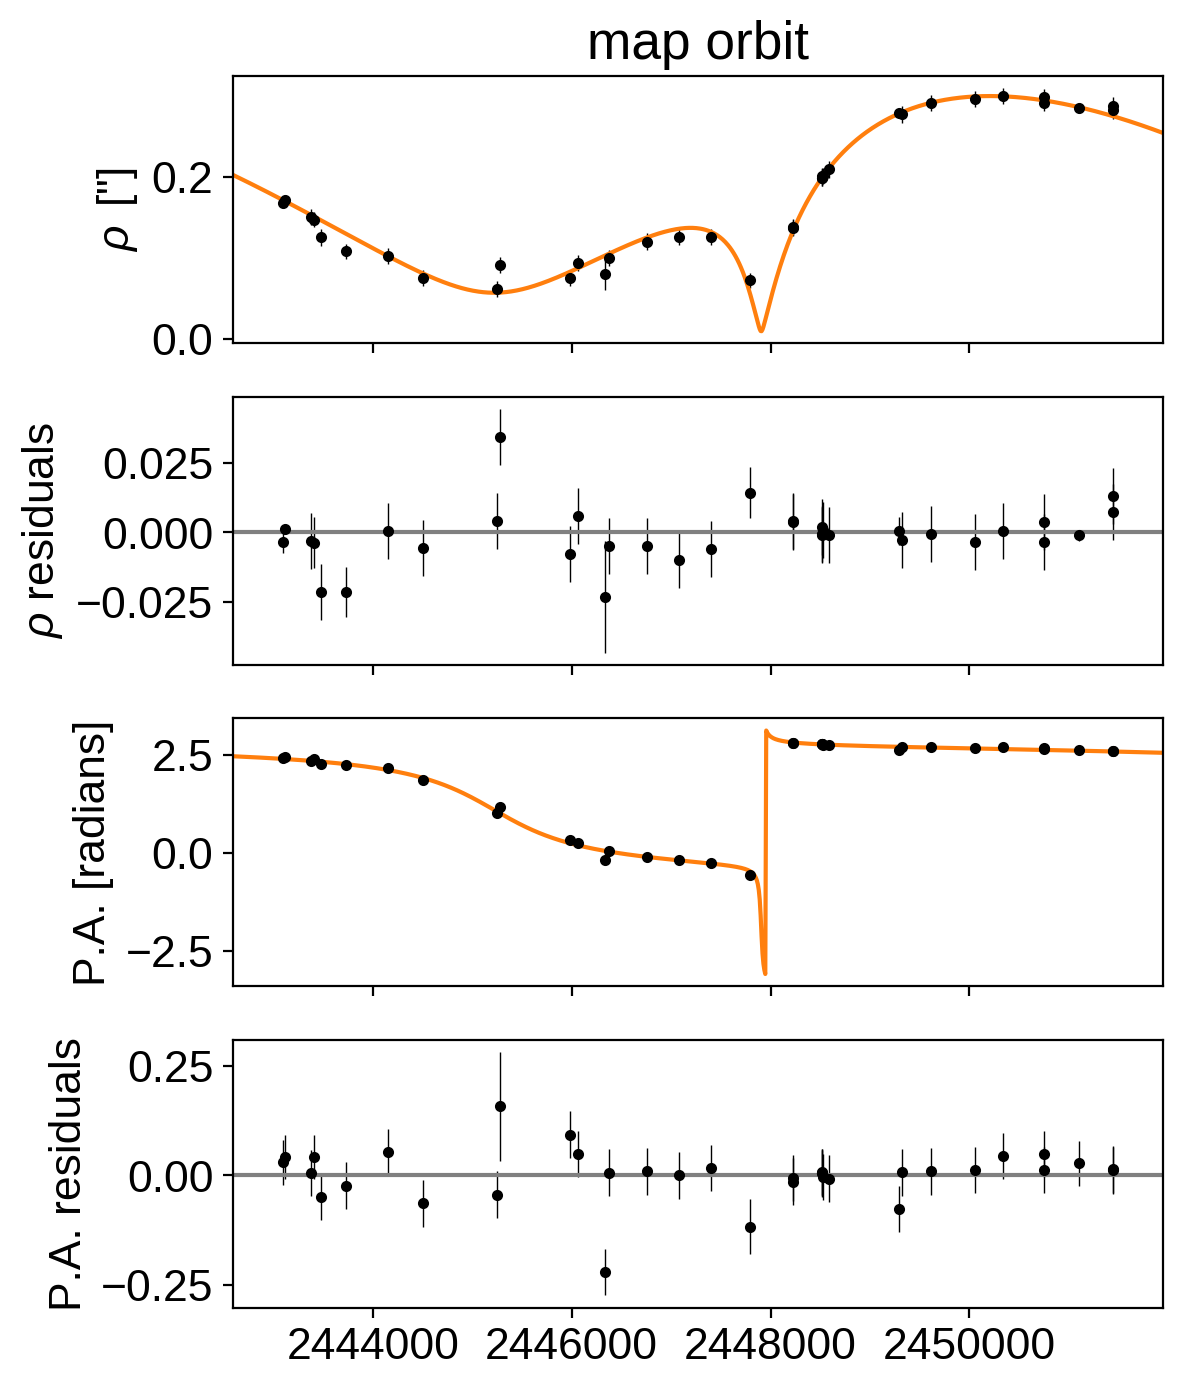

In [9]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6,8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_save"], "C1")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(astro_jds, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw)


ax[2].plot(t_fine, map_soln["theta_save"], "C1")
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(astro_jds, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw) 

ax[3].set_xlim(t_fine[0], t_fine[-1])
ax[0].set_title("map orbit");

Now let's sample the posterior.

In [10]:
np.random.seed(1234)
with model:
    trace = pm.sample(tune=5000, draws=4000, start=map_soln,
                      step=xo.get_dense_nuts_step(target_accept=0.9, adaptation_window=201))

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]


Sampling 4 chains:   0%|          | 0/36000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 13/36000 [00:00<05:46, 103.99draws/s]

Sampling 4 chains:   0%|          | 20/36000 [00:00<06:39, 89.97draws/s] 

Sampling 4 chains:   0%|          | 25/36000 [00:00<10:54, 55.01draws/s]

Sampling 4 chains:   0%|          | 31/36000 [00:00<11:49, 50.67draws/s]

Sampling 4 chains:   0%|          | 36/36000 [00:00<13:08, 45.61draws/s]

Sampling 4 chains:   0%|          | 42/36000 [00:00<12:31, 47.87draws/s]

Sampling 4 chains:   0%|          | 47/36000 [00:00<12:27, 48.12draws/s]

Sampling 4 chains:   0%|          | 52/36000 [00:00<12:36, 47.52draws/s]

Sampling 4 chains:   0%|          | 57/36000 [00:01<15:23, 38.92draws/s]

Sampling 4 chains:   0%|          | 63/36000 [00:01<14:14, 42.05draws/s]

Sampling 4 chains:   0%|          | 68/36000 [00:01<13:58, 42.83draws/s]

Sampling 4 chains:   0%|          | 74/36000 [00:01<13:36, 44.00draws/s]

Sampling 4 chains:   0%|          | 81/36000 [00:01<13:17, 45.05draws/s]

Sampling 4 chains:   0%|          | 86/36000 [00:01<12:56, 46.26draws/s]

Sampling 4 chains:   0%|          | 91/36000 [00:01<13:47, 43.42draws/s]

Sampling 4 chains:   0%|          | 97/36000 [00:02<13:07, 45.59draws/s]

Sampling 4 chains:   0%|          | 103/36000 [00:02<12:37, 47.37draws/s]

Sampling 4 chains:   0%|          | 108/36000 [00:02<12:30, 47.84draws/s]

Sampling 4 chains:   0%|          | 114/36000 [00:02<12:35, 47.50draws/s]

Sampling 4 chains:   0%|          | 119/36000 [00:02<12:42, 47.04draws/s]

Sampling 4 chains:   0%|          | 125/36000 [00:02<12:37, 47.37draws/s]

Sampling 4 chains:   0%|          | 130/36000 [00:02<13:07, 45.53draws/s]

Sampling 4 chains:   0%|          | 135/36000 [00:02<13:40, 43.72draws/s]

Sampling 4 chains:   0%|          | 141/36000 [00:02<12:42, 47.05draws/s]

Sampling 4 chains:   0%|          | 146/36000 [00:03<12:57, 46.11draws/s]

Sampling 4 chains:   0%|          | 151/36000 [00:03<13:13, 45.15draws/s]

Sampling 4 chains:   0%|          | 156/36000 [00:03<13:57, 42.80draws/s]

Sampling 4 chains:   0%|          | 162/36000 [00:03<12:50, 46.50draws/s]

Sampling 4 chains:   0%|          | 168/36000 [00:03<12:34, 47.48draws/s]

Sampling 4 chains:   0%|          | 173/36000 [00:03<12:35, 47.39draws/s]

Sampling 4 chains:   0%|          | 180/36000 [00:03<11:39, 51.18draws/s]

Sampling 4 chains:   1%|          | 187/36000 [00:03<11:36, 51.43draws/s]

Sampling 4 chains:   1%|          | 193/36000 [00:04<12:35, 47.38draws/s]

Sampling 4 chains:   1%|          | 199/36000 [00:04<13:33, 44.02draws/s]

Sampling 4 chains:   1%|          | 205/36000 [00:04<12:51, 46.39draws/s]

Sampling 4 chains:   1%|          | 212/36000 [00:04<11:57, 49.90draws/s]

Sampling 4 chains:   1%|          | 218/36000 [00:04<12:37, 47.21draws/s]

Sampling 4 chains:   1%|          | 223/36000 [00:04<12:35, 47.35draws/s]

Sampling 4 chains:   1%|          | 228/36000 [00:04<12:40, 47.05draws/s]

Sampling 4 chains:   1%|          | 233/36000 [00:04<12:44, 46.79draws/s]

Sampling 4 chains:   1%|          | 239/36000 [00:05<11:59, 49.69draws/s]

Sampling 4 chains:   1%|          | 245/36000 [00:05<12:16, 48.53draws/s]

Sampling 4 chains:   1%|          | 250/36000 [00:05<12:50, 46.39draws/s]

Sampling 4 chains:   1%|          | 255/36000 [00:05<13:13, 45.04draws/s]

Sampling 4 chains:   1%|          | 261/36000 [00:05<12:19, 48.35draws/s]

Sampling 4 chains:   1%|          | 266/36000 [00:05<12:13, 48.71draws/s]

Sampling 4 chains:   1%|          | 271/36000 [00:05<12:29, 47.65draws/s]

Sampling 4 chains:   1%|          | 276/36000 [00:05<13:12, 45.06draws/s]

Sampling 4 chains:   1%|          | 281/36000 [00:05<12:55, 46.09draws/s]

Sampling 4 chains:   1%|          | 288/36000 [00:06<12:05, 49.21draws/s]

Sampling 4 chains:   1%|          | 295/36000 [00:06<11:29, 51.81draws/s]

Sampling 4 chains:   1%|          | 301/36000 [00:06<11:52, 50.09draws/s]

Sampling 4 chains:   1%|          | 309/36000 [00:06<10:42, 55.51draws/s]

Sampling 4 chains:   1%|          | 315/36000 [00:06<10:51, 54.82draws/s]

Sampling 4 chains:   1%|          | 321/36000 [00:06<12:02, 49.40draws/s]

Sampling 4 chains:   1%|          | 327/36000 [00:06<12:05, 49.17draws/s]

Sampling 4 chains:   1%|          | 333/36000 [00:06<12:10, 48.80draws/s]

Sampling 4 chains:   1%|          | 338/36000 [00:07<13:10, 45.11draws/s]

Sampling 4 chains:   1%|          | 343/36000 [00:07<14:22, 41.36draws/s]

Sampling 4 chains:   1%|          | 348/36000 [00:07<14:35, 40.74draws/s]

Sampling 4 chains:   1%|          | 353/36000 [00:07<14:55, 39.81draws/s]

Sampling 4 chains:   1%|          | 358/36000 [00:07<15:27, 38.43draws/s]

Sampling 4 chains:   1%|          | 362/36000 [00:07<15:35, 38.11draws/s]

Sampling 4 chains:   1%|          | 366/36000 [00:07<15:51, 37.44draws/s]

Sampling 4 chains:   1%|          | 371/36000 [00:07<16:08, 36.80draws/s]

Sampling 4 chains:   1%|          | 377/36000 [00:08<14:27, 41.08draws/s]

Sampling 4 chains:   1%|          | 382/36000 [00:08<13:59, 42.45draws/s]

Sampling 4 chains:   1%|          | 387/36000 [00:08<14:36, 40.65draws/s]

Sampling 4 chains:   1%|          | 392/36000 [00:08<14:43, 40.30draws/s]

Sampling 4 chains:   1%|          | 397/36000 [00:08<14:47, 40.12draws/s]

Sampling 4 chains:   1%|          | 402/36000 [00:08<15:13, 38.95draws/s]

Sampling 4 chains:   1%|          | 406/36000 [00:08<15:38, 37.92draws/s]

Sampling 4 chains:   1%|          | 411/36000 [00:08<15:04, 39.33draws/s]

Sampling 4 chains:   1%|          | 416/36000 [00:08<14:11, 41.80draws/s]

Sampling 4 chains:   1%|          | 422/36000 [00:09<13:29, 43.93draws/s]

Sampling 4 chains:   1%|          | 430/36000 [00:09<12:20, 48.01draws/s]

Sampling 4 chains:   1%|          | 435/36000 [00:09<12:43, 46.57draws/s]

Sampling 4 chains:   1%|          | 441/36000 [00:09<12:31, 47.31draws/s]

Sampling 4 chains:   1%|          | 448/36000 [00:09<11:48, 50.21draws/s]

Sampling 4 chains:   1%|▏         | 456/36000 [00:09<10:50, 54.66draws/s]

Sampling 4 chains:   1%|▏         | 462/36000 [00:09<11:02, 53.61draws/s]

Sampling 4 chains:   1%|▏         | 469/36000 [00:09<10:32, 56.19draws/s]

Sampling 4 chains:   1%|▏         | 475/36000 [00:10<10:30, 56.37draws/s]

Sampling 4 chains:   1%|▏         | 481/36000 [00:10<10:48, 54.77draws/s]

Sampling 4 chains:   1%|▏         | 487/36000 [00:10<11:01, 53.68draws/s]

Sampling 4 chains:   1%|▏         | 495/36000 [00:10<10:32, 56.13draws/s]

Sampling 4 chains:   1%|▏         | 501/36000 [00:10<10:26, 56.67draws/s]

Sampling 4 chains:   1%|▏         | 508/36000 [00:10<10:07, 58.47draws/s]

Sampling 4 chains:   1%|▏         | 515/36000 [00:10<09:50, 60.11draws/s]

Sampling 4 chains:   1%|▏         | 522/36000 [00:10<09:38, 61.35draws/s]

Sampling 4 chains:   1%|▏         | 531/36000 [00:10<08:55, 66.19draws/s]

Sampling 4 chains:   1%|▏         | 538/36000 [00:11<08:51, 66.70draws/s]

Sampling 4 chains:   2%|▏         | 548/36000 [00:11<08:26, 69.99draws/s]

Sampling 4 chains:   2%|▏         | 556/36000 [00:11<08:32, 69.13draws/s]

Sampling 4 chains:   2%|▏         | 563/36000 [00:11<09:58, 59.18draws/s]

Sampling 4 chains:   2%|▏         | 570/36000 [00:11<10:32, 56.05draws/s]

Sampling 4 chains:   2%|▏         | 576/36000 [00:11<11:55, 49.52draws/s]

Sampling 4 chains:   2%|▏         | 582/36000 [00:11<12:40, 46.58draws/s]

Sampling 4 chains:   2%|▏         | 588/36000 [00:12<12:21, 47.75draws/s]

Sampling 4 chains:   2%|▏         | 593/36000 [00:12<13:08, 44.88draws/s]

Sampling 4 chains:   2%|▏         | 598/36000 [00:12<12:49, 46.03draws/s]

Sampling 4 chains:   2%|▏         | 604/36000 [00:12<12:25, 47.46draws/s]

Sampling 4 chains:   2%|▏         | 609/36000 [00:12<12:53, 45.75draws/s]

Sampling 4 chains:   2%|▏         | 616/36000 [00:12<12:50, 45.90draws/s]

Sampling 4 chains:   2%|▏         | 622/36000 [00:12<13:03, 45.16draws/s]

Sampling 4 chains:   2%|▏         | 627/36000 [00:12<13:18, 44.28draws/s]

Sampling 4 chains:   2%|▏         | 637/36000 [00:13<11:17, 52.21draws/s]

Sampling 4 chains:   2%|▏         | 643/36000 [00:13<11:36, 50.74draws/s]

Sampling 4 chains:   2%|▏         | 649/36000 [00:13<12:07, 48.60draws/s]

Sampling 4 chains:   2%|▏         | 658/36000 [00:13<10:46, 54.70draws/s]

Sampling 4 chains:   2%|▏         | 664/36000 [00:13<10:54, 54.02draws/s]

Sampling 4 chains:   2%|▏         | 670/36000 [00:13<10:42, 54.96draws/s]

Sampling 4 chains:   2%|▏         | 676/36000 [00:13<10:46, 54.62draws/s]

Sampling 4 chains:   2%|▏         | 682/36000 [00:13<11:25, 51.49draws/s]

Sampling 4 chains:   2%|▏         | 688/36000 [00:13<12:02, 48.89draws/s]

Sampling 4 chains:   2%|▏         | 694/36000 [00:14<12:59, 45.32draws/s]

Sampling 4 chains:   2%|▏         | 699/36000 [00:14<12:43, 46.23draws/s]

Sampling 4 chains:   2%|▏         | 704/36000 [00:14<13:22, 43.99draws/s]

Sampling 4 chains:   2%|▏         | 711/36000 [00:14<11:56, 49.25draws/s]

Sampling 4 chains:   2%|▏         | 717/36000 [00:14<12:46, 46.05draws/s]

Sampling 4 chains:   2%|▏         | 726/36000 [00:14<11:22, 51.70draws/s]

Sampling 4 chains:   2%|▏         | 732/36000 [00:14<11:06, 52.95draws/s]

Sampling 4 chains:   2%|▏         | 742/36000 [00:14<09:37, 61.03draws/s]

Sampling 4 chains:   2%|▏         | 749/36000 [00:15<10:07, 58.03draws/s]

Sampling 4 chains:   2%|▏         | 756/36000 [00:15<09:37, 61.06draws/s]

Sampling 4 chains:   2%|▏         | 768/36000 [00:15<08:20, 70.44draws/s]

Sampling 4 chains:   2%|▏         | 783/36000 [00:15<07:04, 82.98draws/s]

Sampling 4 chains:   2%|▏         | 796/36000 [00:15<06:19, 92.67draws/s]

Sampling 4 chains:   2%|▏         | 814/36000 [00:15<05:25, 108.02draws/s]

Sampling 4 chains:   2%|▏         | 827/36000 [00:15<05:12, 112.42draws/s]

Sampling 4 chains:   2%|▏         | 841/36000 [00:15<04:56, 118.48draws/s]

Sampling 4 chains:   2%|▏         | 854/36000 [00:15<04:59, 117.35draws/s]

Sampling 4 chains:   2%|▏         | 869/36000 [00:16<04:41, 124.74draws/s]

Sampling 4 chains:   2%|▏         | 884/36000 [00:16<04:28, 130.85draws/s]

Sampling 4 chains:   2%|▏         | 898/36000 [00:16<04:28, 130.85draws/s]

Sampling 4 chains:   3%|▎         | 915/36000 [00:16<04:10, 140.25draws/s]

Sampling 4 chains:   3%|▎         | 931/36000 [00:16<04:02, 144.39draws/s]

Sampling 4 chains:   3%|▎         | 949/36000 [00:16<03:51, 151.53draws/s]

Sampling 4 chains:   3%|▎         | 966/36000 [00:16<03:45, 155.38draws/s]

Sampling 4 chains:   3%|▎         | 988/36000 [00:16<03:27, 168.61draws/s]

Sampling 4 chains:   3%|▎         | 1010/36000 [00:16<03:13, 180.69draws/s]

Sampling 4 chains:   3%|▎         | 1035/36000 [00:16<02:57, 196.51draws/s]

Sampling 4 chains:   3%|▎         | 1056/36000 [00:17<02:55, 198.71draws/s]

Sampling 4 chains:   3%|▎         | 1082/36000 [00:17<02:43, 213.32draws/s]

Sampling 4 chains:   3%|▎         | 1106/36000 [00:17<02:38, 219.48draws/s]

Sampling 4 chains:   3%|▎         | 1129/36000 [00:17<02:40, 217.48draws/s]

Sampling 4 chains:   3%|▎         | 1159/36000 [00:17<02:28, 235.11draws/s]

Sampling 4 chains:   3%|▎         | 1188/36000 [00:17<02:20, 247.41draws/s]

Sampling 4 chains:   3%|▎         | 1217/36000 [00:17<02:14, 258.19draws/s]

Sampling 4 chains:   3%|▎         | 1245/36000 [00:17<02:11, 263.72draws/s]

Sampling 4 chains:   4%|▎         | 1272/36000 [00:17<02:11, 263.40draws/s]

Sampling 4 chains:   4%|▎         | 1310/36000 [00:17<01:59, 289.88draws/s]

Sampling 4 chains:   4%|▎         | 1344/36000 [00:18<01:54, 302.79draws/s]

Sampling 4 chains:   4%|▍         | 1379/36000 [00:18<01:52, 307.84draws/s]

Sampling 4 chains:   4%|▍         | 1414/36000 [00:18<01:50, 313.39draws/s]

Sampling 4 chains:   4%|▍         | 1456/36000 [00:18<01:41, 339.00draws/s]

Sampling 4 chains:   4%|▍         | 1496/36000 [00:18<01:37, 353.68draws/s]

Sampling 4 chains:   4%|▍         | 1537/36000 [00:18<01:34, 364.83draws/s]

Sampling 4 chains:   4%|▍         | 1575/36000 [00:18<01:36, 358.23draws/s]

Sampling 4 chains:   4%|▍         | 1615/36000 [00:18<01:33, 369.44draws/s]

Sampling 4 chains:   5%|▍         | 1655/36000 [00:18<01:31, 376.09draws/s]

Sampling 4 chains:   5%|▍         | 1695/36000 [00:19<01:30, 379.48draws/s]

Sampling 4 chains:   5%|▍         | 1739/36000 [00:19<01:26, 394.44draws/s]

Sampling 4 chains:   5%|▍         | 1787/36000 [00:19<01:22, 416.03draws/s]

Sampling 4 chains:   5%|▌         | 1830/36000 [00:19<01:22, 413.43draws/s]

Sampling 4 chains:   5%|▌         | 1872/36000 [00:19<01:26, 395.13draws/s]

Sampling 4 chains:   5%|▌         | 1915/36000 [00:19<01:24, 403.79draws/s]

Sampling 4 chains:   5%|▌         | 1958/36000 [00:19<01:23, 409.88draws/s]

Sampling 4 chains:   6%|▌         | 2002/36000 [00:19<01:21, 415.63draws/s]

Sampling 4 chains:   6%|▌         | 2045/36000 [00:19<01:20, 419.30draws/s]

Sampling 4 chains:   6%|▌         | 2088/36000 [00:19<01:20, 421.92draws/s]

Sampling 4 chains:   6%|▌         | 2131/36000 [00:20<01:20, 422.11draws/s]

Sampling 4 chains:   6%|▌         | 2174/36000 [00:20<01:22, 407.88draws/s]

Sampling 4 chains:   6%|▌         | 2215/36000 [00:20<01:26, 391.58draws/s]

Sampling 4 chains:   6%|▋         | 2255/36000 [00:20<01:27, 386.39draws/s]

Sampling 4 chains:   6%|▋         | 2298/36000 [00:20<01:25, 396.22draws/s]

Sampling 4 chains:   6%|▋         | 2340/36000 [00:20<01:23, 401.94draws/s]

Sampling 4 chains:   7%|▋         | 2381/36000 [00:20<01:25, 394.00draws/s]

Sampling 4 chains:   7%|▋         | 2428/36000 [00:20<01:21, 413.41draws/s]

Sampling 4 chains:   7%|▋         | 2478/36000 [00:20<01:17, 432.92draws/s]

Sampling 4 chains:   7%|▋         | 2530/36000 [00:21<01:13, 453.65draws/s]

Sampling 4 chains:   7%|▋         | 2579/36000 [00:21<01:12, 462.82draws/s]

Sampling 4 chains:   7%|▋         | 2626/36000 [00:21<01:15, 439.25draws/s]

Sampling 4 chains:   7%|▋         | 2674/36000 [00:21<01:14, 449.83draws/s]

Sampling 4 chains:   8%|▊         | 2720/36000 [00:21<01:18, 423.32draws/s]

Sampling 4 chains:   8%|▊         | 2763/36000 [00:21<01:19, 419.09draws/s]

Sampling 4 chains:   8%|▊         | 2809/36000 [00:21<01:17, 428.47draws/s]

Sampling 4 chains:   8%|▊         | 2856/36000 [00:21<01:15, 439.05draws/s]

Sampling 4 chains:   8%|▊         | 2901/36000 [00:21<01:17, 424.35draws/s]

Sampling 4 chains:   8%|▊         | 2945/36000 [00:21<01:17, 426.46draws/s]

Sampling 4 chains:   8%|▊         | 2988/36000 [00:22<01:18, 420.79draws/s]

Sampling 4 chains:   8%|▊         | 3032/36000 [00:22<01:17, 426.21draws/s]

Sampling 4 chains:   9%|▊         | 3075/36000 [00:22<01:22, 399.39draws/s]

Sampling 4 chains:   9%|▊         | 3116/36000 [00:22<01:23, 394.67draws/s]

Sampling 4 chains:   9%|▉         | 3159/36000 [00:22<01:21, 400.99draws/s]

Sampling 4 chains:   9%|▉         | 3200/36000 [00:22<01:25, 382.21draws/s]

Sampling 4 chains:   9%|▉         | 3241/36000 [00:22<01:24, 388.78draws/s]

Sampling 4 chains:   9%|▉         | 3283/36000 [00:22<01:23, 391.15draws/s]

Sampling 4 chains:   9%|▉         | 3323/36000 [00:22<01:24, 386.63draws/s]

Sampling 4 chains:   9%|▉         | 3366/36000 [00:23<01:22, 396.77draws/s]

Sampling 4 chains:   9%|▉         | 3411/36000 [00:23<01:19, 411.00draws/s]

Sampling 4 chains:  10%|▉         | 3453/36000 [00:23<01:20, 404.51draws/s]

Sampling 4 chains:  10%|▉         | 3494/36000 [00:23<01:26, 377.61draws/s]

Sampling 4 chains:  10%|▉         | 3533/36000 [00:23<01:30, 358.30draws/s]

Sampling 4 chains:  10%|▉         | 3570/36000 [00:23<01:33, 348.47draws/s]

Sampling 4 chains:  10%|█         | 3608/36000 [00:23<01:30, 356.92draws/s]

Sampling 4 chains:  10%|█         | 3645/36000 [00:23<01:36, 335.89draws/s]

Sampling 4 chains:  10%|█         | 3680/36000 [00:23<01:36, 334.14draws/s]

Sampling 4 chains:  10%|█         | 3715/36000 [00:24<01:35, 336.72draws/s]

Sampling 4 chains:  10%|█         | 3754/36000 [00:24<01:32, 349.36draws/s]

Sampling 4 chains:  11%|█         | 3796/36000 [00:24<01:28, 363.92draws/s]

Sampling 4 chains:  11%|█         | 3834/36000 [00:24<01:28, 362.39draws/s]

Sampling 4 chains:  11%|█         | 3871/36000 [00:24<01:30, 354.21draws/s]

Sampling 4 chains:  11%|█         | 3907/36000 [00:24<01:32, 347.26draws/s]

Sampling 4 chains:  11%|█         | 3945/36000 [00:24<01:30, 354.88draws/s]

Sampling 4 chains:  11%|█         | 3990/36000 [00:24<01:24, 378.01draws/s]

Sampling 4 chains:  11%|█         | 4029/36000 [00:24<01:24, 376.18draws/s]

Sampling 4 chains:  11%|█▏        | 4067/36000 [00:25<01:25, 373.35draws/s]

Sampling 4 chains:  11%|█▏        | 4105/36000 [00:25<01:36, 330.72draws/s]

Sampling 4 chains:  12%|█▏        | 4140/36000 [00:25<01:35, 335.09draws/s]

Sampling 4 chains:  12%|█▏        | 4176/36000 [00:25<01:33, 341.47draws/s]

Sampling 4 chains:  12%|█▏        | 4216/36000 [00:25<01:29, 354.18draws/s]

Sampling 4 chains:  12%|█▏        | 4257/36000 [00:25<01:26, 369.03draws/s]

Sampling 4 chains:  12%|█▏        | 4295/36000 [00:25<01:27, 363.37draws/s]

Sampling 4 chains:  12%|█▏        | 4333/36000 [00:25<01:26, 366.77draws/s]

Sampling 4 chains:  12%|█▏        | 4372/36000 [00:25<01:24, 373.35draws/s]

Sampling 4 chains:  12%|█▏        | 4411/36000 [00:25<01:24, 375.17draws/s]

Sampling 4 chains:  12%|█▏        | 4451/36000 [00:26<01:23, 379.68draws/s]

Sampling 4 chains:  12%|█▏        | 4492/36000 [00:26<01:21, 384.60draws/s]

Sampling 4 chains:  13%|█▎        | 4537/36000 [00:26<01:18, 401.65draws/s]

Sampling 4 chains:  13%|█▎        | 4583/36000 [00:26<01:15, 415.44draws/s]

Sampling 4 chains:  13%|█▎        | 4625/36000 [00:26<01:24, 373.18draws/s]

Sampling 4 chains:  13%|█▎        | 4664/36000 [00:26<01:27, 356.43draws/s]

Sampling 4 chains:  13%|█▎        | 4701/36000 [00:26<01:29, 350.43draws/s]

Sampling 4 chains:  13%|█▎        | 4737/36000 [00:26<01:32, 338.92draws/s]

Sampling 4 chains:  13%|█▎        | 4772/36000 [00:26<01:34, 331.02draws/s]

Sampling 4 chains:  13%|█▎        | 4810/36000 [00:27<01:30, 343.00draws/s]

Sampling 4 chains:  13%|█▎        | 4845/36000 [00:27<01:31, 341.08draws/s]

Sampling 4 chains:  14%|█▎        | 4883/36000 [00:27<01:29, 347.10draws/s]

Sampling 4 chains:  14%|█▎        | 4922/36000 [00:27<01:27, 357.01draws/s]

Sampling 4 chains:  14%|█▍        | 4959/36000 [00:27<01:26, 360.63draws/s]

Sampling 4 chains:  14%|█▍        | 5005/36000 [00:27<01:20, 383.86draws/s]

Sampling 4 chains:  14%|█▍        | 5044/36000 [00:27<01:21, 379.16draws/s]

Sampling 4 chains:  14%|█▍        | 5083/36000 [00:27<01:24, 367.04draws/s]

Sampling 4 chains:  14%|█▍        | 5121/36000 [00:27<01:24, 366.40draws/s]

Sampling 4 chains:  14%|█▍        | 5158/36000 [00:28<01:32, 333.58draws/s]

Sampling 4 chains:  14%|█▍        | 5193/36000 [00:28<01:36, 319.05draws/s]

Sampling 4 chains:  15%|█▍        | 5227/36000 [00:28<01:34, 324.44draws/s]

Sampling 4 chains:  15%|█▍        | 5266/36000 [00:28<01:30, 340.42draws/s]

Sampling 4 chains:  15%|█▍        | 5308/36000 [00:28<01:25, 357.87draws/s]

Sampling 4 chains:  15%|█▍        | 5345/36000 [00:28<01:26, 352.47draws/s]

Sampling 4 chains:  15%|█▍        | 5383/36000 [00:28<01:25, 359.24draws/s]

Sampling 4 chains:  15%|█▌        | 5420/36000 [00:28<01:27, 348.69draws/s]

Sampling 4 chains:  15%|█▌        | 5462/36000 [00:28<01:23, 366.04draws/s]

Sampling 4 chains:  15%|█▌        | 5510/36000 [00:28<01:17, 391.25draws/s]

Sampling 4 chains:  15%|█▌        | 5556/36000 [00:29<01:14, 406.18draws/s]

Sampling 4 chains:  16%|█▌        | 5598/36000 [00:29<01:16, 397.98draws/s]

Sampling 4 chains:  16%|█▌        | 5639/36000 [00:29<01:20, 376.62draws/s]

Sampling 4 chains:  16%|█▌        | 5680/36000 [00:29<01:18, 386.02draws/s]

Sampling 4 chains:  16%|█▌        | 5724/36000 [00:29<01:15, 399.77draws/s]

Sampling 4 chains:  16%|█▌        | 5766/36000 [00:29<01:14, 405.23draws/s]

Sampling 4 chains:  16%|█▌        | 5807/36000 [00:29<01:14, 406.14draws/s]

Sampling 4 chains:  16%|█▌        | 5848/36000 [00:29<01:14, 404.17draws/s]

Sampling 4 chains:  16%|█▋        | 5891/36000 [00:29<01:13, 410.73draws/s]

Sampling 4 chains:  16%|█▋        | 5933/36000 [00:30<01:16, 394.25draws/s]

Sampling 4 chains:  17%|█▋        | 5974/36000 [00:30<01:15, 398.38draws/s]

Sampling 4 chains:  17%|█▋        | 6015/36000 [00:30<01:19, 378.74draws/s]

Sampling 4 chains:  17%|█▋        | 6063/36000 [00:30<01:14, 403.00draws/s]

Sampling 4 chains:  17%|█▋        | 6104/36000 [00:30<01:18, 380.50draws/s]

Sampling 4 chains:  17%|█▋        | 6143/36000 [00:30<01:18, 381.75draws/s]

Sampling 4 chains:  17%|█▋        | 6182/36000 [00:30<01:18, 379.78draws/s]

Sampling 4 chains:  17%|█▋        | 6221/36000 [00:30<01:19, 372.92draws/s]

Sampling 4 chains:  17%|█▋        | 6259/36000 [00:30<01:19, 374.01draws/s]

Sampling 4 chains:  17%|█▋        | 6297/36000 [00:31<01:19, 371.85draws/s]

Sampling 4 chains:  18%|█▊        | 6335/36000 [00:31<01:24, 352.84draws/s]

Sampling 4 chains:  18%|█▊        | 6371/36000 [00:31<01:26, 343.93draws/s]

Sampling 4 chains:  18%|█▊        | 6406/36000 [00:31<01:30, 327.81draws/s]

Sampling 4 chains:  18%|█▊        | 6440/36000 [00:31<01:30, 327.91draws/s]

Sampling 4 chains:  18%|█▊        | 6479/36000 [00:31<01:25, 343.46draws/s]

Sampling 4 chains:  18%|█▊        | 6514/36000 [00:31<01:28, 333.64draws/s]

Sampling 4 chains:  18%|█▊        | 6548/36000 [00:31<01:29, 327.79draws/s]

Sampling 4 chains:  18%|█▊        | 6582/36000 [00:31<01:30, 324.32draws/s]

Sampling 4 chains:  18%|█▊        | 6615/36000 [00:32<01:31, 320.68draws/s]

Sampling 4 chains:  18%|█▊        | 6651/36000 [00:32<01:28, 330.85draws/s]

Sampling 4 chains:  19%|█▊        | 6685/36000 [00:32<01:28, 329.91draws/s]

Sampling 4 chains:  19%|█▊        | 6724/36000 [00:32<01:25, 341.65draws/s]

Sampling 4 chains:  19%|█▉        | 6769/36000 [00:32<01:20, 362.35draws/s]

Sampling 4 chains:  19%|█▉        | 6806/36000 [00:32<01:20, 362.16draws/s]

Sampling 4 chains:  19%|█▉        | 6843/36000 [00:32<01:20, 362.57draws/s]

Sampling 4 chains:  19%|█▉        | 6880/36000 [00:32<01:21, 359.23draws/s]

Sampling 4 chains:  19%|█▉        | 6917/36000 [00:32<01:20, 361.20draws/s]

Sampling 4 chains:  19%|█▉        | 6954/36000 [00:32<01:21, 356.52draws/s]

Sampling 4 chains:  19%|█▉        | 6994/36000 [00:33<01:19, 366.53draws/s]

Sampling 4 chains:  20%|█▉        | 7033/36000 [00:33<01:17, 372.03draws/s]

Sampling 4 chains:  20%|█▉        | 7071/36000 [00:33<01:17, 372.28draws/s]

Sampling 4 chains:  20%|█▉        | 7113/36000 [00:33<01:14, 385.31draws/s]

Sampling 4 chains:  20%|█▉        | 7152/36000 [00:33<01:16, 376.56draws/s]

Sampling 4 chains:  20%|█▉        | 7190/36000 [00:33<01:19, 361.01draws/s]

Sampling 4 chains:  20%|██        | 7227/36000 [00:33<01:22, 347.46draws/s]

Sampling 4 chains:  20%|██        | 7267/36000 [00:33<01:21, 354.46draws/s]

Sampling 4 chains:  20%|██        | 7303/36000 [00:33<01:24, 338.08draws/s]

Sampling 4 chains:  20%|██        | 7338/36000 [00:34<01:24, 340.57draws/s]

Sampling 4 chains:  20%|██        | 7373/36000 [00:34<01:26, 330.70draws/s]

Sampling 4 chains:  21%|██        | 7407/36000 [00:34<01:28, 322.83draws/s]

Sampling 4 chains:  21%|██        | 7440/36000 [00:34<01:31, 313.33draws/s]

Sampling 4 chains:  21%|██        | 7473/36000 [00:34<01:30, 314.65draws/s]

Sampling 4 chains:  21%|██        | 7511/36000 [00:34<01:26, 331.21draws/s]

Sampling 4 chains:  21%|██        | 7551/36000 [00:34<01:21, 347.63draws/s]

Sampling 4 chains:  21%|██        | 7587/36000 [00:34<01:22, 342.82draws/s]

Sampling 4 chains:  21%|██        | 7622/36000 [00:34<01:23, 340.47draws/s]

Sampling 4 chains:  21%|██▏       | 7668/36000 [00:34<01:16, 368.20draws/s]

Sampling 4 chains:  21%|██▏       | 7706/36000 [00:35<01:16, 369.97draws/s]

Sampling 4 chains:  22%|██▏       | 7745/36000 [00:35<01:15, 375.61draws/s]

Sampling 4 chains:  22%|██▏       | 7788/36000 [00:35<01:12, 386.55draws/s]

Sampling 4 chains:  22%|██▏       | 7828/36000 [00:35<01:15, 373.53draws/s]

Sampling 4 chains:  22%|██▏       | 7870/36000 [00:35<01:14, 378.91draws/s]

Sampling 4 chains:  22%|██▏       | 7909/36000 [00:35<01:13, 380.84draws/s]

Sampling 4 chains:  22%|██▏       | 7948/36000 [00:35<01:18, 359.43draws/s]

Sampling 4 chains:  22%|██▏       | 7987/36000 [00:35<01:16, 367.98draws/s]

Sampling 4 chains:  22%|██▏       | 8025/36000 [00:35<01:17, 359.15draws/s]

Sampling 4 chains:  22%|██▏       | 8062/36000 [00:36<01:18, 356.52draws/s]

Sampling 4 chains:  22%|██▏       | 8098/36000 [00:36<01:19, 351.00draws/s]

Sampling 4 chains:  23%|██▎       | 8140/36000 [00:36<01:16, 365.43draws/s]

Sampling 4 chains:  23%|██▎       | 8178/36000 [00:36<01:15, 368.26draws/s]

Sampling 4 chains:  23%|██▎       | 8216/36000 [00:36<01:16, 363.49draws/s]

Sampling 4 chains:  23%|██▎       | 8259/36000 [00:36<01:13, 376.63draws/s]

Sampling 4 chains:  23%|██▎       | 8300/36000 [00:36<01:11, 385.41draws/s]

Sampling 4 chains:  23%|██▎       | 8339/36000 [00:36<01:15, 366.27draws/s]

Sampling 4 chains:  23%|██▎       | 8378/36000 [00:36<01:14, 370.76draws/s]

Sampling 4 chains:  23%|██▎       | 8416/36000 [00:36<01:13, 373.40draws/s]

Sampling 4 chains:  23%|██▎       | 8458/36000 [00:37<01:11, 385.94draws/s]

Sampling 4 chains:  24%|██▎       | 8497/36000 [00:37<01:12, 381.38draws/s]

Sampling 4 chains:  24%|██▎       | 8539/36000 [00:37<01:10, 390.23draws/s]

Sampling 4 chains:  24%|██▍       | 8582/36000 [00:37<01:08, 400.41draws/s]

Sampling 4 chains:  24%|██▍       | 8626/36000 [00:37<01:06, 410.13draws/s]

Sampling 4 chains:  24%|██▍       | 8668/36000 [00:37<01:08, 397.40draws/s]

Sampling 4 chains:  24%|██▍       | 8708/36000 [00:37<01:08, 397.76draws/s]

Sampling 4 chains:  24%|██▍       | 8748/36000 [00:37<01:09, 389.85draws/s]

Sampling 4 chains:  24%|██▍       | 8788/36000 [00:37<01:11, 382.80draws/s]

Sampling 4 chains:  25%|██▍       | 8834/36000 [00:38<01:08, 399.27draws/s]

Sampling 4 chains:  25%|██▍       | 8877/36000 [00:38<01:06, 407.63draws/s]

Sampling 4 chains:  25%|██▍       | 8925/36000 [00:38<01:04, 422.37draws/s]

Sampling 4 chains:  25%|██▍       | 8969/36000 [00:38<01:03, 427.01draws/s]

Sampling 4 chains:  25%|██▌       | 9012/36000 [00:38<01:04, 416.10draws/s]

Sampling 4 chains:  25%|██▌       | 9054/36000 [00:38<01:04, 416.80draws/s]

Sampling 4 chains:  25%|██▌       | 9100/36000 [00:38<01:03, 425.65draws/s]

Sampling 4 chains:  25%|██▌       | 9143/36000 [00:38<01:08, 390.76draws/s]

Sampling 4 chains:  26%|██▌       | 9187/36000 [00:38<01:06, 401.16draws/s]

Sampling 4 chains:  26%|██▌       | 9234/36000 [00:38<01:04, 412.84draws/s]

Sampling 4 chains:  26%|██▌       | 9281/36000 [00:39<01:02, 428.31draws/s]

Sampling 4 chains:  26%|██▌       | 9325/36000 [00:39<01:02, 429.93draws/s]

Sampling 4 chains:  26%|██▌       | 9369/36000 [00:39<01:01, 432.02draws/s]

Sampling 4 chains:  26%|██▌       | 9413/36000 [00:39<01:02, 426.64draws/s]

Sampling 4 chains:  26%|██▋       | 9456/36000 [00:39<01:03, 420.05draws/s]

Sampling 4 chains:  26%|██▋       | 9499/36000 [00:39<01:04, 409.14draws/s]

Sampling 4 chains:  27%|██▋       | 9541/36000 [00:39<01:06, 395.11draws/s]

Sampling 4 chains:  27%|██▋       | 9581/36000 [00:39<01:06, 395.11draws/s]

Sampling 4 chains:  27%|██▋       | 9621/36000 [00:39<01:08, 387.54draws/s]

Sampling 4 chains:  27%|██▋       | 9660/36000 [00:40<01:10, 374.72draws/s]

Sampling 4 chains:  27%|██▋       | 9698/36000 [00:40<01:12, 362.23draws/s]

Sampling 4 chains:  27%|██▋       | 9736/36000 [00:40<01:11, 367.36draws/s]

Sampling 4 chains:  27%|██▋       | 9777/36000 [00:40<01:09, 378.22draws/s]

Sampling 4 chains:  27%|██▋       | 9822/36000 [00:40<01:06, 394.03draws/s]

Sampling 4 chains:  27%|██▋       | 9876/36000 [00:40<01:01, 426.91draws/s]

Sampling 4 chains:  28%|██▊       | 9920/36000 [00:40<01:01, 426.43draws/s]

Sampling 4 chains:  28%|██▊       | 9964/36000 [00:40<01:04, 401.42draws/s]

Sampling 4 chains:  28%|██▊       | 10005/36000 [00:40<01:04, 400.66draws/s]

Sampling 4 chains:  28%|██▊       | 10046/36000 [00:41<01:09, 371.87draws/s]

Sampling 4 chains:  28%|██▊       | 10084/36000 [00:41<01:09, 371.74draws/s]

Sampling 4 chains:  28%|██▊       | 10122/36000 [00:41<01:13, 351.01draws/s]

Sampling 4 chains:  28%|██▊       | 10158/36000 [00:41<01:15, 342.69draws/s]

Sampling 4 chains:  28%|██▊       | 10193/36000 [00:41<01:15, 341.89draws/s]

Sampling 4 chains:  28%|██▊       | 10232/36000 [00:41<01:13, 349.78draws/s]

Sampling 4 chains:  29%|██▊       | 10273/36000 [00:41<01:10, 365.59draws/s]

Sampling 4 chains:  29%|██▊       | 10321/36000 [00:41<01:05, 389.83draws/s]

Sampling 4 chains:  29%|██▉       | 10361/36000 [00:41<01:06, 387.10draws/s]

Sampling 4 chains:  29%|██▉       | 10401/36000 [00:41<01:06, 382.31draws/s]

Sampling 4 chains:  29%|██▉       | 10440/36000 [00:42<01:07, 380.22draws/s]

Sampling 4 chains:  29%|██▉       | 10484/36000 [00:42<01:04, 393.65draws/s]

Sampling 4 chains:  29%|██▉       | 10524/36000 [00:42<01:05, 389.82draws/s]

Sampling 4 chains:  29%|██▉       | 10570/36000 [00:42<01:02, 408.25draws/s]

Sampling 4 chains:  29%|██▉       | 10618/36000 [00:42<00:59, 425.04draws/s]

Sampling 4 chains:  30%|██▉       | 10664/36000 [00:42<00:58, 434.02draws/s]

Sampling 4 chains:  30%|██▉       | 10710/36000 [00:42<00:57, 437.54draws/s]

Sampling 4 chains:  30%|██▉       | 10755/36000 [00:42<00:57, 437.47draws/s]

Sampling 4 chains:  30%|██▉       | 10799/36000 [00:42<00:57, 435.20draws/s]

Sampling 4 chains:  30%|███       | 10843/36000 [00:43<01:00, 418.37draws/s]

Sampling 4 chains:  30%|███       | 10886/36000 [00:43<01:06, 380.18draws/s]

Sampling 4 chains:  30%|███       | 10925/36000 [00:43<01:09, 362.15draws/s]

Sampling 4 chains:  30%|███       | 10962/36000 [00:43<01:09, 358.53draws/s]

Sampling 4 chains:  31%|███       | 10999/36000 [00:43<01:09, 360.32draws/s]

Sampling 4 chains:  31%|███       | 11036/36000 [00:43<01:09, 359.35draws/s]

Sampling 4 chains:  31%|███       | 11074/36000 [00:43<01:08, 363.85draws/s]

Sampling 4 chains:  31%|███       | 11116/36000 [00:43<01:05, 378.77draws/s]

Sampling 4 chains:  31%|███       | 11155/36000 [00:43<01:05, 379.92draws/s]

Sampling 4 chains:  31%|███       | 11194/36000 [00:44<01:06, 370.26draws/s]

Sampling 4 chains:  31%|███       | 11232/36000 [00:44<01:08, 358.96draws/s]

Sampling 4 chains:  31%|███▏      | 11269/36000 [00:44<01:08, 360.93draws/s]

Sampling 4 chains:  31%|███▏      | 11306/36000 [00:44<01:10, 348.11draws/s]

Sampling 4 chains:  32%|███▏      | 11350/36000 [00:44<01:06, 370.70draws/s]

Sampling 4 chains:  32%|███▏      | 11390/36000 [00:44<01:05, 374.36draws/s]

Sampling 4 chains:  32%|███▏      | 11429/36000 [00:44<01:05, 374.44draws/s]

Sampling 4 chains:  32%|███▏      | 11471/36000 [00:44<01:03, 386.62draws/s]

Sampling 4 chains:  32%|███▏      | 11518/36000 [00:44<01:00, 407.49draws/s]

Sampling 4 chains:  32%|███▏      | 11568/36000 [00:44<00:56, 429.73draws/s]

Sampling 4 chains:  32%|███▏      | 11612/36000 [00:45<00:58, 414.92draws/s]

Sampling 4 chains:  32%|███▏      | 11655/36000 [00:45<00:59, 410.82draws/s]

Sampling 4 chains:  32%|███▏      | 11697/36000 [00:45<00:59, 407.18draws/s]

Sampling 4 chains:  33%|███▎      | 11739/36000 [00:45<01:00, 404.30draws/s]

Sampling 4 chains:  33%|███▎      | 11780/36000 [00:45<00:59, 405.92draws/s]

Sampling 4 chains:  33%|███▎      | 11824/36000 [00:45<00:59, 407.43draws/s]

Sampling 4 chains:  33%|███▎      | 11865/36000 [00:45<01:01, 391.39draws/s]

Sampling 4 chains:  33%|███▎      | 11905/36000 [00:45<01:02, 383.70draws/s]

Sampling 4 chains:  33%|███▎      | 11947/36000 [00:45<01:01, 391.05draws/s]

Sampling 4 chains:  33%|███▎      | 11999/36000 [00:46<00:57, 419.56draws/s]

Sampling 4 chains:  33%|███▎      | 12047/36000 [00:46<00:54, 435.93draws/s]

Sampling 4 chains:  34%|███▎      | 12092/36000 [00:46<00:59, 400.10draws/s]

Sampling 4 chains:  34%|███▎      | 12134/36000 [00:46<01:01, 386.95draws/s]

Sampling 4 chains:  34%|███▍      | 12174/36000 [00:46<01:02, 382.59draws/s]

Sampling 4 chains:  34%|███▍      | 12213/36000 [00:46<01:03, 377.15draws/s]

Sampling 4 chains:  34%|███▍      | 12255/36000 [00:46<01:01, 388.05draws/s]

Sampling 4 chains:  34%|███▍      | 12302/36000 [00:46<00:58, 406.33draws/s]

Sampling 4 chains:  34%|███▍      | 12344/36000 [00:46<01:00, 392.71draws/s]

Sampling 4 chains:  34%|███▍      | 12384/36000 [00:47<01:00, 388.29draws/s]

Sampling 4 chains:  35%|███▍      | 12424/36000 [00:47<01:04, 367.94draws/s]

Sampling 4 chains:  35%|███▍      | 12462/36000 [00:47<01:06, 352.84draws/s]

Sampling 4 chains:  35%|███▍      | 12500/36000 [00:47<01:05, 356.78draws/s]

Sampling 4 chains:  35%|███▍      | 12538/36000 [00:47<01:05, 359.11draws/s]

Sampling 4 chains:  35%|███▍      | 12575/36000 [00:47<01:08, 341.64draws/s]

Sampling 4 chains:  35%|███▌      | 12613/36000 [00:47<01:07, 348.99draws/s]

Sampling 4 chains:  35%|███▌      | 12649/36000 [00:47<01:06, 351.54draws/s]

Sampling 4 chains:  35%|███▌      | 12685/36000 [00:47<01:10, 332.71draws/s]

Sampling 4 chains:  35%|███▌      | 12723/36000 [00:47<01:07, 345.08draws/s]

Sampling 4 chains:  35%|███▌      | 12758/36000 [00:48<01:08, 337.42draws/s]

Sampling 4 chains:  36%|███▌      | 12793/36000 [00:48<01:08, 337.21draws/s]

Sampling 4 chains:  36%|███▌      | 12830/36000 [00:48<01:07, 345.45draws/s]

Sampling 4 chains:  36%|███▌      | 12875/36000 [00:48<01:02, 371.28draws/s]

Sampling 4 chains:  36%|███▌      | 12917/36000 [00:48<01:00, 379.76draws/s]

Sampling 4 chains:  36%|███▌      | 12959/36000 [00:48<00:59, 389.99draws/s]

Sampling 4 chains:  36%|███▌      | 13005/36000 [00:48<00:56, 407.24draws/s]

Sampling 4 chains:  36%|███▌      | 13047/36000 [00:48<00:57, 399.54draws/s]

Sampling 4 chains:  36%|███▋      | 13090/36000 [00:48<00:56, 407.12draws/s]

Sampling 4 chains:  36%|███▋      | 13133/36000 [00:49<00:55, 412.30draws/s]

Sampling 4 chains:  37%|███▋      | 13175/36000 [00:49<01:01, 369.60draws/s]

Sampling 4 chains:  37%|███▋      | 13213/36000 [00:49<01:02, 362.42draws/s]

Sampling 4 chains:  37%|███▋      | 13250/36000 [00:49<01:04, 355.40draws/s]

Sampling 4 chains:  37%|███▋      | 13287/36000 [00:49<01:05, 347.55draws/s]

Sampling 4 chains:  37%|███▋      | 13323/36000 [00:49<01:05, 345.41draws/s]

Sampling 4 chains:  37%|███▋      | 13358/36000 [00:49<01:07, 335.00draws/s]

Sampling 4 chains:  37%|███▋      | 13394/36000 [00:49<01:06, 341.57draws/s]

Sampling 4 chains:  37%|███▋      | 13433/36000 [00:49<01:03, 354.52draws/s]

Sampling 4 chains:  37%|███▋      | 13479/36000 [00:50<00:59, 375.80draws/s]

Sampling 4 chains:  38%|███▊      | 13522/36000 [00:50<00:57, 390.14draws/s]

Sampling 4 chains:  38%|███▊      | 13562/36000 [00:50<00:58, 380.46draws/s]

Sampling 4 chains:  38%|███▊      | 13603/36000 [00:50<00:58, 384.11draws/s]

Sampling 4 chains:  38%|███▊      | 13646/36000 [00:50<00:56, 395.37draws/s]

Sampling 4 chains:  38%|███▊      | 13691/36000 [00:50<00:54, 409.76draws/s]

Sampling 4 chains:  38%|███▊      | 13736/36000 [00:50<00:53, 418.13draws/s]

Sampling 4 chains:  38%|███▊      | 13779/36000 [00:50<00:55, 400.50draws/s]

Sampling 4 chains:  38%|███▊      | 13820/36000 [00:50<00:58, 380.28draws/s]

Sampling 4 chains:  38%|███▊      | 13859/36000 [00:50<00:58, 376.84draws/s]

Sampling 4 chains:  39%|███▊      | 13898/36000 [00:51<00:58, 379.92draws/s]

Sampling 4 chains:  39%|███▊      | 13945/36000 [00:51<00:55, 399.52draws/s]

Sampling 4 chains:  39%|███▉      | 13986/36000 [00:51<00:55, 396.55draws/s]

Sampling 4 chains:  39%|███▉      | 14026/36000 [00:51<00:56, 389.17draws/s]

Sampling 4 chains:  39%|███▉      | 14066/36000 [00:51<00:56, 388.15draws/s]

Sampling 4 chains:  39%|███▉      | 14112/36000 [00:51<00:53, 406.15draws/s]

Sampling 4 chains:  39%|███▉      | 14153/36000 [00:51<00:55, 394.43draws/s]

Sampling 4 chains:  39%|███▉      | 14193/36000 [00:51<00:58, 374.81draws/s]

Sampling 4 chains:  40%|███▉      | 14232/36000 [00:51<00:57, 375.74draws/s]

Sampling 4 chains:  40%|███▉      | 14270/36000 [00:52<00:59, 367.72draws/s]

Sampling 4 chains:  40%|███▉      | 14308/36000 [00:52<01:02, 348.04draws/s]

Sampling 4 chains:  40%|███▉      | 14345/36000 [00:52<01:01, 352.61draws/s]

Sampling 4 chains:  40%|███▉      | 14387/36000 [00:52<00:58, 370.04draws/s]

Sampling 4 chains:  40%|████      | 14431/36000 [00:52<00:55, 387.99draws/s]

Sampling 4 chains:  40%|████      | 14480/36000 [00:52<00:52, 412.37draws/s]

Sampling 4 chains:  40%|████      | 14524/36000 [00:52<00:51, 418.37draws/s]

Sampling 4 chains:  40%|████      | 14571/36000 [00:52<00:49, 430.90draws/s]

Sampling 4 chains:  41%|████      | 14615/36000 [00:52<00:49, 432.20draws/s]

Sampling 4 chains:  41%|████      | 14659/36000 [00:53<00:52, 403.85draws/s]

Sampling 4 chains:  41%|████      | 14701/36000 [00:53<00:53, 400.53draws/s]

Sampling 4 chains:  41%|████      | 14745/36000 [00:53<00:52, 408.23draws/s]

Sampling 4 chains:  41%|████      | 14792/36000 [00:53<00:50, 421.57draws/s]

Sampling 4 chains:  41%|████      | 14842/36000 [00:53<00:47, 441.40draws/s]

Sampling 4 chains:  41%|████▏     | 14887/36000 [00:53<00:48, 437.92draws/s]

Sampling 4 chains:  41%|████▏     | 14932/36000 [00:53<00:48, 432.20draws/s]

Sampling 4 chains:  42%|████▏     | 14976/36000 [00:53<00:49, 426.64draws/s]

Sampling 4 chains:  42%|████▏     | 15019/36000 [00:53<00:49, 422.60draws/s]

Sampling 4 chains:  42%|████▏     | 15068/36000 [00:53<00:47, 440.13draws/s]

Sampling 4 chains:  42%|████▏     | 15113/36000 [00:54<00:47, 442.50draws/s]

Sampling 4 chains:  42%|████▏     | 15158/36000 [00:54<00:48, 427.64draws/s]

Sampling 4 chains:  42%|████▏     | 15205/36000 [00:54<00:47, 437.07draws/s]

Sampling 4 chains:  42%|████▏     | 15249/36000 [00:54<00:48, 429.00draws/s]

Sampling 4 chains:  42%|████▏     | 15293/36000 [00:54<00:50, 406.60draws/s]

Sampling 4 chains:  43%|████▎     | 15335/36000 [00:54<00:52, 393.98draws/s]

Sampling 4 chains:  43%|████▎     | 15375/36000 [00:54<00:55, 371.90draws/s]

Sampling 4 chains:  43%|████▎     | 15413/36000 [00:54<00:55, 371.82draws/s]

Sampling 4 chains:  43%|████▎     | 15451/36000 [00:54<00:55, 368.77draws/s]

Sampling 4 chains:  43%|████▎     | 15489/36000 [00:55<00:57, 357.50draws/s]

Sampling 4 chains:  43%|████▎     | 15526/36000 [00:55<00:57, 358.73draws/s]

Sampling 4 chains:  43%|████▎     | 15563/36000 [00:55<00:58, 347.92draws/s]

Sampling 4 chains:  43%|████▎     | 15601/36000 [00:55<00:57, 354.07draws/s]

Sampling 4 chains:  43%|████▎     | 15639/36000 [00:55<00:56, 360.43draws/s]

Sampling 4 chains:  44%|████▎     | 15679/36000 [00:55<00:55, 367.68draws/s]

Sampling 4 chains:  44%|████▎     | 15720/36000 [00:55<00:53, 375.99draws/s]

Sampling 4 chains:  44%|████▍     | 15760/36000 [00:55<00:52, 382.64draws/s]

Sampling 4 chains:  44%|████▍     | 15804/36000 [00:55<00:50, 397.80draws/s]

Sampling 4 chains:  44%|████▍     | 15845/36000 [00:55<00:50, 400.72draws/s]

Sampling 4 chains:  44%|████▍     | 15886/36000 [00:56<00:52, 379.57draws/s]

Sampling 4 chains:  44%|████▍     | 15925/36000 [00:56<00:52, 380.30draws/s]

Sampling 4 chains:  44%|████▍     | 15975/36000 [00:56<00:48, 408.89draws/s]

Sampling 4 chains:  44%|████▍     | 16017/36000 [00:56<00:48, 411.30draws/s]

Sampling 4 chains:  45%|████▍     | 16059/36000 [00:56<00:49, 405.34draws/s]

Sampling 4 chains:  45%|████▍     | 16100/36000 [00:56<00:49, 403.20draws/s]

Sampling 4 chains:  45%|████▍     | 16141/36000 [00:56<00:49, 400.18draws/s]

Sampling 4 chains:  45%|████▍     | 16182/36000 [00:56<00:49, 396.55draws/s]

Sampling 4 chains:  45%|████▌     | 16227/36000 [00:56<00:48, 408.87draws/s]

Sampling 4 chains:  45%|████▌     | 16269/36000 [00:57<00:48, 407.83draws/s]

Sampling 4 chains:  45%|████▌     | 16318/36000 [00:57<00:45, 428.57draws/s]

Sampling 4 chains:  45%|████▌     | 16362/36000 [00:57<00:46, 422.49draws/s]

Sampling 4 chains:  46%|████▌     | 16407/36000 [00:57<00:46, 423.00draws/s]

Sampling 4 chains:  46%|████▌     | 16450/36000 [00:57<00:46, 424.85draws/s]

Sampling 4 chains:  46%|████▌     | 16496/36000 [00:57<00:44, 433.73draws/s]

Sampling 4 chains:  46%|████▌     | 16540/36000 [00:57<00:46, 415.94draws/s]

Sampling 4 chains:  46%|████▌     | 16586/36000 [00:57<00:45, 427.44draws/s]

Sampling 4 chains:  46%|████▌     | 16632/36000 [00:57<00:44, 431.65draws/s]

Sampling 4 chains:  46%|████▋     | 16685/36000 [00:57<00:42, 453.93draws/s]

Sampling 4 chains:  46%|████▋     | 16731/36000 [00:58<00:43, 439.45draws/s]

Sampling 4 chains:  47%|████▋     | 16776/36000 [00:58<00:47, 407.19draws/s]

Sampling 4 chains:  47%|████▋     | 16818/36000 [00:58<00:48, 394.58draws/s]

Sampling 4 chains:  47%|████▋     | 16860/36000 [00:58<00:48, 398.11draws/s]

Sampling 4 chains:  47%|████▋     | 16901/36000 [00:58<00:48, 391.93draws/s]

Sampling 4 chains:  47%|████▋     | 16941/36000 [00:58<00:49, 383.95draws/s]

Sampling 4 chains:  47%|████▋     | 16980/36000 [00:58<00:49, 384.30draws/s]

Sampling 4 chains:  47%|████▋     | 17019/36000 [00:58<00:50, 377.88draws/s]

Sampling 4 chains:  47%|████▋     | 17059/36000 [00:58<00:49, 383.25draws/s]

Sampling 4 chains:  47%|████▋     | 17098/36000 [00:59<00:50, 377.24draws/s]

Sampling 4 chains:  48%|████▊     | 17136/36000 [00:59<00:51, 368.73draws/s]

Sampling 4 chains:  48%|████▊     | 17174/36000 [00:59<00:50, 370.58draws/s]

Sampling 4 chains:  48%|████▊     | 17216/36000 [00:59<00:49, 380.21draws/s]

Sampling 4 chains:  48%|████▊     | 17264/36000 [00:59<00:46, 404.04draws/s]

Sampling 4 chains:  48%|████▊     | 17310/36000 [00:59<00:44, 418.36draws/s]

Sampling 4 chains:  48%|████▊     | 17355/36000 [00:59<00:43, 425.17draws/s]

Sampling 4 chains:  48%|████▊     | 17398/36000 [00:59<00:43, 423.94draws/s]

Sampling 4 chains:  48%|████▊     | 17441/36000 [00:59<00:44, 419.38draws/s]

Sampling 4 chains:  49%|████▊     | 17484/36000 [00:59<00:44, 418.02draws/s]

Sampling 4 chains:  49%|████▊     | 17526/36000 [01:00<00:44, 417.87draws/s]

Sampling 4 chains:  49%|████▉     | 17568/36000 [01:00<00:45, 403.89draws/s]

Sampling 4 chains:  49%|████▉     | 17609/36000 [01:00<00:48, 377.23draws/s]

Sampling 4 chains:  49%|████▉     | 17648/36000 [01:00<00:48, 374.83draws/s]

Sampling 4 chains:  49%|████▉     | 17688/36000 [01:00<00:48, 379.06draws/s]

Sampling 4 chains:  49%|████▉     | 17734/36000 [01:00<00:46, 394.01draws/s]

Sampling 4 chains:  49%|████▉     | 17774/36000 [01:00<00:46, 391.27draws/s]

Sampling 4 chains:  49%|████▉     | 17815/36000 [01:00<00:45, 396.60draws/s]

Sampling 4 chains:  50%|████▉     | 17858/36000 [01:00<00:44, 404.50draws/s]

Sampling 4 chains:  50%|████▉     | 17900/36000 [01:01<00:44, 406.98draws/s]

Sampling 4 chains:  50%|████▉     | 17948/36000 [01:01<00:42, 421.73draws/s]

Sampling 4 chains:  50%|████▉     | 17999/36000 [01:01<00:40, 441.58draws/s]

Sampling 4 chains:  50%|█████     | 18050/36000 [01:01<00:39, 459.60draws/s]

Sampling 4 chains:  50%|█████     | 18097/36000 [01:01<00:41, 432.47draws/s]

Sampling 4 chains:  50%|█████     | 18141/36000 [01:01<00:43, 409.50draws/s]

Sampling 4 chains:  51%|█████     | 18191/36000 [01:01<00:41, 429.92draws/s]

Sampling 4 chains:  51%|█████     | 18235/36000 [01:01<00:41, 431.85draws/s]

Sampling 4 chains:  51%|█████     | 18285/36000 [01:01<00:39, 450.02draws/s]

Sampling 4 chains:  51%|█████     | 18331/36000 [01:02<00:41, 427.80draws/s]

Sampling 4 chains:  51%|█████     | 18375/36000 [01:02<00:41, 421.10draws/s]

Sampling 4 chains:  51%|█████     | 18418/36000 [01:02<00:41, 421.74draws/s]

Sampling 4 chains:  51%|█████▏    | 18463/36000 [01:02<00:40, 429.41draws/s]

Sampling 4 chains:  51%|█████▏    | 18507/36000 [01:02<00:40, 428.51draws/s]

Sampling 4 chains:  52%|█████▏    | 18554/36000 [01:02<00:39, 438.91draws/s]

Sampling 4 chains:  52%|█████▏    | 18599/36000 [01:02<00:40, 434.13draws/s]

Sampling 4 chains:  52%|█████▏    | 18643/36000 [01:02<00:42, 410.20draws/s]

Sampling 4 chains:  52%|█████▏    | 18685/36000 [01:02<00:45, 378.37draws/s]

Sampling 4 chains:  52%|█████▏    | 18730/36000 [01:02<00:43, 394.56draws/s]

Sampling 4 chains:  52%|█████▏    | 18779/36000 [01:03<00:41, 416.73draws/s]

Sampling 4 chains:  52%|█████▏    | 18830/36000 [01:03<00:39, 439.61draws/s]

Sampling 4 chains:  52%|█████▏    | 18875/36000 [01:03<00:40, 424.01draws/s]

Sampling 4 chains:  53%|█████▎    | 18919/36000 [01:03<00:41, 413.09draws/s]

Sampling 4 chains:  53%|█████▎    | 18964/36000 [01:03<00:40, 421.84draws/s]

Sampling 4 chains:  53%|█████▎    | 19012/36000 [01:03<00:39, 435.19draws/s]

Sampling 4 chains:  53%|█████▎    | 19058/36000 [01:03<00:38, 438.54draws/s]

Sampling 4 chains:  53%|█████▎    | 19103/36000 [01:03<00:41, 403.15draws/s]

Sampling 4 chains:  53%|█████▎    | 19145/36000 [01:03<00:42, 397.24draws/s]

Sampling 4 chains:  53%|█████▎    | 19190/36000 [01:04<00:41, 408.22draws/s]

Sampling 4 chains:  53%|█████▎    | 19242/36000 [01:04<00:38, 433.81draws/s]

Sampling 4 chains:  54%|█████▎    | 19291/36000 [01:04<00:37, 447.82draws/s]

Sampling 4 chains:  54%|█████▎    | 19337/36000 [01:04<00:37, 448.88draws/s]

Sampling 4 chains:  54%|█████▍    | 19383/36000 [01:04<00:38, 431.87draws/s]

Sampling 4 chains:  54%|█████▍    | 19428/36000 [01:04<00:38, 433.59draws/s]

Sampling 4 chains:  54%|█████▍    | 19477/36000 [01:04<00:36, 448.87draws/s]

Sampling 4 chains:  54%|█████▍    | 19525/36000 [01:04<00:36, 453.19draws/s]

Sampling 4 chains:  54%|█████▍    | 19571/36000 [01:04<00:36, 445.96draws/s]

Sampling 4 chains:  54%|█████▍    | 19619/36000 [01:05<00:36, 454.56draws/s]

Sampling 4 chains:  55%|█████▍    | 19668/36000 [01:05<00:35, 463.49draws/s]

Sampling 4 chains:  55%|█████▍    | 19715/36000 [01:05<00:35, 455.14draws/s]

Sampling 4 chains:  55%|█████▍    | 19761/36000 [01:05<00:36, 450.82draws/s]

Sampling 4 chains:  55%|█████▌    | 19808/36000 [01:05<00:35, 453.13draws/s]

Sampling 4 chains:  55%|█████▌    | 19856/36000 [01:05<00:35, 457.90draws/s]

Sampling 4 chains:  55%|█████▌    | 19902/36000 [01:05<00:35, 451.89draws/s]

Sampling 4 chains:  55%|█████▌    | 19948/36000 [01:05<00:35, 448.27draws/s]

Sampling 4 chains:  56%|█████▌    | 19993/36000 [01:05<00:36, 437.23draws/s]

Sampling 4 chains:  56%|█████▌    | 20037/36000 [01:05<00:36, 435.06draws/s]

Sampling 4 chains:  56%|█████▌    | 20081/36000 [01:06<00:36, 432.19draws/s]

Sampling 4 chains:  56%|█████▌    | 20127/36000 [01:06<00:36, 439.00draws/s]

Sampling 4 chains:  56%|█████▌    | 20171/36000 [01:06<00:36, 434.86draws/s]

Sampling 4 chains:  56%|█████▌    | 20218/36000 [01:06<00:35, 442.33draws/s]

Sampling 4 chains:  56%|█████▋    | 20266/36000 [01:06<00:34, 450.50draws/s]

Sampling 4 chains:  56%|█████▋    | 20313/36000 [01:06<00:34, 452.22draws/s]

Sampling 4 chains:  57%|█████▋    | 20359/36000 [01:06<00:36, 430.17draws/s]

Sampling 4 chains:  57%|█████▋    | 20403/36000 [01:06<00:38, 408.57draws/s]

Sampling 4 chains:  57%|█████▋    | 20445/36000 [01:06<00:38, 406.74draws/s]

Sampling 4 chains:  57%|█████▋    | 20489/36000 [01:07<00:37, 414.42draws/s]

Sampling 4 chains:  57%|█████▋    | 20531/36000 [01:07<00:39, 395.17draws/s]

Sampling 4 chains:  57%|█████▋    | 20571/36000 [01:07<00:40, 380.17draws/s]

Sampling 4 chains:  57%|█████▋    | 20610/36000 [01:07<00:40, 381.63draws/s]

Sampling 4 chains:  57%|█████▋    | 20652/36000 [01:07<00:39, 392.08draws/s]

Sampling 4 chains:  57%|█████▋    | 20692/36000 [01:07<00:39, 390.74draws/s]

Sampling 4 chains:  58%|█████▊    | 20739/36000 [01:07<00:37, 407.60draws/s]

Sampling 4 chains:  58%|█████▊    | 20783/36000 [01:07<00:36, 414.68draws/s]

Sampling 4 chains:  58%|█████▊    | 20826/36000 [01:07<00:36, 415.82draws/s]

Sampling 4 chains:  58%|█████▊    | 20869/36000 [01:07<00:36, 416.10draws/s]

Sampling 4 chains:  58%|█████▊    | 20912/36000 [01:08<00:36, 418.11draws/s]

Sampling 4 chains:  58%|█████▊    | 20957/36000 [01:08<00:35, 424.94draws/s]

Sampling 4 chains:  58%|█████▊    | 21002/36000 [01:08<00:34, 432.13draws/s]

Sampling 4 chains:  58%|█████▊    | 21050/36000 [01:08<00:33, 441.24draws/s]

Sampling 4 chains:  59%|█████▊    | 21096/36000 [01:08<00:33, 443.60draws/s]

Sampling 4 chains:  59%|█████▊    | 21141/36000 [01:08<00:35, 413.72draws/s]

Sampling 4 chains:  59%|█████▉    | 21183/36000 [01:08<00:35, 415.35draws/s]

Sampling 4 chains:  59%|█████▉    | 21228/36000 [01:08<00:35, 418.45draws/s]

Sampling 4 chains:  59%|█████▉    | 21274/36000 [01:08<00:34, 429.13draws/s]

Sampling 4 chains:  59%|█████▉    | 21318/36000 [01:09<00:34, 422.67draws/s]

Sampling 4 chains:  59%|█████▉    | 21362/36000 [01:09<00:34, 427.63draws/s]

Sampling 4 chains:  59%|█████▉    | 21406/36000 [01:09<00:34, 428.98draws/s]

Sampling 4 chains:  60%|█████▉    | 21449/36000 [01:09<00:34, 423.65draws/s]

Sampling 4 chains:  60%|█████▉    | 21495/36000 [01:09<00:33, 433.15draws/s]

Sampling 4 chains:  60%|█████▉    | 21539/36000 [01:09<00:34, 424.94draws/s]

Sampling 4 chains:  60%|█████▉    | 21583/36000 [01:09<00:33, 426.97draws/s]

Sampling 4 chains:  60%|██████    | 21626/36000 [01:09<00:33, 425.60draws/s]

Sampling 4 chains:  60%|██████    | 21669/36000 [01:09<00:33, 422.01draws/s]

Sampling 4 chains:  60%|██████    | 21712/36000 [01:09<00:35, 402.32draws/s]

Sampling 4 chains:  60%|██████    | 21761/36000 [01:10<00:33, 420.72draws/s]

Sampling 4 chains:  61%|██████    | 21810/36000 [01:10<00:32, 437.82draws/s]

Sampling 4 chains:  61%|██████    | 21855/36000 [01:10<00:34, 410.77draws/s]

Sampling 4 chains:  61%|██████    | 21897/36000 [01:10<00:35, 392.22draws/s]

Sampling 4 chains:  61%|██████    | 21939/36000 [01:10<00:35, 397.53draws/s]

Sampling 4 chains:  61%|██████    | 21981/36000 [01:10<00:34, 403.39draws/s]

Sampling 4 chains:  61%|██████    | 22025/36000 [01:10<00:33, 412.28draws/s]

Sampling 4 chains:  61%|██████▏   | 22069/36000 [01:10<00:33, 413.81draws/s]

Sampling 4 chains:  61%|██████▏   | 22111/36000 [01:10<00:33, 411.76draws/s]

Sampling 4 chains:  62%|██████▏   | 22155/36000 [01:11<00:32, 419.62draws/s]

Sampling 4 chains:  62%|██████▏   | 22198/36000 [01:11<00:33, 408.66draws/s]

Sampling 4 chains:  62%|██████▏   | 22240/36000 [01:11<00:34, 400.05draws/s]

Sampling 4 chains:  62%|██████▏   | 22282/36000 [01:11<00:34, 402.52draws/s]

Sampling 4 chains:  62%|██████▏   | 22324/36000 [01:11<00:33, 405.31draws/s]

Sampling 4 chains:  62%|██████▏   | 22365/36000 [01:11<00:34, 400.37draws/s]

Sampling 4 chains:  62%|██████▏   | 22410/36000 [01:11<00:32, 412.36draws/s]

Sampling 4 chains:  62%|██████▏   | 22452/36000 [01:11<00:33, 409.80draws/s]

Sampling 4 chains:  62%|██████▏   | 22494/36000 [01:11<00:32, 412.04draws/s]

Sampling 4 chains:  63%|██████▎   | 22536/36000 [01:11<00:32, 410.61draws/s]

Sampling 4 chains:  63%|██████▎   | 22580/36000 [01:12<00:32, 418.69draws/s]

Sampling 4 chains:  63%|██████▎   | 22623/36000 [01:12<00:31, 421.30draws/s]

Sampling 4 chains:  63%|██████▎   | 22668/36000 [01:12<00:31, 428.02draws/s]

Sampling 4 chains:  63%|██████▎   | 22711/36000 [01:12<00:31, 424.43draws/s]

Sampling 4 chains:  63%|██████▎   | 22754/36000 [01:12<00:31, 426.07draws/s]

Sampling 4 chains:  63%|██████▎   | 22800/36000 [01:12<00:30, 434.34draws/s]

Sampling 4 chains:  63%|██████▎   | 22845/36000 [01:12<00:30, 437.71draws/s]

Sampling 4 chains:  64%|██████▎   | 22891/36000 [01:12<00:29, 441.20draws/s]

Sampling 4 chains:  64%|██████▎   | 22936/36000 [01:12<00:31, 418.42draws/s]

Sampling 4 chains:  64%|██████▍   | 22984/36000 [01:12<00:30, 432.74draws/s]

Sampling 4 chains:  64%|██████▍   | 23028/36000 [01:13<00:30, 425.37draws/s]

Sampling 4 chains:  64%|██████▍   | 23072/36000 [01:13<00:30, 425.18draws/s]

Sampling 4 chains:  64%|██████▍   | 23115/36000 [01:13<00:30, 418.93draws/s]

Sampling 4 chains:  64%|██████▍   | 23158/36000 [01:13<00:30, 414.69draws/s]

Sampling 4 chains:  64%|██████▍   | 23201/36000 [01:13<00:30, 418.46draws/s]

Sampling 4 chains:  65%|██████▍   | 23244/36000 [01:13<00:30, 421.20draws/s]

Sampling 4 chains:  65%|██████▍   | 23290/36000 [01:13<00:29, 431.80draws/s]

Sampling 4 chains:  65%|██████▍   | 23337/36000 [01:13<00:28, 441.79draws/s]

Sampling 4 chains:  65%|██████▍   | 23384/36000 [01:13<00:28, 448.16draws/s]

Sampling 4 chains:  65%|██████▌   | 23431/36000 [01:14<00:27, 453.20draws/s]

Sampling 4 chains:  65%|██████▌   | 23482/36000 [01:14<00:26, 467.02draws/s]

Sampling 4 chains:  65%|██████▌   | 23529/36000 [01:14<00:27, 446.77draws/s]

Sampling 4 chains:  65%|██████▌   | 23574/36000 [01:14<00:29, 423.71draws/s]

Sampling 4 chains:  66%|██████▌   | 23619/36000 [01:14<00:29, 425.73draws/s]

Sampling 4 chains:  66%|██████▌   | 23662/36000 [01:14<00:29, 424.11draws/s]

Sampling 4 chains:  66%|██████▌   | 23705/36000 [01:14<00:28, 425.20draws/s]

Sampling 4 chains:  66%|██████▌   | 23752/36000 [01:14<00:28, 436.68draws/s]

Sampling 4 chains:  66%|██████▌   | 23801/36000 [01:14<00:27, 451.03draws/s]

Sampling 4 chains:  66%|██████▌   | 23847/36000 [01:14<00:27, 443.18draws/s]

Sampling 4 chains:  66%|██████▋   | 23892/36000 [01:15<00:28, 431.49draws/s]

Sampling 4 chains:  66%|██████▋   | 23937/36000 [01:15<00:27, 433.17draws/s]

Sampling 4 chains:  67%|██████▋   | 23982/36000 [01:15<00:27, 435.81draws/s]

Sampling 4 chains:  67%|██████▋   | 24026/36000 [01:15<00:27, 431.39draws/s]

Sampling 4 chains:  67%|██████▋   | 24073/36000 [01:15<00:27, 441.05draws/s]

Sampling 4 chains:  67%|██████▋   | 24120/36000 [01:15<00:26, 443.22draws/s]

Sampling 4 chains:  67%|██████▋   | 24165/36000 [01:15<00:27, 436.90draws/s]

Sampling 4 chains:  67%|██████▋   | 24209/36000 [01:15<00:26, 437.05draws/s]

Sampling 4 chains:  67%|██████▋   | 24253/36000 [01:15<00:27, 432.23draws/s]

Sampling 4 chains:  67%|██████▋   | 24297/36000 [01:16<00:27, 423.62draws/s]

Sampling 4 chains:  68%|██████▊   | 24342/36000 [01:16<00:27, 428.53draws/s]

Sampling 4 chains:  68%|██████▊   | 24390/36000 [01:16<00:26, 434.35draws/s]

Sampling 4 chains:  68%|██████▊   | 24437/36000 [01:16<00:26, 439.68draws/s]

Sampling 4 chains:  68%|██████▊   | 24482/36000 [01:16<00:27, 426.35draws/s]

Sampling 4 chains:  68%|██████▊   | 24525/36000 [01:16<00:27, 414.84draws/s]

Sampling 4 chains:  68%|██████▊   | 24567/36000 [01:16<00:28, 398.37draws/s]

Sampling 4 chains:  68%|██████▊   | 24609/36000 [01:16<00:28, 404.44draws/s]

Sampling 4 chains:  68%|██████▊   | 24651/36000 [01:16<00:27, 408.82draws/s]

Sampling 4 chains:  69%|██████▊   | 24695/36000 [01:16<00:27, 416.78draws/s]

Sampling 4 chains:  69%|██████▊   | 24737/36000 [01:17<00:27, 404.68draws/s]

Sampling 4 chains:  69%|██████▉   | 24779/36000 [01:17<00:27, 406.24draws/s]

Sampling 4 chains:  69%|██████▉   | 24821/36000 [01:17<00:27, 409.43draws/s]

Sampling 4 chains:  69%|██████▉   | 24864/36000 [01:17<00:26, 414.48draws/s]

Sampling 4 chains:  69%|██████▉   | 24911/36000 [01:17<00:25, 429.29draws/s]

Sampling 4 chains:  69%|██████▉   | 24955/36000 [01:17<00:25, 430.77draws/s]

Sampling 4 chains:  69%|██████▉   | 24999/36000 [01:17<00:25, 425.69draws/s]

Sampling 4 chains:  70%|██████▉   | 25043/36000 [01:17<00:25, 428.47draws/s]

Sampling 4 chains:  70%|██████▉   | 25087/36000 [01:17<00:25, 429.38draws/s]

Sampling 4 chains:  70%|██████▉   | 25132/36000 [01:17<00:24, 434.81draws/s]

Sampling 4 chains:  70%|██████▉   | 25178/36000 [01:18<00:24, 441.41draws/s]

Sampling 4 chains:  70%|███████   | 25223/36000 [01:18<00:24, 442.74draws/s]

Sampling 4 chains:  70%|███████   | 25268/36000 [01:18<00:24, 440.86draws/s]

Sampling 4 chains:  70%|███████   | 25313/36000 [01:18<00:25, 426.44draws/s]

Sampling 4 chains:  70%|███████   | 25356/36000 [01:18<00:25, 417.35draws/s]

Sampling 4 chains:  71%|███████   | 25400/36000 [01:18<00:25, 422.01draws/s]

Sampling 4 chains:  71%|███████   | 25445/36000 [01:18<00:24, 423.72draws/s]

Sampling 4 chains:  71%|███████   | 25491/36000 [01:18<00:24, 429.81draws/s]

Sampling 4 chains:  71%|███████   | 25535/36000 [01:18<00:24, 432.05draws/s]

Sampling 4 chains:  71%|███████   | 25579/36000 [01:19<00:24, 421.33draws/s]

Sampling 4 chains:  71%|███████   | 25622/36000 [01:19<00:25, 414.36draws/s]

Sampling 4 chains:  71%|███████▏  | 25666/36000 [01:19<00:24, 417.59draws/s]

Sampling 4 chains:  71%|███████▏  | 25713/36000 [01:19<00:23, 430.15draws/s]

Sampling 4 chains:  72%|███████▏  | 25765/36000 [01:19<00:22, 449.07draws/s]

Sampling 4 chains:  72%|███████▏  | 25811/36000 [01:19<00:23, 442.52draws/s]

Sampling 4 chains:  72%|███████▏  | 25856/36000 [01:19<00:24, 422.24draws/s]

Sampling 4 chains:  72%|███████▏  | 25902/36000 [01:19<00:23, 432.88draws/s]

Sampling 4 chains:  72%|███████▏  | 25946/36000 [01:19<00:23, 423.77draws/s]

Sampling 4 chains:  72%|███████▏  | 25989/36000 [01:19<00:23, 423.93draws/s]

Sampling 4 chains:  72%|███████▏  | 26032/36000 [01:20<00:23, 415.48draws/s]

Sampling 4 chains:  72%|███████▏  | 26074/36000 [01:20<00:24, 406.76draws/s]

Sampling 4 chains:  73%|███████▎  | 26118/36000 [01:20<00:23, 412.64draws/s]

Sampling 4 chains:  73%|███████▎  | 26162/36000 [01:20<00:23, 414.95draws/s]

Sampling 4 chains:  73%|███████▎  | 26206/36000 [01:20<00:23, 421.52draws/s]

Sampling 4 chains:  73%|███████▎  | 26251/36000 [01:20<00:22, 427.95draws/s]

Sampling 4 chains:  73%|███████▎  | 26297/36000 [01:20<00:22, 434.92draws/s]

Sampling 4 chains:  73%|███████▎  | 26341/36000 [01:20<00:22, 421.82draws/s]

Sampling 4 chains:  73%|███████▎  | 26384/36000 [01:20<00:22, 418.40draws/s]

Sampling 4 chains:  73%|███████▎  | 26426/36000 [01:21<00:22, 417.77draws/s]

Sampling 4 chains:  74%|███████▎  | 26468/36000 [01:21<00:22, 414.56draws/s]

Sampling 4 chains:  74%|███████▎  | 26513/36000 [01:21<00:22, 421.25draws/s]

Sampling 4 chains:  74%|███████▍  | 26560/36000 [01:21<00:21, 432.57draws/s]

Sampling 4 chains:  74%|███████▍  | 26607/36000 [01:21<00:21, 442.92draws/s]

Sampling 4 chains:  74%|███████▍  | 26652/36000 [01:21<00:21, 441.44draws/s]

Sampling 4 chains:  74%|███████▍  | 26699/36000 [01:21<00:20, 448.16draws/s]

Sampling 4 chains:  74%|███████▍  | 26745/36000 [01:21<00:20, 450.02draws/s]

Sampling 4 chains:  74%|███████▍  | 26792/36000 [01:21<00:20, 445.53draws/s]

Sampling 4 chains:  75%|███████▍  | 26837/36000 [01:21<00:20, 440.53draws/s]

Sampling 4 chains:  75%|███████▍  | 26882/36000 [01:22<00:20, 439.45draws/s]

Sampling 4 chains:  75%|███████▍  | 26926/36000 [01:22<00:20, 436.20draws/s]

Sampling 4 chains:  75%|███████▍  | 26973/36000 [01:22<00:20, 441.82draws/s]

Sampling 4 chains:  75%|███████▌  | 27020/36000 [01:22<00:20, 447.61draws/s]

Sampling 4 chains:  75%|███████▌  | 27071/36000 [01:22<00:19, 460.73draws/s]

Sampling 4 chains:  75%|███████▌  | 27120/36000 [01:22<00:18, 468.94draws/s]

Sampling 4 chains:  75%|███████▌  | 27168/36000 [01:22<00:18, 465.65draws/s]

Sampling 4 chains:  76%|███████▌  | 27215/36000 [01:22<00:19, 448.52draws/s]

Sampling 4 chains:  76%|███████▌  | 27261/36000 [01:22<00:19, 445.44draws/s]

Sampling 4 chains:  76%|███████▌  | 27306/36000 [01:23<00:19, 444.80draws/s]

Sampling 4 chains:  76%|███████▌  | 27351/36000 [01:23<00:20, 431.82draws/s]

Sampling 4 chains:  76%|███████▌  | 27401/36000 [01:23<00:19, 447.81draws/s]

Sampling 4 chains:  76%|███████▌  | 27448/36000 [01:23<00:18, 452.73draws/s]

Sampling 4 chains:  76%|███████▋  | 27501/36000 [01:23<00:17, 472.60draws/s]

Sampling 4 chains:  77%|███████▋  | 27549/36000 [01:23<00:18, 458.29draws/s]

Sampling 4 chains:  77%|███████▋  | 27596/36000 [01:23<00:18, 446.86draws/s]

Sampling 4 chains:  77%|███████▋  | 27641/36000 [01:23<00:19, 439.30draws/s]

Sampling 4 chains:  77%|███████▋  | 27686/36000 [01:23<00:19, 434.15draws/s]

Sampling 4 chains:  77%|███████▋  | 27730/36000 [01:23<00:20, 412.57draws/s]

Sampling 4 chains:  77%|███████▋  | 27772/36000 [01:24<00:19, 411.53draws/s]

Sampling 4 chains:  77%|███████▋  | 27817/36000 [01:24<00:19, 420.55draws/s]

Sampling 4 chains:  77%|███████▋  | 27860/36000 [01:24<00:19, 421.02draws/s]

Sampling 4 chains:  78%|███████▊  | 27903/36000 [01:24<00:19, 415.64draws/s]

Sampling 4 chains:  78%|███████▊  | 27947/36000 [01:24<00:19, 421.48draws/s]

Sampling 4 chains:  78%|███████▊  | 27990/36000 [01:24<00:19, 421.05draws/s]

Sampling 4 chains:  78%|███████▊  | 28037/36000 [01:24<00:18, 430.44draws/s]

Sampling 4 chains:  78%|███████▊  | 28086/36000 [01:24<00:17, 445.94draws/s]

Sampling 4 chains:  78%|███████▊  | 28133/36000 [01:24<00:17, 444.73draws/s]

Sampling 4 chains:  78%|███████▊  | 28180/36000 [01:24<00:17, 451.97draws/s]

Sampling 4 chains:  78%|███████▊  | 28226/36000 [01:25<00:17, 442.40draws/s]

Sampling 4 chains:  79%|███████▊  | 28271/36000 [01:25<00:17, 435.20draws/s]

Sampling 4 chains:  79%|███████▊  | 28317/36000 [01:25<00:17, 441.72draws/s]

Sampling 4 chains:  79%|███████▉  | 28362/36000 [01:25<00:17, 441.08draws/s]

Sampling 4 chains:  79%|███████▉  | 28407/36000 [01:25<00:17, 436.83draws/s]

Sampling 4 chains:  79%|███████▉  | 28451/36000 [01:25<00:17, 430.76draws/s]

Sampling 4 chains:  79%|███████▉  | 28495/36000 [01:25<00:17, 421.20draws/s]

Sampling 4 chains:  79%|███████▉  | 28538/36000 [01:25<00:17, 421.86draws/s]

Sampling 4 chains:  79%|███████▉  | 28581/36000 [01:25<00:17, 418.87draws/s]

Sampling 4 chains:  80%|███████▉  | 28623/36000 [01:26<00:18, 406.08draws/s]

Sampling 4 chains:  80%|███████▉  | 28664/36000 [01:26<00:18, 406.07draws/s]

Sampling 4 chains:  80%|███████▉  | 28711/36000 [01:26<00:17, 421.49draws/s]

Sampling 4 chains:  80%|███████▉  | 28754/36000 [01:26<00:17, 423.46draws/s]

Sampling 4 chains:  80%|███████▉  | 28797/36000 [01:26<00:17, 422.84draws/s]

Sampling 4 chains:  80%|████████  | 28840/36000 [01:26<00:16, 423.12draws/s]

Sampling 4 chains:  80%|████████  | 28888/36000 [01:26<00:16, 435.64draws/s]

Sampling 4 chains:  80%|████████  | 28933/36000 [01:26<00:16, 434.22draws/s]

Sampling 4 chains:  81%|████████  | 28983/36000 [01:26<00:15, 451.20draws/s]

Sampling 4 chains:  81%|████████  | 29029/36000 [01:26<00:16, 428.29draws/s]

Sampling 4 chains:  81%|████████  | 29082/36000 [01:27<00:15, 453.11draws/s]

Sampling 4 chains:  81%|████████  | 29133/36000 [01:27<00:14, 464.66draws/s]

Sampling 4 chains:  81%|████████  | 29181/36000 [01:27<00:14, 468.43draws/s]

Sampling 4 chains:  81%|████████  | 29229/36000 [01:27<00:15, 451.39draws/s]

Sampling 4 chains:  81%|████████▏ | 29275/36000 [01:27<00:14, 448.77draws/s]

Sampling 4 chains:  81%|████████▏ | 29321/36000 [01:27<00:15, 439.05draws/s]

Sampling 4 chains:  82%|████████▏ | 29366/36000 [01:27<00:15, 431.69draws/s]

Sampling 4 chains:  82%|████████▏ | 29410/36000 [01:27<00:15, 433.32draws/s]

Sampling 4 chains:  82%|████████▏ | 29458/36000 [01:27<00:14, 445.77draws/s]

Sampling 4 chains:  82%|████████▏ | 29503/36000 [01:28<00:14, 436.03draws/s]

Sampling 4 chains:  82%|████████▏ | 29547/36000 [01:28<00:15, 425.90draws/s]

Sampling 4 chains:  82%|████████▏ | 29590/36000 [01:28<00:15, 424.35draws/s]

Sampling 4 chains:  82%|████████▏ | 29633/36000 [01:28<00:15, 416.78draws/s]

Sampling 4 chains:  82%|████████▏ | 29677/36000 [01:28<00:15, 421.49draws/s]

Sampling 4 chains:  83%|████████▎ | 29723/36000 [01:28<00:14, 430.49draws/s]

Sampling 4 chains:  83%|████████▎ | 29767/36000 [01:28<00:14, 430.49draws/s]

Sampling 4 chains:  83%|████████▎ | 29811/36000 [01:28<00:14, 422.56draws/s]

Sampling 4 chains:  83%|████████▎ | 29857/36000 [01:28<00:14, 432.18draws/s]

Sampling 4 chains:  83%|████████▎ | 29901/36000 [01:28<00:14, 414.92draws/s]

Sampling 4 chains:  83%|████████▎ | 29948/36000 [01:29<00:14, 427.40draws/s]

Sampling 4 chains:  83%|████████▎ | 29991/36000 [01:29<00:14, 424.76draws/s]

Sampling 4 chains:  83%|████████▎ | 30037/36000 [01:29<00:13, 433.06draws/s]

Sampling 4 chains:  84%|████████▎ | 30081/36000 [01:29<00:14, 417.24draws/s]

Sampling 4 chains:  84%|████████▎ | 30128/36000 [01:29<00:13, 429.21draws/s]

Sampling 4 chains:  84%|████████▍ | 30172/36000 [01:29<00:13, 428.35draws/s]

Sampling 4 chains:  84%|████████▍ | 30216/36000 [01:29<00:13, 426.01draws/s]

Sampling 4 chains:  84%|████████▍ | 30262/36000 [01:29<00:13, 428.32draws/s]

Sampling 4 chains:  84%|████████▍ | 30305/36000 [01:29<00:13, 428.24draws/s]

Sampling 4 chains:  84%|████████▍ | 30351/36000 [01:30<00:12, 434.71draws/s]

Sampling 4 chains:  84%|████████▍ | 30395/36000 [01:30<00:12, 433.90draws/s]

Sampling 4 chains:  85%|████████▍ | 30439/36000 [01:30<00:12, 429.45draws/s]

Sampling 4 chains:  85%|████████▍ | 30484/36000 [01:30<00:12, 430.87draws/s]

Sampling 4 chains:  85%|████████▍ | 30529/36000 [01:30<00:12, 433.96draws/s]

Sampling 4 chains:  85%|████████▍ | 30573/36000 [01:30<00:12, 430.81draws/s]

Sampling 4 chains:  85%|████████▌ | 30620/36000 [01:30<00:12, 441.06draws/s]

Sampling 4 chains:  85%|████████▌ | 30666/36000 [01:30<00:11, 445.71draws/s]

Sampling 4 chains:  85%|████████▌ | 30711/36000 [01:30<00:12, 430.51draws/s]

Sampling 4 chains:  85%|████████▌ | 30755/36000 [01:30<00:12, 422.00draws/s]

Sampling 4 chains:  86%|████████▌ | 30799/36000 [01:31<00:12, 424.98draws/s]

Sampling 4 chains:  86%|████████▌ | 30842/36000 [01:31<00:12, 424.96draws/s]

Sampling 4 chains:  86%|████████▌ | 30885/36000 [01:31<00:12, 418.60draws/s]

Sampling 4 chains:  86%|████████▌ | 30927/36000 [01:31<00:12, 396.73draws/s]

Sampling 4 chains:  86%|████████▌ | 30969/36000 [01:31<00:12, 402.04draws/s]

Sampling 4 chains:  86%|████████▌ | 31010/36000 [01:31<00:12, 397.62draws/s]

Sampling 4 chains:  86%|████████▋ | 31050/36000 [01:31<00:12, 391.90draws/s]

Sampling 4 chains:  86%|████████▋ | 31090/36000 [01:31<00:12, 393.07draws/s]

Sampling 4 chains:  86%|████████▋ | 31130/36000 [01:31<00:12, 387.99draws/s]

Sampling 4 chains:  87%|████████▋ | 31171/36000 [01:32<00:12, 389.83draws/s]

Sampling 4 chains:  87%|████████▋ | 31213/36000 [01:32<00:12, 397.28draws/s]

Sampling 4 chains:  87%|████████▋ | 31256/36000 [01:32<00:11, 406.36draws/s]

Sampling 4 chains:  87%|████████▋ | 31308/36000 [01:32<00:10, 430.45draws/s]

Sampling 4 chains:  87%|████████▋ | 31356/36000 [01:32<00:10, 443.24draws/s]

Sampling 4 chains:  87%|████████▋ | 31401/36000 [01:32<00:10, 436.33draws/s]

Sampling 4 chains:  87%|████████▋ | 31445/36000 [01:32<00:10, 427.43draws/s]

Sampling 4 chains:  87%|████████▋ | 31491/36000 [01:32<00:10, 435.05draws/s]

Sampling 4 chains:  88%|████████▊ | 31535/36000 [01:32<00:10, 436.22draws/s]

Sampling 4 chains:  88%|████████▊ | 31579/36000 [01:32<00:10, 424.22draws/s]

Sampling 4 chains:  88%|████████▊ | 31622/36000 [01:33<00:10, 413.95draws/s]

Sampling 4 chains:  88%|████████▊ | 31664/36000 [01:33<00:10, 412.72draws/s]

Sampling 4 chains:  88%|████████▊ | 31707/36000 [01:33<00:10, 414.87draws/s]

Sampling 4 chains:  88%|████████▊ | 31749/36000 [01:33<00:10, 414.67draws/s]

Sampling 4 chains:  88%|████████▊ | 31791/36000 [01:33<00:10, 415.51draws/s]

Sampling 4 chains:  88%|████████▊ | 31833/36000 [01:33<00:10, 409.78draws/s]

Sampling 4 chains:  89%|████████▊ | 31880/36000 [01:33<00:09, 424.49draws/s]

Sampling 4 chains:  89%|████████▊ | 31926/36000 [01:33<00:09, 433.26draws/s]

Sampling 4 chains:  89%|████████▉ | 31971/36000 [01:33<00:09, 436.23draws/s]

Sampling 4 chains:  89%|████████▉ | 32018/36000 [01:33<00:08, 443.72draws/s]

Sampling 4 chains:  89%|████████▉ | 32063/36000 [01:34<00:09, 433.87draws/s]

Sampling 4 chains:  89%|████████▉ | 32107/36000 [01:34<00:08, 434.05draws/s]

Sampling 4 chains:  89%|████████▉ | 32151/36000 [01:34<00:09, 423.47draws/s]

Sampling 4 chains:  89%|████████▉ | 32194/36000 [01:34<00:09, 416.05draws/s]

Sampling 4 chains:  90%|████████▉ | 32239/36000 [01:34<00:08, 420.25draws/s]

Sampling 4 chains:  90%|████████▉ | 32286/36000 [01:34<00:08, 429.28draws/s]

Sampling 4 chains:  90%|████████▉ | 32331/36000 [01:34<00:08, 430.13draws/s]

Sampling 4 chains:  90%|████████▉ | 32383/36000 [01:34<00:08, 450.15draws/s]

Sampling 4 chains:  90%|█████████ | 32431/36000 [01:34<00:07, 458.32draws/s]

Sampling 4 chains:  90%|█████████ | 32481/36000 [01:35<00:07, 468.16draws/s]

Sampling 4 chains:  90%|█████████ | 32529/36000 [01:35<00:07, 451.37draws/s]

Sampling 4 chains:  90%|█████████ | 32575/36000 [01:35<00:07, 438.96draws/s]

Sampling 4 chains:  91%|█████████ | 32621/36000 [01:35<00:07, 443.42draws/s]

Sampling 4 chains:  91%|█████████ | 32668/36000 [01:35<00:07, 444.82draws/s]

Sampling 4 chains:  91%|█████████ | 32716/36000 [01:35<00:07, 454.54draws/s]

Sampling 4 chains:  91%|█████████ | 32762/36000 [01:35<00:07, 449.71draws/s]

Sampling 4 chains:  91%|█████████ | 32809/36000 [01:35<00:07, 454.76draws/s]

Sampling 4 chains:  91%|█████████▏| 32859/36000 [01:35<00:06, 465.56draws/s]

Sampling 4 chains:  91%|█████████▏| 32906/36000 [01:35<00:06, 460.48draws/s]

Sampling 4 chains:  92%|█████████▏| 32953/36000 [01:36<00:06, 457.99draws/s]

Sampling 4 chains:  92%|█████████▏| 32999/36000 [01:36<00:06, 451.91draws/s]

Sampling 4 chains:  92%|█████████▏| 33045/36000 [01:36<00:06, 448.05draws/s]

Sampling 4 chains:  92%|█████████▏| 33090/36000 [01:36<00:06, 438.37draws/s]

Sampling 4 chains:  92%|█████████▏| 33134/36000 [01:36<00:06, 413.06draws/s]

Sampling 4 chains:  92%|█████████▏| 33176/36000 [01:36<00:07, 388.07draws/s]

Sampling 4 chains:  92%|█████████▏| 33216/36000 [01:36<00:07, 375.99draws/s]

Sampling 4 chains:  92%|█████████▏| 33255/36000 [01:36<00:07, 370.83draws/s]

Sampling 4 chains:  92%|█████████▏| 33294/36000 [01:36<00:07, 374.61draws/s]

Sampling 4 chains:  93%|█████████▎| 33335/36000 [01:37<00:07, 376.20draws/s]

Sampling 4 chains:  93%|█████████▎| 33377/36000 [01:37<00:06, 386.26draws/s]

Sampling 4 chains:  93%|█████████▎| 33417/36000 [01:37<00:06, 386.39draws/s]

Sampling 4 chains:  93%|█████████▎| 33456/36000 [01:37<00:06, 366.86draws/s]

Sampling 4 chains:  93%|█████████▎| 33493/36000 [01:37<00:07, 351.84draws/s]

Sampling 4 chains:  93%|█████████▎| 33529/36000 [01:37<00:07, 337.08draws/s]

Sampling 4 chains:  93%|█████████▎| 33564/36000 [01:37<00:07, 334.63draws/s]

Sampling 4 chains:  93%|█████████▎| 33598/36000 [01:37<00:07, 331.83draws/s]

Sampling 4 chains:  93%|█████████▎| 33632/36000 [01:37<00:07, 319.76draws/s]

Sampling 4 chains:  94%|█████████▎| 33665/36000 [01:38<00:07, 313.47draws/s]

Sampling 4 chains:  94%|█████████▎| 33697/36000 [01:38<00:07, 315.04draws/s]

Sampling 4 chains:  94%|█████████▎| 33730/36000 [01:38<00:07, 318.33draws/s]

Sampling 4 chains:  94%|█████████▍| 33762/36000 [01:38<00:07, 316.26draws/s]

Sampling 4 chains:  94%|█████████▍| 33796/36000 [01:38<00:06, 322.85draws/s]

Sampling 4 chains:  94%|█████████▍| 33830/36000 [01:38<00:06, 325.39draws/s]

Sampling 4 chains:  94%|█████████▍| 33866/36000 [01:38<00:06, 333.53draws/s]

Sampling 4 chains:  94%|█████████▍| 33900/36000 [01:38<00:06, 334.70draws/s]

Sampling 4 chains:  94%|█████████▍| 33934/36000 [01:38<00:06, 335.62draws/s]

Sampling 4 chains:  94%|█████████▍| 33971/36000 [01:38<00:05, 344.88draws/s]

Sampling 4 chains:  94%|█████████▍| 34006/36000 [01:39<00:05, 343.54draws/s]

Sampling 4 chains:  95%|█████████▍| 34046/36000 [01:39<00:05, 355.30draws/s]

Sampling 4 chains:  95%|█████████▍| 34082/36000 [01:39<00:05, 348.79draws/s]

Sampling 4 chains:  95%|█████████▍| 34118/36000 [01:39<00:05, 344.53draws/s]

Sampling 4 chains:  95%|█████████▍| 34153/36000 [01:39<00:05, 344.98draws/s]

Sampling 4 chains:  95%|█████████▍| 34188/36000 [01:39<00:05, 332.75draws/s]

Sampling 4 chains:  95%|█████████▌| 34222/36000 [01:39<00:05, 318.12draws/s]

Sampling 4 chains:  95%|█████████▌| 34255/36000 [01:39<00:05, 321.10draws/s]

Sampling 4 chains:  95%|█████████▌| 34290/36000 [01:39<00:05, 325.82draws/s]

Sampling 4 chains:  95%|█████████▌| 34323/36000 [01:40<00:05, 325.70draws/s]

Sampling 4 chains:  95%|█████████▌| 34356/36000 [01:40<00:05, 286.04draws/s]

Sampling 4 chains:  96%|█████████▌| 34386/36000 [01:40<00:06, 264.27draws/s]

Sampling 4 chains:  96%|█████████▌| 34414/36000 [01:40<00:06, 244.80draws/s]

Sampling 4 chains:  96%|█████████▌| 34440/36000 [01:40<00:06, 232.84draws/s]

Sampling 4 chains:  96%|█████████▌| 34465/36000 [01:40<00:06, 234.59draws/s]

Sampling 4 chains:  96%|█████████▌| 34490/36000 [01:40<00:06, 228.29draws/s]

Sampling 4 chains:  96%|█████████▌| 34514/36000 [01:40<00:06, 230.56draws/s]

Sampling 4 chains:  96%|█████████▌| 34538/36000 [01:41<00:06, 230.05draws/s]

Sampling 4 chains:  96%|█████████▌| 34562/36000 [01:41<00:06, 228.31draws/s]

Sampling 4 chains:  96%|█████████▌| 34585/36000 [01:41<00:06, 223.62draws/s]

Sampling 4 chains:  96%|█████████▌| 34608/36000 [01:41<00:06, 221.32draws/s]

Sampling 4 chains:  96%|█████████▌| 34632/36000 [01:41<00:06, 222.82draws/s]

Sampling 4 chains:  96%|█████████▋| 34657/36000 [01:41<00:05, 228.77draws/s]

Sampling 4 chains:  96%|█████████▋| 34680/36000 [01:41<00:05, 225.45draws/s]

Sampling 4 chains:  96%|█████████▋| 34704/36000 [01:41<00:05, 227.68draws/s]

Sampling 4 chains:  96%|█████████▋| 34728/36000 [01:41<00:05, 230.82draws/s]

Sampling 4 chains:  97%|█████████▋| 34755/36000 [01:41<00:05, 240.59draws/s]

Sampling 4 chains:  97%|█████████▋| 34780/36000 [01:42<00:05, 239.38draws/s]

Sampling 4 chains:  97%|█████████▋| 34805/36000 [01:42<00:05, 219.18draws/s]

Sampling 4 chains:  97%|█████████▋| 34828/36000 [01:42<00:05, 217.50draws/s]

Sampling 4 chains:  97%|█████████▋| 34851/36000 [01:42<00:05, 212.70draws/s]

Sampling 4 chains:  97%|█████████▋| 34873/36000 [01:42<00:05, 214.81draws/s]

Sampling 4 chains:  97%|█████████▋| 34897/36000 [01:42<00:05, 219.21draws/s]

Sampling 4 chains:  97%|█████████▋| 34921/36000 [01:42<00:04, 219.77draws/s]

Sampling 4 chains:  97%|█████████▋| 34944/36000 [01:42<00:04, 217.58draws/s]

Sampling 4 chains:  97%|█████████▋| 34967/36000 [01:42<00:04, 219.46draws/s]

Sampling 4 chains:  97%|█████████▋| 34990/36000 [01:43<00:04, 221.74draws/s]

Sampling 4 chains:  97%|█████████▋| 35013/36000 [01:43<00:04, 215.05draws/s]

Sampling 4 chains:  97%|█████████▋| 35037/36000 [01:43<00:04, 220.39draws/s]

Sampling 4 chains:  97%|█████████▋| 35060/36000 [01:43<00:04, 222.39draws/s]

Sampling 4 chains:  97%|█████████▋| 35085/36000 [01:43<00:04, 228.63draws/s]

Sampling 4 chains:  98%|█████████▊| 35111/36000 [01:43<00:03, 234.14draws/s]

Sampling 4 chains:  98%|█████████▊| 35137/36000 [01:43<00:03, 241.19draws/s]

Sampling 4 chains:  98%|█████████▊| 35162/36000 [01:43<00:03, 238.72draws/s]

Sampling 4 chains:  98%|█████████▊| 35189/36000 [01:43<00:03, 244.51draws/s]

Sampling 4 chains:  98%|█████████▊| 35215/36000 [01:43<00:03, 248.48draws/s]

Sampling 4 chains:  98%|█████████▊| 35240/36000 [01:44<00:03, 238.15draws/s]

Sampling 4 chains:  98%|█████████▊| 35267/36000 [01:44<00:02, 245.49draws/s]

Sampling 4 chains:  98%|█████████▊| 35292/36000 [01:44<00:02, 239.34draws/s]

Sampling 4 chains:  98%|█████████▊| 35317/36000 [01:44<00:02, 240.56draws/s]

Sampling 4 chains:  98%|█████████▊| 35342/36000 [01:44<00:02, 237.72draws/s]

Sampling 4 chains:  98%|█████████▊| 35366/36000 [01:44<00:02, 233.73draws/s]

Sampling 4 chains:  98%|█████████▊| 35390/36000 [01:44<00:02, 231.25draws/s]

Sampling 4 chains:  98%|█████████▊| 35414/36000 [01:44<00:02, 229.09draws/s]

Sampling 4 chains:  98%|█████████▊| 35437/36000 [01:44<00:02, 228.02draws/s]

Sampling 4 chains:  99%|█████████▊| 35461/36000 [01:45<00:02, 229.14draws/s]

Sampling 4 chains:  99%|█████████▊| 35486/36000 [01:45<00:02, 229.97draws/s]

Sampling 4 chains:  99%|█████████▊| 35511/36000 [01:45<00:02, 232.25draws/s]

Sampling 4 chains:  99%|█████████▊| 35535/36000 [01:45<00:02, 228.77draws/s]

Sampling 4 chains:  99%|█████████▉| 35561/36000 [01:45<00:01, 235.95draws/s]

Sampling 4 chains:  99%|█████████▉| 35585/36000 [01:45<00:01, 224.99draws/s]

Sampling 4 chains:  99%|█████████▉| 35608/36000 [01:45<00:01, 216.60draws/s]

Sampling 4 chains:  99%|█████████▉| 35630/36000 [01:45<00:02, 172.39draws/s]

Sampling 4 chains:  99%|█████████▉| 35649/36000 [01:46<00:02, 161.89draws/s]

Sampling 4 chains:  99%|█████████▉| 35667/36000 [01:46<00:02, 143.10draws/s]

Sampling 4 chains:  99%|█████████▉| 35683/36000 [01:46<00:02, 131.51draws/s]

Sampling 4 chains:  99%|█████████▉| 35698/36000 [01:46<00:02, 132.83draws/s]

Sampling 4 chains:  99%|█████████▉| 35713/36000 [01:46<00:02, 126.00draws/s]

Sampling 4 chains:  99%|█████████▉| 35727/36000 [01:46<00:02, 126.47draws/s]

Sampling 4 chains:  99%|█████████▉| 35741/36000 [01:46<00:02, 123.61draws/s]

Sampling 4 chains:  99%|█████████▉| 35754/36000 [01:46<00:01, 123.11draws/s]

Sampling 4 chains:  99%|█████████▉| 35767/36000 [01:47<00:01, 122.64draws/s]

Sampling 4 chains:  99%|█████████▉| 35781/36000 [01:47<00:01, 126.25draws/s]

Sampling 4 chains:  99%|█████████▉| 35794/36000 [01:47<00:01, 124.32draws/s]

Sampling 4 chains:  99%|█████████▉| 35807/36000 [01:47<00:01, 121.16draws/s]

Sampling 4 chains: 100%|█████████▉| 35820/36000 [01:47<00:01, 118.48draws/s]

Sampling 4 chains: 100%|█████████▉| 35833/36000 [01:47<00:01, 120.97draws/s]

Sampling 4 chains: 100%|█████████▉| 35848/36000 [01:47<00:01, 125.87draws/s]

Sampling 4 chains: 100%|█████████▉| 35861/36000 [01:47<00:01, 124.92draws/s]

Sampling 4 chains: 100%|█████████▉| 35874/36000 [01:47<00:01, 121.82draws/s]

Sampling 4 chains: 100%|█████████▉| 35887/36000 [01:47<00:00, 118.68draws/s]

Sampling 4 chains: 100%|█████████▉| 35901/36000 [01:48<00:00, 122.65draws/s]

Sampling 4 chains: 100%|█████████▉| 35914/36000 [01:48<00:00, 116.91draws/s]

Sampling 4 chains: 100%|█████████▉| 35926/36000 [01:48<00:00, 116.37draws/s]

Sampling 4 chains: 100%|█████████▉| 35938/36000 [01:48<00:00, 112.66draws/s]

Sampling 4 chains: 100%|█████████▉| 35950/36000 [01:48<00:00, 114.38draws/s]

Sampling 4 chains: 100%|█████████▉| 35964/36000 [01:48<00:00, 118.44draws/s]

Sampling 4 chains: 100%|█████████▉| 35976/36000 [01:48<00:00, 118.51draws/s]

Sampling 4 chains: 100%|█████████▉| 35988/36000 [01:48<00:00, 117.91draws/s]

Sampling 4 chains: 100%|██████████| 36000/36000 [01:48<00:00, 330.41draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


First we can check the convergence for some of the key parameters.

In [11]:
pm.summary(trace, varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"])

mean          sd  mc_error       hpd_2.5      hpd_97.5  \
P      1.038355e+04  129.097543  2.345864  1.015971e+04  1.066301e+04   
tperi  2.447861e+06   19.878825  0.194513  2.447823e+06  2.447900e+06   
a_ang  3.176022e-01    0.007588  0.000083  3.034340e-01  3.327979e-01   
omega  1.234834e+00    0.013534  0.000151  1.208733e+00  1.261568e+00   
Omega  2.786878e+00    0.011704  0.000131  2.764513e+00  2.810338e+00   
incl   1.691467e+00    0.006106  0.000068  1.679319e+00  1.703509e+00   
ecc    7.755352e-01    0.011936  0.000141  7.527591e-01  7.992138e-01   

             n_eff      Rhat  
P      3305.556752  1.000120  
tperi  9675.184892  1.000012  
a_ang  8715.428806  1.000180  
omega  8681.916446  1.000082  
Omega  8480.188912  1.000026  
incl   8559.901974  1.000266  
ecc    8100.558896  1.000260

That looks pretty good.
Now here's a corner plot showing the covariances between parameters.

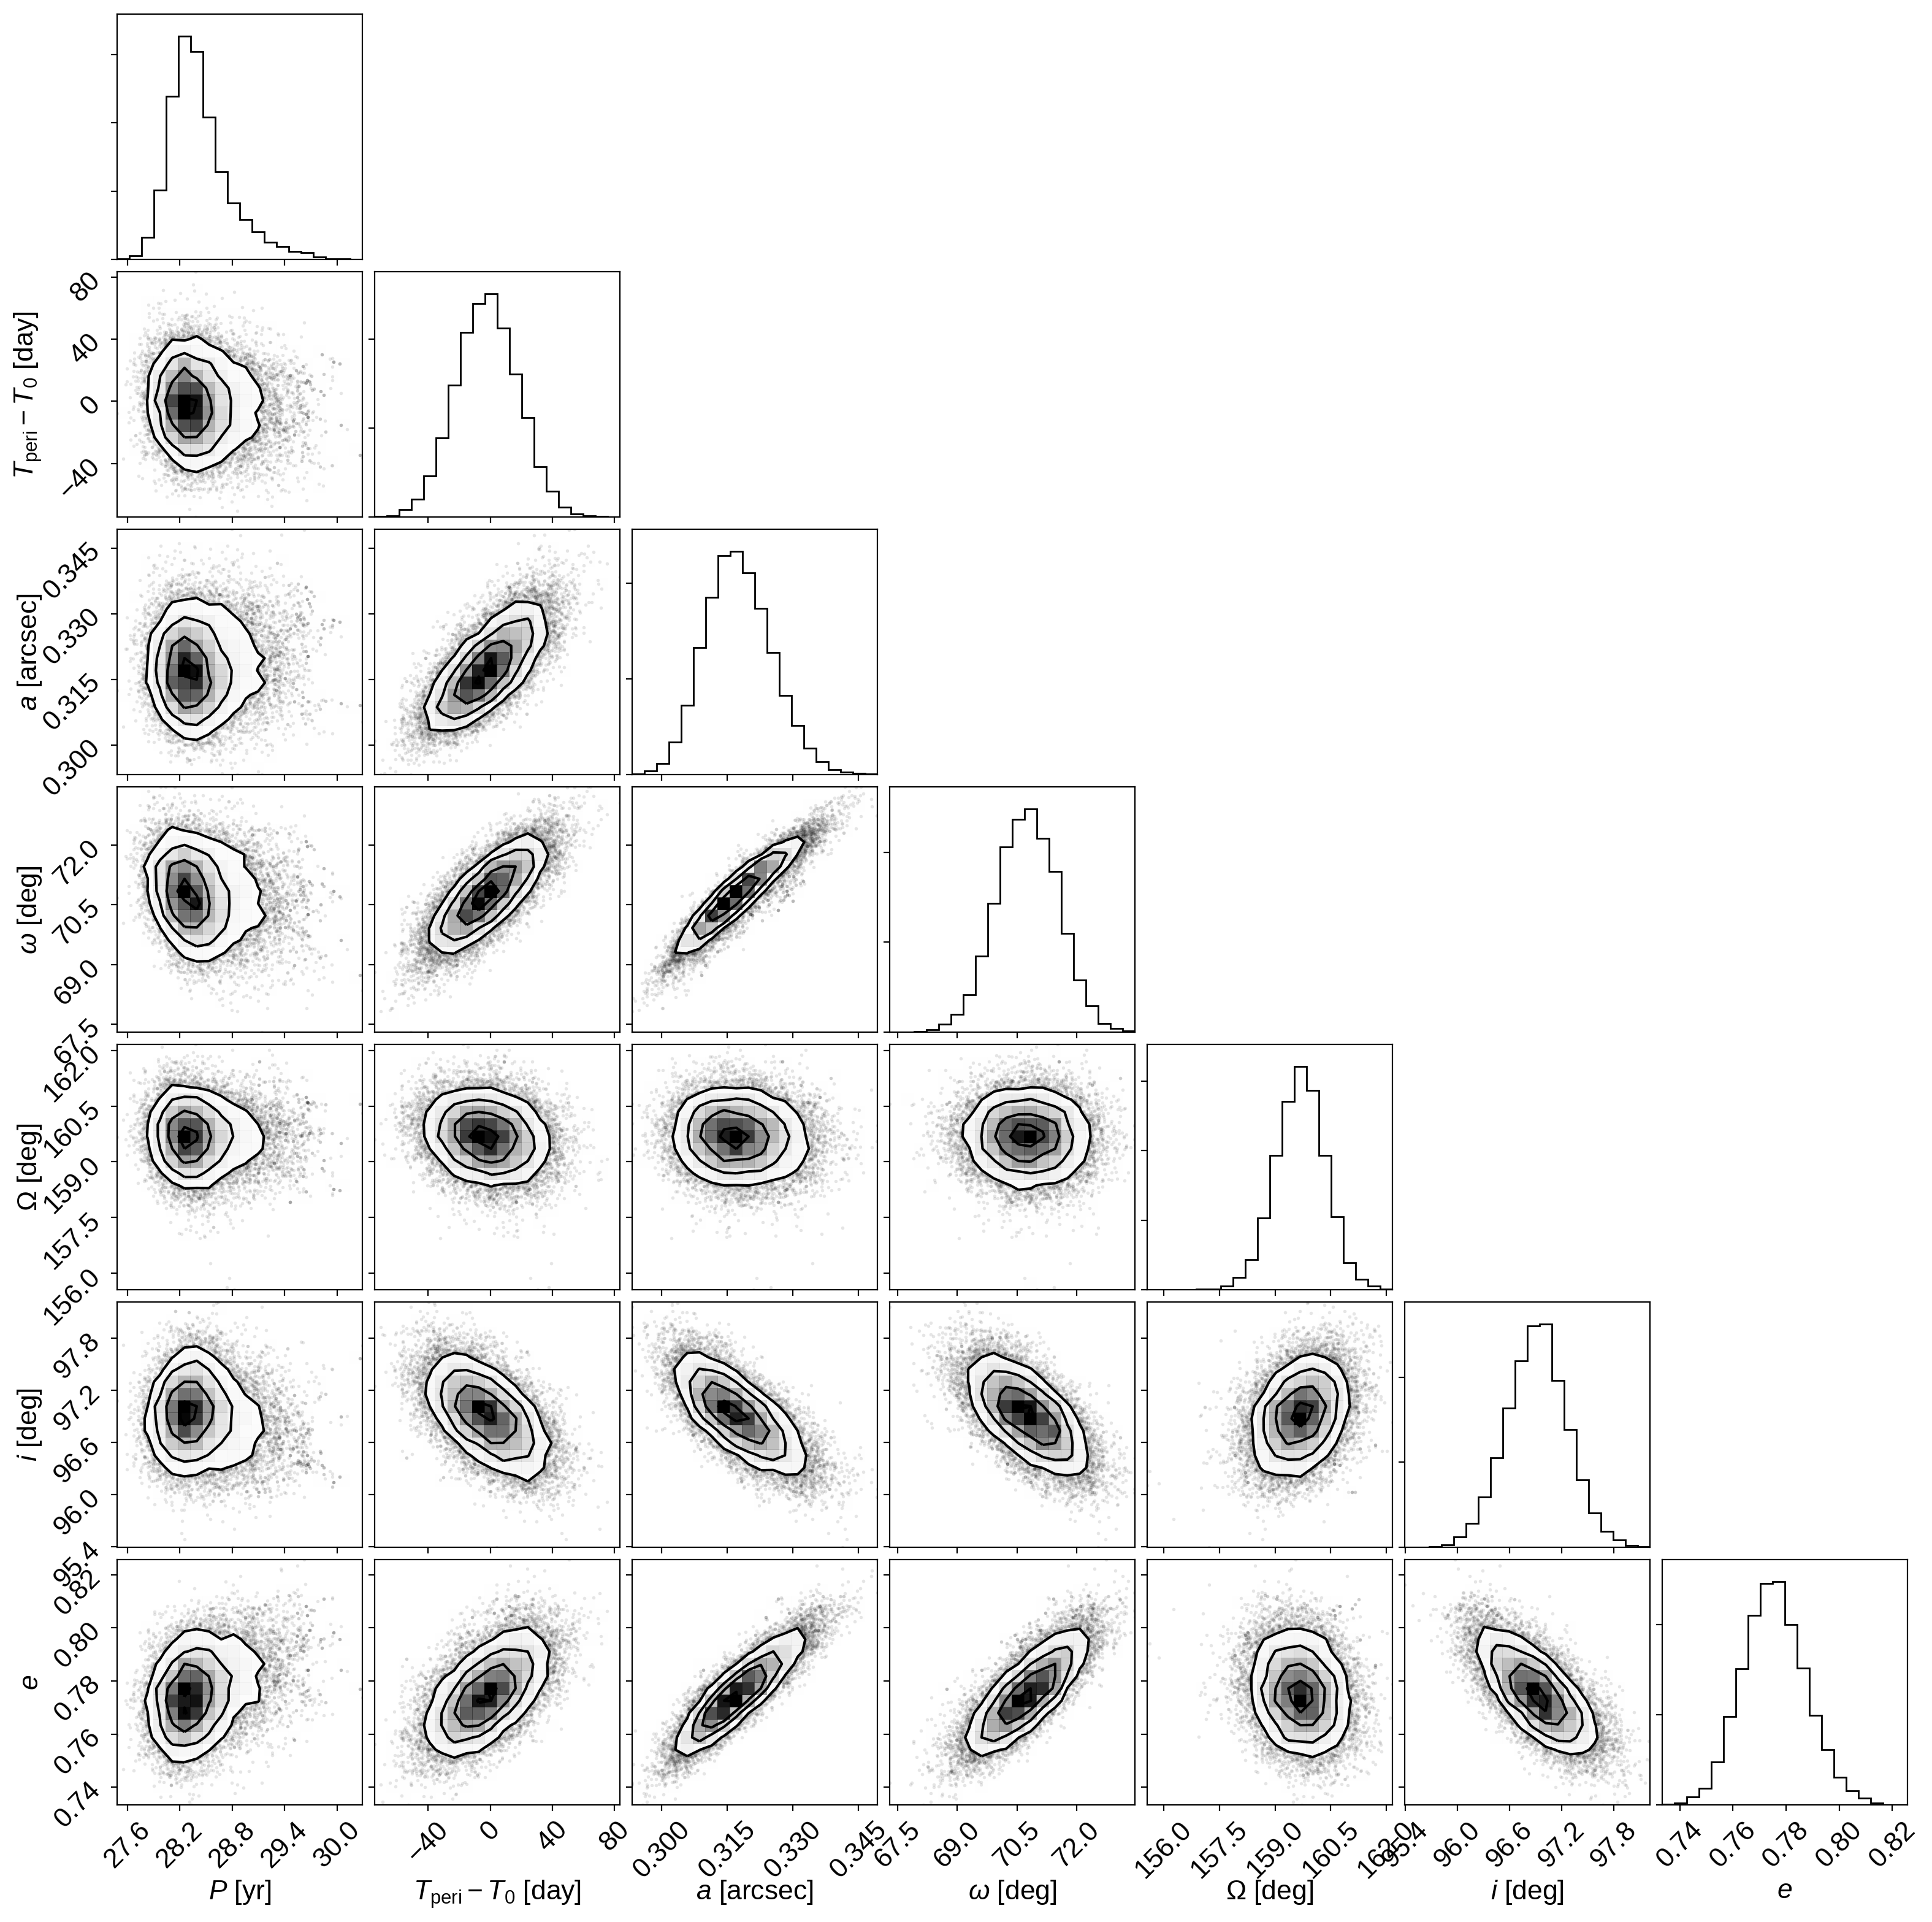

In [12]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["ecc"])
samples["$P$ [yr]"] = trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = trace["tperi"] - T0
samples["$a$ [arcsec]"] = trace["a_ang"]
samples["$\omega$ [deg]"] = (trace["omega"] / deg) % 360
samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
samples["$i$ [deg]"] = (trace["incl"] / deg) % 360
samples["$e$"] = samples["ecc"]
del samples["ecc"]
corner.corner(samples);

Finally, we can plot the posterior constraints on $\rho$ and $\theta$.
This figure is much like the one for the MAP solution above, but this time the orange is a contour (not a line) showing the 68% credible region for the model.

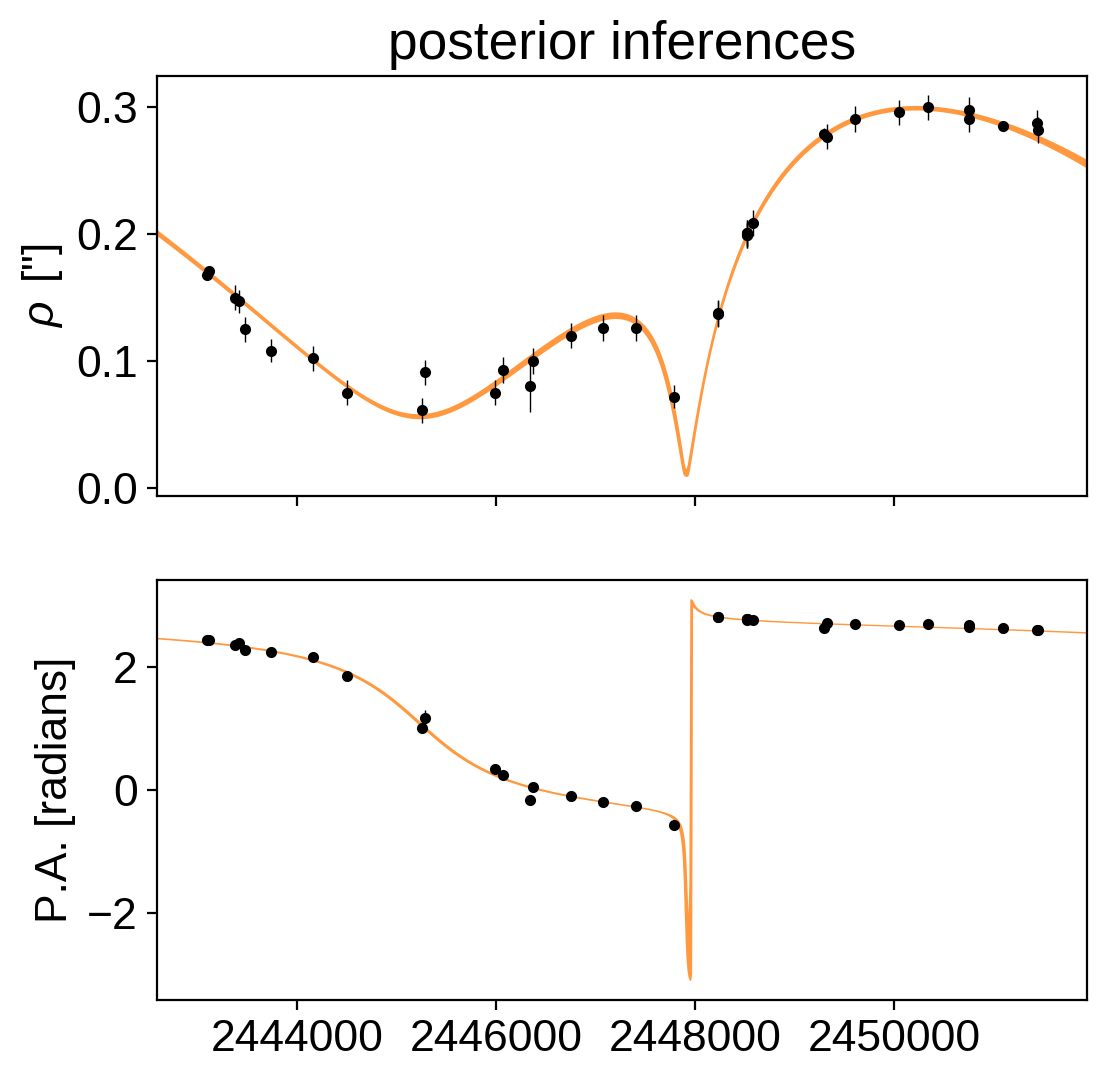

In [13]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'P.A. [radians]')

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * np.median(trace["log_rho_s"], axis=0)))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * np.median(trace["log_theta_s"], axis=0)))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
q = np.percentile(trace["rho_save"], [16, 84], axis=0)
ax[0].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[1].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
q = np.percentile(trace["theta_save"], [16, 84], axis=0)
ax[1].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
ax[0].set_title("posterior inferences");

As we can see from the narrow range of orbits (the orange swath appears like a thin line), the orbit is actually highly constrained by the astrometry.
We also see two outlier epochs in the vicinity of 2445000 - 2447000, since adjacent epochs seem to be right on the orbit.
It's likely the uncertainties were not estimated correctly for these, and the simlplistic jitter model we implemented isn't sophisticated to apply more weight to only these discrepant points.

## Including parallax

While this is encouraging that we fit an astrometric orbit, a simple astrometric fit to just $\rho$ and $\theta$ isn't actually that physically satisfying, since many of the orbital parameters simply have to do with the orientation relative to us ($i$, $\omega$, and $\Omega$). The only truely intrinsic parameters are $P$ and $e$. To learn more about some of the physical parameters, such as the total mass of the system, we'd like to incorporate distance information to put a physical scale to the problem. 

The *Gaia* DR2 parallax is $\varpi = 24.05 \pm 0.45$ mas.

We can use exactly the same model as above with only an added parallax constraint:

In [14]:
plx_model, plx_map_soln = get_model(parallax=[24.05, 0.45])

optimizing logp for variables: [log_theta_s, log_rho_s]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.076402e+02]

1it [00:00, 555.91it/s, logp=1.076402e+02]

2it [00:00, 734.88it/s, logp=1.076402e+02]

3it [00:00, 753.96it/s, logp=1.476711e+02]

4it [00:00, 798.08it/s, logp=1.084303e+02]

5it [00:00, 848.29it/s, logp=1.485840e+02]

6it [00:00, 859.43it/s, logp=1.497845e+02]

7it [00:00, 863.05it/s, logp=1.499280e+02]

8it [00:00, 870.21it/s, logp=1.499286e+02]

9it [00:00, 874.91it/s, logp=1.499286e+02]

10it [00:00, 874.07it/s, logp=1.499286e+02]

11it [00:02,  5.08it/s, logp=1.499286e+02] 


message: Optimization terminated successfully.
logp: 107.6401502957618 -> 149.92860106268085


optimizing logp for variables: [phase]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.499286e+02]

1it [00:00, 529.78it/s, logp=1.499286e+02]

2it [00:00, 696.55it/s, logp=1.499286e+02]

3it [00:00, 737.40it/s, logp=-1.185553e+04]

4it [00:00, 798.80it/s, logp=1.499517e+02] 

5it [00:00, 799.13it/s, logp=1.499982e+02]

6it [00:00, 832.56it/s, logp=1.501832e+02]

7it [00:00, 857.63it/s, logp=1.509035e+02]

8it [00:00, 868.36it/s, logp=1.535077e+02]

9it [00:00, 866.83it/s, logp=1.593811e+02]

10it [00:00, 857.08it/s, logp=1.662757e+02]

11it [00:00, 852.93it/s, logp=1.694242e+02]

12it [00:00, 851.97it/s, logp=1.703302e+02]

13it [00:00, 856.37it/s, logp=1.704061e+02]

14it [00:00, 858.11it/s, logp=1.704094e+02]

15it [00:00, 859.76it/s, logp=1.704128e+02]

16it [00:00, 863.26it/s, logp=1.704184e+02]

17it [00:00, 861.08it/s, logp=1.704249e+02]

18it [00:00, 801.48it/s, logp=1.704265e+02]

19it [00:00, 798.74it/s, logp=1.704268e+02]

20it [00:00, 794.01it/s, logp=1.704268e+02]

21it [00:00, 795.09it/s, logp=1.704268e+02]

22it [00:00, 789.52it/s, logp=1.704268e+02]

23it [00:00, 31.07it/s, logp=1.704268e+02] 


message: Optimization terminated successfully.
logp: 149.92860106268085 -> 170.42681518460188


optimizing logp for variables: [ecc, m, p]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.704268e+02]

1it [00:00, 252.70it/s, logp=1.704268e+02]

2it [00:00, 330.10it/s, logp=1.704268e+02]

3it [00:00, 363.94it/s, logp=-4.518236e+03]

4it [00:00, 398.06it/s, logp=1.710200e+02] 

5it [00:00, 397.20it/s, logp=1.695336e+02]

6it [00:00, 411.57it/s, logp=1.711520e+02]

7it [00:00, 415.32it/s, logp=1.714066e+02]

8it [00:00, 418.83it/s, logp=1.721879e+02]

9it [00:00, 414.25it/s, logp=1.742150e+02]

10it [00:00, 419.90it/s, logp=1.812157e+02]

11it [00:00, 415.90it/s, logp=1.949820e+02]

12it [00:00, 400.05it/s, logp=1.964691e+02]

13it [00:00, 395.49it/s, logp=1.992100e+02]

14it [00:00, 398.62it/s, logp=2.038785e+02]

15it [00:00, 403.52it/s, logp=2.102587e+02]

16it [00:00, 408.29it/s, logp=2.122110e+02]

17it [00:00, 410.69it/s, logp=2.126408e+02]

18it [00:00, 414.81it/s, logp=2.126846e+02]

19it [00:00, 418.38it/s, logp=2.126998e+02]

20it [00:00, 420.76it/s, logp=2.127263e+02]

21it [00:00, 422.01it/s, logp=2.127699e+02]

22it [00:00, 423.13it/s, logp=2.128244e+02]

23it [00:00, 424.16it/s, logp=2.128398e+02]

24it [00:00, 425.57it/s, logp=2.128456e+02]

25it [00:00, 426.72it/s, logp=2.128460e+02]

26it [00:00, 428.50it/s, logp=2.128463e+02]

27it [00:00, 428.45it/s, logp=2.128468e+02]

28it [00:00, 429.22it/s, logp=2.128475e+02]

29it [00:00, 429.27it/s, logp=2.128479e+02]

30it [00:00, 428.10it/s, logp=2.128480e+02]

31it [00:00, 427.83it/s, logp=2.128480e+02]

32it [00:00, 427.45it/s, logp=2.128480e+02]

33it [00:00, 427.16it/s, logp=2.128480e+02]

34it [00:00, 427.06it/s, logp=2.128480e+02]

35it [00:00, 48.14it/s, logp=2.128480e+02] 


message: Optimization terminated successfully.
logp: 170.4268151846019 -> 212.848015885607


optimizing logp for variables: [phase, a_ang, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.128480e+02]

1it [00:00, 567.10it/s, logp=2.128480e+02]

2it [00:00, 754.85it/s, logp=2.128480e+02]

3it [00:00, 805.77it/s, logp=-4.375386e+03]

4it [00:00, 863.78it/s, logp=2.129960e+02] 

5it [00:00, 860.23it/s, logp=2.131453e+02]

6it [00:00, 864.36it/s, logp=2.132729e+02]

7it [00:00, 879.68it/s, logp=2.132857e+02]

8it [00:00, 885.01it/s, logp=2.132857e+02]

9it [00:00, 911.61it/s, logp=2.132860e+02]

10it [00:00, 913.33it/s, logp=2.132860e+02]

11it [00:00, 910.67it/s, logp=2.132860e+02]

12it [00:00, 18.15it/s, logp=2.132860e+02] 


message: Optimization terminated successfully.
logp: 212.848015885607 -> 213.28597909410686


optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.132860e+02]

1it [00:00, 357.39it/s, logp=2.132860e+02]

2it [00:00, 500.13it/s, logp=2.132860e+02]

3it [00:00, 554.63it/s, logp=-4.038433e+03]

4it [00:00, 608.47it/s, logp=2.152474e+02] 

5it [00:00, 619.18it/s, logp=1.676432e+02]

6it [00:00, 647.60it/s, logp=2.153207e+02]

7it [00:00, 644.50it/s, logp=2.154316e+02]

8it [00:00, 649.79it/s, logp=2.156115e+02]

9it [00:00, 648.88it/s, logp=2.158705e+02]

10it [00:00, 638.04it/s, logp=2.160160e+02]

11it [00:00, 640.60it/s, logp=2.158620e+02]

12it [00:00, 632.78it/s, logp=2.160652e+02]

13it [00:00, 627.36it/s, logp=2.160890e+02]

14it [00:00, 619.43it/s, logp=2.161353e+02]

15it [00:00, 625.42it/s, logp=2.162848e+02]

16it [00:00, 612.27it/s, logp=2.166196e+02]

17it [00:00, 607.50it/s, logp=2.171740e+02]

18it [00:00, 602.73it/s, logp=2.175761e+02]

19it [00:00, 584.06it/s, logp=2.174845e+02]

20it [00:00, 579.22it/s, logp=2.176565e+02]

21it [00:00, 575.76it/s, logp=2.177043e+02]

22it [00:00, 568.54it/s, logp=2.177335e+02]

23it [00:00, 562.76it/s, logp=2.177622e+02]

24it [00:00, 562.14it/s, logp=2.177547e+02]

25it [00:00, 565.02it/s, logp=2.177767e+02]

26it [00:00, 565.09it/s, logp=2.177873e+02]

27it [00:00, 562.44it/s, logp=2.177936e+02]

28it [00:00, 545.06it/s, logp=2.178014e+02]

29it [00:00, 537.31it/s, logp=2.178034e+02]

30it [00:00, 522.15it/s, logp=2.178054e+02]

31it [00:00, 520.97it/s, logp=2.178058e+02]

32it [00:00, 516.14it/s, logp=2.178059e+02]

33it [00:00, 513.84it/s, logp=2.178059e+02]

34it [00:00, 510.49it/s, logp=2.178059e+02]

35it [00:00, 470.13it/s, logp=2.178059e+02]

36it [00:00, 463.25it/s, logp=2.178059e+02]

37it [00:00, 465.27it/s, logp=2.178059e+02]

38it [00:00, 468.36it/s, logp=2.178059e+02]

39it [00:00, 471.53it/s, logp=2.178059e+02]

40it [00:01, 37.27it/s, logp=2.178059e+02] 


message: Optimization terminated successfully.
logp: 213.28597909410686 -> 217.80586833502497


In [15]:
np.random.seed(5432)
with plx_model:
    plx_trace = pm.sample(tune=5000, draws=4000, start=plx_map_soln,
                          step=xo.get_dense_nuts_step(target_accept=0.9, start=plx_map_soln))

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 4 chains:   0%|          | 0/36000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 13/36000 [00:00<04:55, 121.96draws/s]

Sampling 4 chains:   0%|          | 17/36000 [00:00<08:12, 73.02draws/s] 

Sampling 4 chains:   0%|          | 22/36000 [00:00<10:10, 58.93draws/s]

Sampling 4 chains:   0%|          | 26/36000 [00:00<13:26, 44.59draws/s]

Sampling 4 chains:   0%|          | 31/36000 [00:00<15:07, 39.63draws/s]

Sampling 4 chains:   0%|          | 36/36000 [00:00<14:19, 41.84draws/s]

Sampling 4 chains:   0%|          | 40/36000 [00:00<15:58, 37.52draws/s]

Sampling 4 chains:   0%|          | 44/36000 [00:01<17:21, 34.52draws/s]

Sampling 4 chains:   0%|          | 48/36000 [00:01<18:19, 32.70draws/s]

Sampling 4 chains:   0%|          | 52/36000 [00:01<17:59, 33.31draws/s]

Sampling 4 chains:   0%|          | 56/36000 [00:01<17:16, 34.66draws/s]

Sampling 4 chains:   0%|          | 60/36000 [00:01<17:41, 33.84draws/s]

Sampling 4 chains:   0%|          | 64/36000 [00:01<16:53, 35.45draws/s]

Sampling 4 chains:   0%|          | 68/36000 [00:01<16:25, 36.45draws/s]

Sampling 4 chains:   0%|          | 72/36000 [00:01<16:23, 36.53draws/s]

Sampling 4 chains:   0%|          | 76/36000 [00:01<18:28, 32.42draws/s]

Sampling 4 chains:   0%|          | 83/36000 [00:02<16:15, 36.83draws/s]

Sampling 4 chains:   0%|          | 88/36000 [00:02<16:02, 37.33draws/s]

Sampling 4 chains:   0%|          | 94/36000 [00:02<15:36, 38.32draws/s]

Sampling 4 chains:   0%|          | 99/36000 [00:02<14:52, 40.20draws/s]

Sampling 4 chains:   0%|          | 104/36000 [00:02<15:20, 38.99draws/s]

Sampling 4 chains:   0%|          | 109/36000 [00:02<14:49, 40.36draws/s]

Sampling 4 chains:   0%|          | 114/36000 [00:02<14:31, 41.20draws/s]

Sampling 4 chains:   0%|          | 119/36000 [00:02<14:13, 42.04draws/s]

Sampling 4 chains:   0%|          | 124/36000 [00:03<13:53, 43.06draws/s]

Sampling 4 chains:   0%|          | 129/36000 [00:03<13:20, 44.79draws/s]

Sampling 4 chains:   0%|          | 134/36000 [00:03<15:09, 39.43draws/s]

Sampling 4 chains:   0%|          | 139/36000 [00:03<14:23, 41.54draws/s]

Sampling 4 chains:   0%|          | 144/36000 [00:03<13:56, 42.88draws/s]

Sampling 4 chains:   0%|          | 149/36000 [00:03<13:29, 44.26draws/s]

Sampling 4 chains:   0%|          | 155/36000 [00:03<12:43, 46.95draws/s]

Sampling 4 chains:   0%|          | 160/36000 [00:03<14:00, 42.64draws/s]

Sampling 4 chains:   0%|          | 165/36000 [00:04<14:19, 41.69draws/s]

Sampling 4 chains:   0%|          | 171/36000 [00:04<13:11, 45.27draws/s]

Sampling 4 chains:   0%|          | 176/36000 [00:04<14:32, 41.08draws/s]

Sampling 4 chains:   1%|          | 181/36000 [00:04<15:30, 38.50draws/s]

Sampling 4 chains:   1%|          | 186/36000 [00:04<16:47, 35.56draws/s]

Sampling 4 chains:   1%|          | 191/36000 [00:04<16:47, 35.53draws/s]

Sampling 4 chains:   1%|          | 197/36000 [00:04<16:18, 36.57draws/s]

Sampling 4 chains:   1%|          | 201/36000 [00:04<16:00, 37.27draws/s]

Sampling 4 chains:   1%|          | 206/36000 [00:05<15:57, 37.40draws/s]

Sampling 4 chains:   1%|          | 211/36000 [00:05<15:10, 39.30draws/s]

Sampling 4 chains:   1%|          | 215/36000 [00:05<15:43, 37.91draws/s]

Sampling 4 chains:   1%|          | 220/36000 [00:05<15:32, 38.36draws/s]

Sampling 4 chains:   1%|          | 224/36000 [00:05<15:24, 38.69draws/s]

Sampling 4 chains:   1%|          | 228/36000 [00:05<16:33, 36.02draws/s]

Sampling 4 chains:   1%|          | 232/36000 [00:05<16:46, 35.55draws/s]

Sampling 4 chains:   1%|          | 238/36000 [00:05<15:51, 37.57draws/s]

Sampling 4 chains:   1%|          | 243/36000 [00:06<15:46, 37.77draws/s]

Sampling 4 chains:   1%|          | 248/36000 [00:06<15:16, 38.99draws/s]

Sampling 4 chains:   1%|          | 253/36000 [00:06<14:35, 40.85draws/s]

Sampling 4 chains:   1%|          | 258/36000 [00:06<15:11, 39.20draws/s]

Sampling 4 chains:   1%|          | 262/36000 [00:06<15:48, 37.68draws/s]

Sampling 4 chains:   1%|          | 266/36000 [00:06<16:16, 36.58draws/s]

Sampling 4 chains:   1%|          | 272/36000 [00:06<15:08, 39.33draws/s]

Sampling 4 chains:   1%|          | 278/36000 [00:06<14:11, 41.93draws/s]

Sampling 4 chains:   1%|          | 283/36000 [00:07<14:52, 40.00draws/s]

Sampling 4 chains:   1%|          | 288/36000 [00:07<14:31, 40.97draws/s]

Sampling 4 chains:   1%|          | 293/36000 [00:07<14:17, 41.64draws/s]

Sampling 4 chains:   1%|          | 298/36000 [00:07<14:17, 41.64draws/s]

Sampling 4 chains:   1%|          | 305/36000 [00:07<14:37, 40.66draws/s]

Sampling 4 chains:   1%|          | 312/36000 [00:07<13:55, 42.70draws/s]

Sampling 4 chains:   1%|          | 322/36000 [00:07<12:30, 47.53draws/s]

Sampling 4 chains:   1%|          | 327/36000 [00:08<12:54, 46.06draws/s]

Sampling 4 chains:   1%|          | 334/36000 [00:08<11:50, 50.23draws/s]

Sampling 4 chains:   1%|          | 340/36000 [00:08<11:51, 50.14draws/s]

Sampling 4 chains:   1%|          | 346/36000 [00:08<12:14, 48.54draws/s]

Sampling 4 chains:   1%|          | 353/36000 [00:08<11:57, 49.67draws/s]

Sampling 4 chains:   1%|          | 359/36000 [00:08<11:50, 50.19draws/s]

Sampling 4 chains:   1%|          | 365/36000 [00:08<13:38, 43.54draws/s]

Sampling 4 chains:   1%|          | 372/36000 [00:08<13:59, 42.46draws/s]

Sampling 4 chains:   1%|          | 377/36000 [00:09<13:37, 43.55draws/s]

Sampling 4 chains:   1%|          | 382/36000 [00:09<13:08, 45.19draws/s]

Sampling 4 chains:   1%|          | 387/36000 [00:09<13:10, 45.03draws/s]

Sampling 4 chains:   1%|          | 392/36000 [00:09<13:46, 43.08draws/s]

Sampling 4 chains:   1%|          | 397/36000 [00:09<14:32, 40.79draws/s]

Sampling 4 chains:   1%|          | 402/36000 [00:09<14:52, 39.90draws/s]

Sampling 4 chains:   1%|          | 407/36000 [00:09<14:27, 41.04draws/s]

Sampling 4 chains:   1%|          | 412/36000 [00:09<14:08, 41.93draws/s]

Sampling 4 chains:   1%|          | 418/36000 [00:10<13:42, 43.27draws/s]

Sampling 4 chains:   1%|          | 425/36000 [00:10<13:07, 45.18draws/s]

Sampling 4 chains:   1%|          | 435/36000 [00:10<11:14, 52.71draws/s]

Sampling 4 chains:   1%|▏         | 454/36000 [00:10<08:49, 67.12draws/s]

Sampling 4 chains:   1%|▏         | 485/36000 [00:10<06:45, 87.63draws/s]

Sampling 4 chains:   1%|▏         | 519/36000 [00:10<05:14, 112.69draws/s]

Sampling 4 chains:   2%|▏         | 548/36000 [00:10<04:17, 137.41draws/s]

Sampling 4 chains:   2%|▏         | 580/36000 [00:10<03:35, 164.62draws/s]

Sampling 4 chains:   2%|▏         | 616/36000 [00:10<03:00, 195.79draws/s]

Sampling 4 chains:   2%|▏         | 655/36000 [00:11<02:33, 230.06draws/s]

Sampling 4 chains:   2%|▏         | 697/36000 [00:11<02:12, 265.99draws/s]

Sampling 4 chains:   2%|▏         | 732/36000 [00:11<02:05, 281.17draws/s]

Sampling 4 chains:   2%|▏         | 766/36000 [00:11<01:59, 294.43draws/s]

Sampling 4 chains:   2%|▏         | 800/36000 [00:11<01:57, 299.82draws/s]

Sampling 4 chains:   2%|▏         | 833/36000 [00:11<01:58, 295.82draws/s]

Sampling 4 chains:   2%|▏         | 869/36000 [00:11<01:52, 311.80draws/s]

Sampling 4 chains:   3%|▎         | 907/36000 [00:11<01:46, 328.68draws/s]

Sampling 4 chains:   3%|▎         | 947/36000 [00:11<01:41, 347.00draws/s]

Sampling 4 chains:   3%|▎         | 989/36000 [00:11<01:37, 360.47draws/s]

Sampling 4 chains:   3%|▎         | 1027/36000 [00:12<01:37, 359.44draws/s]

Sampling 4 chains:   3%|▎         | 1071/36000 [00:12<01:31, 379.94draws/s]

Sampling 4 chains:   3%|▎         | 1110/36000 [00:12<01:33, 374.83draws/s]

Sampling 4 chains:   3%|▎         | 1149/36000 [00:12<01:32, 377.64draws/s]

Sampling 4 chains:   3%|▎         | 1188/36000 [00:12<01:31, 379.68draws/s]

Sampling 4 chains:   3%|▎         | 1230/36000 [00:12<01:29, 387.86draws/s]

Sampling 4 chains:   4%|▎         | 1272/36000 [00:12<01:28, 393.23draws/s]

Sampling 4 chains:   4%|▎         | 1312/36000 [00:12<01:29, 386.23draws/s]

Sampling 4 chains:   4%|▍         | 1352/36000 [00:12<01:29, 388.23draws/s]

Sampling 4 chains:   4%|▍         | 1399/36000 [00:13<01:24, 409.55draws/s]

Sampling 4 chains:   4%|▍         | 1441/36000 [00:13<01:26, 397.34draws/s]

Sampling 4 chains:   4%|▍         | 1482/36000 [00:13<01:29, 385.48draws/s]

Sampling 4 chains:   4%|▍         | 1521/36000 [00:13<01:30, 380.23draws/s]

Sampling 4 chains:   4%|▍         | 1560/36000 [00:13<01:35, 362.52draws/s]

Sampling 4 chains:   4%|▍         | 1597/36000 [00:13<01:35, 358.48draws/s]

Sampling 4 chains:   5%|▍         | 1634/36000 [00:13<01:36, 355.33draws/s]

Sampling 4 chains:   5%|▍         | 1677/36000 [00:13<01:31, 373.86draws/s]

Sampling 4 chains:   5%|▍         | 1725/36000 [00:13<01:25, 398.76draws/s]

Sampling 4 chains:   5%|▍         | 1766/36000 [00:13<01:26, 396.62draws/s]

Sampling 4 chains:   5%|▌         | 1812/36000 [00:14<01:23, 411.86draws/s]

Sampling 4 chains:   5%|▌         | 1855/36000 [00:14<01:22, 414.44draws/s]

Sampling 4 chains:   5%|▌         | 1897/36000 [00:14<01:22, 411.92draws/s]

Sampling 4 chains:   5%|▌         | 1939/36000 [00:14<01:24, 401.60draws/s]

Sampling 4 chains:   6%|▌         | 1980/36000 [00:14<01:25, 397.53draws/s]

Sampling 4 chains:   6%|▌         | 2020/36000 [00:14<01:26, 393.98draws/s]

Sampling 4 chains:   6%|▌         | 2060/36000 [00:14<01:28, 382.64draws/s]

Sampling 4 chains:   6%|▌         | 2103/36000 [00:14<01:25, 395.29draws/s]

Sampling 4 chains:   6%|▌         | 2143/36000 [00:14<01:25, 396.13draws/s]

Sampling 4 chains:   6%|▌         | 2183/36000 [00:15<01:27, 387.59draws/s]

Sampling 4 chains:   6%|▌         | 2222/36000 [00:15<01:28, 383.59draws/s]

Sampling 4 chains:   6%|▋         | 2265/36000 [00:15<01:25, 395.35draws/s]

Sampling 4 chains:   6%|▋         | 2308/36000 [00:15<01:23, 402.77draws/s]

Sampling 4 chains:   7%|▋         | 2352/36000 [00:15<01:21, 413.21draws/s]

Sampling 4 chains:   7%|▋         | 2394/36000 [00:15<01:27, 382.20draws/s]

Sampling 4 chains:   7%|▋         | 2435/36000 [00:15<01:26, 389.82draws/s]

Sampling 4 chains:   7%|▋         | 2475/36000 [00:15<01:31, 364.79draws/s]

Sampling 4 chains:   7%|▋         | 2516/36000 [00:15<01:29, 375.51draws/s]

Sampling 4 chains:   7%|▋         | 2557/36000 [00:15<01:27, 384.35draws/s]

Sampling 4 chains:   7%|▋         | 2596/36000 [00:16<01:27, 381.65draws/s]

Sampling 4 chains:   7%|▋         | 2637/36000 [00:16<01:26, 384.00draws/s]

Sampling 4 chains:   7%|▋         | 2676/36000 [00:16<01:27, 380.33draws/s]

Sampling 4 chains:   8%|▊         | 2715/36000 [00:16<01:27, 378.87draws/s]

Sampling 4 chains:   8%|▊         | 2755/36000 [00:16<01:26, 383.75draws/s]

Sampling 4 chains:   8%|▊         | 2803/36000 [00:16<01:21, 407.12draws/s]

Sampling 4 chains:   8%|▊         | 2851/36000 [00:16<01:18, 423.66draws/s]

Sampling 4 chains:   8%|▊         | 2901/36000 [00:16<01:14, 442.32draws/s]

Sampling 4 chains:   8%|▊         | 2946/36000 [00:16<01:15, 436.51draws/s]

Sampling 4 chains:   8%|▊         | 2991/36000 [00:17<01:17, 425.93draws/s]

Sampling 4 chains:   8%|▊         | 3034/36000 [00:17<01:18, 422.64draws/s]

Sampling 4 chains:   9%|▊         | 3077/36000 [00:17<01:23, 396.47draws/s]

Sampling 4 chains:   9%|▊         | 3119/36000 [00:17<01:21, 402.02draws/s]

Sampling 4 chains:   9%|▉         | 3160/36000 [00:17<01:21, 400.79draws/s]

Sampling 4 chains:   9%|▉         | 3201/36000 [00:17<01:23, 390.74draws/s]

Sampling 4 chains:   9%|▉         | 3243/36000 [00:17<01:22, 397.70draws/s]

Sampling 4 chains:   9%|▉         | 3295/36000 [00:17<01:16, 424.85draws/s]

Sampling 4 chains:   9%|▉         | 3343/36000 [00:17<01:14, 439.95draws/s]

Sampling 4 chains:   9%|▉         | 3390/36000 [00:17<01:13, 446.64draws/s]

Sampling 4 chains:  10%|▉         | 3436/36000 [00:18<01:15, 431.01draws/s]

Sampling 4 chains:  10%|▉         | 3480/36000 [00:18<01:23, 389.75draws/s]

Sampling 4 chains:  10%|▉         | 3521/36000 [00:18<01:23, 387.76draws/s]

Sampling 4 chains:  10%|▉         | 3561/36000 [00:18<01:24, 384.96draws/s]

Sampling 4 chains:  10%|█         | 3605/36000 [00:18<01:21, 398.73draws/s]

Sampling 4 chains:  10%|█         | 3646/36000 [00:18<01:21, 394.84draws/s]

Sampling 4 chains:  10%|█         | 3689/36000 [00:18<01:20, 403.86draws/s]

Sampling 4 chains:  10%|█         | 3732/36000 [00:18<01:19, 408.20draws/s]

Sampling 4 chains:  10%|█         | 3774/36000 [00:18<01:19, 403.88draws/s]

Sampling 4 chains:  11%|█         | 3815/36000 [00:19<01:19, 402.73draws/s]

Sampling 4 chains:  11%|█         | 3856/36000 [00:19<01:19, 404.77draws/s]

Sampling 4 chains:  11%|█         | 3902/36000 [00:19<01:16, 419.46draws/s]

Sampling 4 chains:  11%|█         | 3949/36000 [00:19<01:14, 432.36draws/s]

Sampling 4 chains:  11%|█         | 3993/36000 [00:19<01:15, 425.54draws/s]

Sampling 4 chains:  11%|█         | 4042/36000 [00:19<01:12, 442.68draws/s]

Sampling 4 chains:  11%|█▏        | 4087/36000 [00:19<01:17, 411.81draws/s]

Sampling 4 chains:  11%|█▏        | 4129/36000 [00:19<01:19, 400.14draws/s]

Sampling 4 chains:  12%|█▏        | 4180/36000 [00:19<01:14, 426.58draws/s]

Sampling 4 chains:  12%|█▏        | 4224/36000 [00:20<01:18, 404.01draws/s]

Sampling 4 chains:  12%|█▏        | 4266/36000 [00:20<01:21, 388.72draws/s]

Sampling 4 chains:  12%|█▏        | 4306/36000 [00:20<01:24, 376.18draws/s]

Sampling 4 chains:  12%|█▏        | 4348/36000 [00:20<01:21, 387.76draws/s]

Sampling 4 chains:  12%|█▏        | 4390/36000 [00:20<01:19, 396.42draws/s]

Sampling 4 chains:  12%|█▏        | 4434/36000 [00:20<01:17, 406.75draws/s]

Sampling 4 chains:  12%|█▏        | 4476/36000 [00:20<01:22, 380.96draws/s]

Sampling 4 chains:  13%|█▎        | 4515/36000 [00:20<01:22, 382.95draws/s]

Sampling 4 chains:  13%|█▎        | 4554/36000 [00:20<01:21, 383.49draws/s]

Sampling 4 chains:  13%|█▎        | 4593/36000 [00:21<01:21, 383.48draws/s]

Sampling 4 chains:  13%|█▎        | 4634/36000 [00:21<01:20, 390.55draws/s]

Sampling 4 chains:  13%|█▎        | 4674/36000 [00:21<01:21, 382.47draws/s]

Sampling 4 chains:  13%|█▎        | 4716/36000 [00:21<01:20, 388.71draws/s]

Sampling 4 chains:  13%|█▎        | 4757/36000 [00:21<01:19, 392.25draws/s]

Sampling 4 chains:  13%|█▎        | 4797/36000 [00:21<01:20, 386.18draws/s]

Sampling 4 chains:  13%|█▎        | 4836/36000 [00:21<01:24, 370.50draws/s]

Sampling 4 chains:  14%|█▎        | 4874/36000 [00:21<01:25, 364.05draws/s]

Sampling 4 chains:  14%|█▎        | 4915/36000 [00:21<01:22, 374.86draws/s]

Sampling 4 chains:  14%|█▍        | 4953/36000 [00:21<01:25, 362.26draws/s]

Sampling 4 chains:  14%|█▍        | 4991/36000 [00:22<01:24, 367.14draws/s]

Sampling 4 chains:  14%|█▍        | 5029/36000 [00:22<01:23, 370.25draws/s]

Sampling 4 chains:  14%|█▍        | 5070/36000 [00:22<01:21, 380.32draws/s]

Sampling 4 chains:  14%|█▍        | 5112/36000 [00:22<01:21, 379.86draws/s]

Sampling 4 chains:  14%|█▍        | 5151/36000 [00:22<01:24, 362.97draws/s]

Sampling 4 chains:  14%|█▍        | 5188/36000 [00:22<01:28, 346.75draws/s]

Sampling 4 chains:  15%|█▍        | 5226/36000 [00:22<01:27, 350.42draws/s]

Sampling 4 chains:  15%|█▍        | 5267/36000 [00:22<01:23, 366.33draws/s]

Sampling 4 chains:  15%|█▍        | 5307/36000 [00:22<01:21, 375.44draws/s]

Sampling 4 chains:  15%|█▍        | 5358/36000 [00:23<01:15, 406.98draws/s]

Sampling 4 chains:  15%|█▌        | 5400/36000 [00:23<01:14, 408.38draws/s]

Sampling 4 chains:  15%|█▌        | 5443/36000 [00:23<01:13, 413.46draws/s]

Sampling 4 chains:  15%|█▌        | 5485/36000 [00:23<01:18, 390.03draws/s]

Sampling 4 chains:  15%|█▌        | 5525/36000 [00:23<01:17, 392.11draws/s]

Sampling 4 chains:  15%|█▌        | 5568/36000 [00:23<01:15, 400.99draws/s]

Sampling 4 chains:  16%|█▌        | 5609/36000 [00:23<01:16, 399.43draws/s]

Sampling 4 chains:  16%|█▌        | 5650/36000 [00:23<01:17, 391.62draws/s]

Sampling 4 chains:  16%|█▌        | 5690/36000 [00:23<01:17, 391.49draws/s]

Sampling 4 chains:  16%|█▌        | 5732/36000 [00:23<01:15, 398.61draws/s]

Sampling 4 chains:  16%|█▌        | 5779/36000 [00:24<01:12, 417.33draws/s]

Sampling 4 chains:  16%|█▌        | 5823/36000 [00:24<01:11, 420.66draws/s]

Sampling 4 chains:  16%|█▋        | 5866/36000 [00:24<01:15, 398.80draws/s]

Sampling 4 chains:  16%|█▋        | 5907/36000 [00:24<01:25, 353.61draws/s]

Sampling 4 chains:  17%|█▋        | 5944/36000 [00:24<01:26, 348.12draws/s]

Sampling 4 chains:  17%|█▋        | 5987/36000 [00:24<01:21, 366.23draws/s]

Sampling 4 chains:  17%|█▋        | 6025/36000 [00:24<01:22, 361.47draws/s]

Sampling 4 chains:  17%|█▋        | 6065/36000 [00:24<01:21, 369.48draws/s]

Sampling 4 chains:  17%|█▋        | 6104/36000 [00:24<01:20, 371.80draws/s]

Sampling 4 chains:  17%|█▋        | 6142/36000 [00:25<01:22, 362.22draws/s]

Sampling 4 chains:  17%|█▋        | 6185/36000 [00:25<01:18, 378.44draws/s]

Sampling 4 chains:  17%|█▋        | 6226/36000 [00:25<01:17, 381.93draws/s]

Sampling 4 chains:  17%|█▋        | 6265/36000 [00:25<01:18, 380.70draws/s]

Sampling 4 chains:  18%|█▊        | 6304/36000 [00:25<01:19, 374.81draws/s]

Sampling 4 chains:  18%|█▊        | 6342/36000 [00:25<01:19, 373.33draws/s]

Sampling 4 chains:  18%|█▊        | 6380/36000 [00:25<01:21, 362.75draws/s]

Sampling 4 chains:  18%|█▊        | 6418/36000 [00:25<01:20, 367.70draws/s]

Sampling 4 chains:  18%|█▊        | 6461/36000 [00:25<01:17, 383.35draws/s]

Sampling 4 chains:  18%|█▊        | 6500/36000 [00:26<01:20, 365.51draws/s]

Sampling 4 chains:  18%|█▊        | 6538/36000 [00:26<01:19, 368.85draws/s]

Sampling 4 chains:  18%|█▊        | 6578/36000 [00:26<01:18, 376.41draws/s]

Sampling 4 chains:  18%|█▊        | 6616/36000 [00:26<01:21, 361.03draws/s]

Sampling 4 chains:  18%|█▊        | 6653/36000 [00:26<01:21, 361.25draws/s]

Sampling 4 chains:  19%|█▊        | 6690/36000 [00:26<01:21, 359.62draws/s]

Sampling 4 chains:  19%|█▊        | 6727/36000 [00:26<01:20, 362.65draws/s]

Sampling 4 chains:  19%|█▉        | 6766/36000 [00:26<01:19, 369.78draws/s]

Sampling 4 chains:  19%|█▉        | 6812/36000 [00:26<01:14, 392.13draws/s]

Sampling 4 chains:  19%|█▉        | 6856/36000 [00:26<01:12, 404.26draws/s]

Sampling 4 chains:  19%|█▉        | 6897/36000 [00:27<01:13, 395.66draws/s]

Sampling 4 chains:  19%|█▉        | 6939/36000 [00:27<01:12, 398.68draws/s]

Sampling 4 chains:  19%|█▉        | 6980/36000 [00:27<01:13, 395.20draws/s]

Sampling 4 chains:  20%|█▉        | 7020/36000 [00:27<01:16, 380.18draws/s]

Sampling 4 chains:  20%|█▉        | 7060/36000 [00:27<01:15, 385.10draws/s]

Sampling 4 chains:  20%|█▉        | 7109/36000 [00:27<01:10, 410.96draws/s]

Sampling 4 chains:  20%|█▉        | 7157/36000 [00:27<01:07, 424.73draws/s]

Sampling 4 chains:  20%|██        | 7201/36000 [00:27<01:09, 412.20draws/s]

Sampling 4 chains:  20%|██        | 7244/36000 [00:27<01:10, 409.90draws/s]

Sampling 4 chains:  20%|██        | 7286/36000 [00:28<01:10, 408.91draws/s]

Sampling 4 chains:  20%|██        | 7328/36000 [00:28<01:13, 389.76draws/s]

Sampling 4 chains:  20%|██        | 7368/36000 [00:28<01:14, 384.45draws/s]

Sampling 4 chains:  21%|██        | 7407/36000 [00:28<01:15, 378.95draws/s]

Sampling 4 chains:  21%|██        | 7448/36000 [00:28<01:13, 386.25draws/s]

Sampling 4 chains:  21%|██        | 7496/36000 [00:28<01:09, 409.59draws/s]

Sampling 4 chains:  21%|██        | 7540/36000 [00:28<01:08, 413.90draws/s]

Sampling 4 chains:  21%|██        | 7582/36000 [00:28<01:09, 407.40draws/s]

Sampling 4 chains:  21%|██        | 7626/36000 [00:28<01:08, 415.62draws/s]

Sampling 4 chains:  21%|██▏       | 7671/36000 [00:28<01:06, 423.45draws/s]

Sampling 4 chains:  21%|██▏       | 7720/36000 [00:29<01:04, 439.54draws/s]

Sampling 4 chains:  22%|██▏       | 7769/36000 [00:29<01:02, 452.32draws/s]

Sampling 4 chains:  22%|██▏       | 7815/36000 [00:29<01:07, 418.92draws/s]

Sampling 4 chains:  22%|██▏       | 7858/36000 [00:29<01:08, 413.85draws/s]

Sampling 4 chains:  22%|██▏       | 7900/36000 [00:29<01:10, 396.84draws/s]

Sampling 4 chains:  22%|██▏       | 7941/36000 [00:29<01:12, 388.45draws/s]

Sampling 4 chains:  22%|██▏       | 7981/36000 [00:29<01:11, 389.30draws/s]

Sampling 4 chains:  22%|██▏       | 8024/36000 [00:29<01:10, 397.17draws/s]

Sampling 4 chains:  22%|██▏       | 8064/36000 [00:29<01:11, 393.46draws/s]

Sampling 4 chains:  23%|██▎       | 8110/36000 [00:30<01:08, 409.97draws/s]

Sampling 4 chains:  23%|██▎       | 8152/36000 [00:30<01:07, 411.48draws/s]

Sampling 4 chains:  23%|██▎       | 8194/36000 [00:30<01:10, 395.51draws/s]

Sampling 4 chains:  23%|██▎       | 8237/36000 [00:30<01:08, 403.57draws/s]

Sampling 4 chains:  23%|██▎       | 8278/36000 [00:30<01:11, 386.98draws/s]

Sampling 4 chains:  23%|██▎       | 8318/36000 [00:30<01:11, 386.97draws/s]

Sampling 4 chains:  23%|██▎       | 8357/36000 [00:30<01:17, 356.50draws/s]

Sampling 4 chains:  23%|██▎       | 8395/36000 [00:30<01:16, 362.35draws/s]

Sampling 4 chains:  23%|██▎       | 8433/36000 [00:30<01:15, 365.71draws/s]

Sampling 4 chains:  24%|██▎       | 8471/36000 [00:31<01:14, 367.20draws/s]

Sampling 4 chains:  24%|██▎       | 8515/36000 [00:31<01:11, 385.72draws/s]

Sampling 4 chains:  24%|██▍       | 8554/36000 [00:31<01:11, 383.17draws/s]

Sampling 4 chains:  24%|██▍       | 8593/36000 [00:31<01:13, 372.72draws/s]

Sampling 4 chains:  24%|██▍       | 8631/36000 [00:31<01:13, 370.22draws/s]

Sampling 4 chains:  24%|██▍       | 8672/36000 [00:31<01:11, 379.84draws/s]

Sampling 4 chains:  24%|██▍       | 8711/36000 [00:31<01:11, 380.53draws/s]

Sampling 4 chains:  24%|██▍       | 8750/36000 [00:31<01:12, 376.10draws/s]

Sampling 4 chains:  24%|██▍       | 8788/36000 [00:31<01:12, 377.22draws/s]

Sampling 4 chains:  25%|██▍       | 8826/36000 [00:31<01:12, 375.99draws/s]

Sampling 4 chains:  25%|██▍       | 8864/36000 [00:32<01:15, 359.15draws/s]

Sampling 4 chains:  25%|██▍       | 8901/36000 [00:32<01:15, 358.99draws/s]

Sampling 4 chains:  25%|██▍       | 8947/36000 [00:32<01:10, 382.98draws/s]

Sampling 4 chains:  25%|██▍       | 8991/36000 [00:32<01:08, 393.85draws/s]

Sampling 4 chains:  25%|██▌       | 9031/36000 [00:32<01:08, 392.68draws/s]

Sampling 4 chains:  25%|██▌       | 9071/36000 [00:32<01:12, 373.70draws/s]

Sampling 4 chains:  25%|██▌       | 9109/36000 [00:32<01:15, 354.69draws/s]

Sampling 4 chains:  25%|██▌       | 9145/36000 [00:32<01:16, 352.88draws/s]

Sampling 4 chains:  26%|██▌       | 9181/36000 [00:32<01:15, 353.67draws/s]

Sampling 4 chains:  26%|██▌       | 9217/36000 [00:33<01:18, 342.76draws/s]

Sampling 4 chains:  26%|██▌       | 9253/36000 [00:33<01:17, 346.57draws/s]

Sampling 4 chains:  26%|██▌       | 9292/36000 [00:33<01:15, 355.51draws/s]

Sampling 4 chains:  26%|██▌       | 9329/36000 [00:33<01:14, 358.60draws/s]

Sampling 4 chains:  26%|██▌       | 9365/36000 [00:33<01:15, 350.75draws/s]

Sampling 4 chains:  26%|██▌       | 9402/36000 [00:33<01:15, 352.70draws/s]

Sampling 4 chains:  26%|██▌       | 9444/36000 [00:33<01:11, 369.18draws/s]

Sampling 4 chains:  26%|██▋       | 9482/36000 [00:33<01:14, 355.54draws/s]

Sampling 4 chains:  26%|██▋       | 9518/36000 [00:33<01:16, 344.01draws/s]

Sampling 4 chains:  27%|██▋       | 9553/36000 [00:33<01:19, 333.09draws/s]

Sampling 4 chains:  27%|██▋       | 9588/36000 [00:34<01:18, 337.83draws/s]

Sampling 4 chains:  27%|██▋       | 9622/36000 [00:34<01:20, 327.23draws/s]

Sampling 4 chains:  27%|██▋       | 9656/36000 [00:34<01:19, 330.20draws/s]

Sampling 4 chains:  27%|██▋       | 9690/36000 [00:34<01:20, 326.17draws/s]

Sampling 4 chains:  27%|██▋       | 9730/36000 [00:34<01:16, 344.67draws/s]

Sampling 4 chains:  27%|██▋       | 9766/36000 [00:34<01:15, 348.43draws/s]

Sampling 4 chains:  27%|██▋       | 9802/36000 [00:34<01:16, 343.43draws/s]

Sampling 4 chains:  27%|██▋       | 9843/36000 [00:34<01:12, 359.79draws/s]

Sampling 4 chains:  27%|██▋       | 9880/36000 [00:34<01:14, 352.15draws/s]

Sampling 4 chains:  28%|██▊       | 9917/36000 [00:35<01:13, 356.97draws/s]

Sampling 4 chains:  28%|██▊       | 9962/36000 [00:35<01:08, 378.64draws/s]

Sampling 4 chains:  28%|██▊       | 10006/36000 [00:35<01:05, 395.05draws/s]

Sampling 4 chains:  28%|██▊       | 10049/36000 [00:35<01:04, 404.62draws/s]

Sampling 4 chains:  28%|██▊       | 10090/36000 [00:35<01:05, 393.70draws/s]

Sampling 4 chains:  28%|██▊       | 10130/36000 [00:35<01:07, 384.94draws/s]

Sampling 4 chains:  28%|██▊       | 10171/36000 [00:35<01:06, 390.02draws/s]

Sampling 4 chains:  28%|██▊       | 10216/36000 [00:35<01:03, 403.04draws/s]

Sampling 4 chains:  28%|██▊       | 10257/36000 [00:35<01:05, 391.58draws/s]

Sampling 4 chains:  29%|██▊       | 10297/36000 [00:35<01:08, 373.79draws/s]

Sampling 4 chains:  29%|██▊       | 10335/36000 [00:36<01:10, 361.93draws/s]

Sampling 4 chains:  29%|██▉       | 10378/36000 [00:36<01:08, 374.44draws/s]

Sampling 4 chains:  29%|██▉       | 10416/36000 [00:36<01:09, 370.34draws/s]

Sampling 4 chains:  29%|██▉       | 10454/36000 [00:36<01:08, 370.52draws/s]

Sampling 4 chains:  29%|██▉       | 10492/36000 [00:36<01:09, 366.05draws/s]

Sampling 4 chains:  29%|██▉       | 10532/36000 [00:36<01:08, 371.96draws/s]

Sampling 4 chains:  29%|██▉       | 10573/36000 [00:36<01:06, 380.98draws/s]

Sampling 4 chains:  29%|██▉       | 10613/36000 [00:36<01:05, 385.54draws/s]

Sampling 4 chains:  30%|██▉       | 10654/36000 [00:36<01:04, 390.09draws/s]

Sampling 4 chains:  30%|██▉       | 10694/36000 [00:37<01:05, 385.95draws/s]

Sampling 4 chains:  30%|██▉       | 10733/36000 [00:37<01:08, 367.18draws/s]

Sampling 4 chains:  30%|██▉       | 10770/36000 [00:37<01:12, 348.43draws/s]

Sampling 4 chains:  30%|███       | 10806/36000 [00:37<01:16, 330.77draws/s]

Sampling 4 chains:  30%|███       | 10840/36000 [00:37<01:18, 319.16draws/s]

Sampling 4 chains:  30%|███       | 10873/36000 [00:37<01:19, 316.99draws/s]

Sampling 4 chains:  30%|███       | 10915/36000 [00:37<01:14, 338.61draws/s]

Sampling 4 chains:  30%|███       | 10962/36000 [00:37<01:07, 368.51draws/s]

Sampling 4 chains:  31%|███       | 11006/36000 [00:37<01:04, 385.43draws/s]

Sampling 4 chains:  31%|███       | 11046/36000 [00:38<01:05, 379.13draws/s]

Sampling 4 chains:  31%|███       | 11085/36000 [00:38<01:08, 366.19draws/s]

Sampling 4 chains:  31%|███       | 11123/36000 [00:38<01:08, 361.51draws/s]

Sampling 4 chains:  31%|███       | 11164/36000 [00:38<01:06, 371.81draws/s]

Sampling 4 chains:  31%|███       | 11205/36000 [00:38<01:04, 382.45draws/s]

Sampling 4 chains:  31%|███       | 11244/36000 [00:38<01:06, 371.35draws/s]

Sampling 4 chains:  31%|███▏      | 11285/36000 [00:38<01:04, 381.72draws/s]

Sampling 4 chains:  31%|███▏      | 11328/36000 [00:38<01:02, 393.02draws/s]

Sampling 4 chains:  32%|███▏      | 11373/36000 [00:38<01:01, 401.06draws/s]

Sampling 4 chains:  32%|███▏      | 11414/36000 [00:38<01:01, 398.77draws/s]

Sampling 4 chains:  32%|███▏      | 11455/36000 [00:39<01:01, 398.11draws/s]

Sampling 4 chains:  32%|███▏      | 11495/36000 [00:39<01:02, 393.19draws/s]

Sampling 4 chains:  32%|███▏      | 11535/36000 [00:39<01:04, 378.74draws/s]

Sampling 4 chains:  32%|███▏      | 11574/36000 [00:39<01:04, 379.61draws/s]

Sampling 4 chains:  32%|███▏      | 11617/36000 [00:39<01:02, 393.25draws/s]

Sampling 4 chains:  32%|███▏      | 11657/36000 [00:39<01:02, 387.62draws/s]

Sampling 4 chains:  32%|███▏      | 11696/36000 [00:39<01:04, 376.20draws/s]

Sampling 4 chains:  33%|███▎      | 11737/36000 [00:39<01:03, 384.85draws/s]

Sampling 4 chains:  33%|███▎      | 11777/36000 [00:39<01:02, 389.18draws/s]

Sampling 4 chains:  33%|███▎      | 11817/36000 [00:40<01:05, 367.68draws/s]

Sampling 4 chains:  33%|███▎      | 11855/36000 [00:40<01:06, 365.83draws/s]

Sampling 4 chains:  33%|███▎      | 11892/36000 [00:40<01:07, 358.53draws/s]

Sampling 4 chains:  33%|███▎      | 11937/36000 [00:40<01:03, 381.46draws/s]

Sampling 4 chains:  33%|███▎      | 11976/36000 [00:40<01:03, 381.04draws/s]

Sampling 4 chains:  33%|███▎      | 12023/36000 [00:40<01:00, 399.52draws/s]

Sampling 4 chains:  34%|███▎      | 12068/36000 [00:40<00:57, 412.88draws/s]

Sampling 4 chains:  34%|███▎      | 12116/36000 [00:40<00:55, 430.29draws/s]

Sampling 4 chains:  34%|███▍      | 12160/36000 [00:40<00:55, 431.83draws/s]

Sampling 4 chains:  34%|███▍      | 12204/36000 [00:40<00:55, 429.65draws/s]

Sampling 4 chains:  34%|███▍      | 12248/36000 [00:41<00:56, 416.70draws/s]

Sampling 4 chains:  34%|███▍      | 12290/36000 [00:41<00:56, 416.31draws/s]

Sampling 4 chains:  34%|███▍      | 12333/36000 [00:41<00:56, 417.79draws/s]

Sampling 4 chains:  34%|███▍      | 12378/36000 [00:41<00:55, 426.48draws/s]

Sampling 4 chains:  35%|███▍      | 12432/36000 [00:41<00:51, 454.78draws/s]

Sampling 4 chains:  35%|███▍      | 12479/36000 [00:41<00:53, 438.47draws/s]

Sampling 4 chains:  35%|███▍      | 12524/36000 [00:41<00:55, 423.68draws/s]

Sampling 4 chains:  35%|███▍      | 12567/36000 [00:41<00:57, 409.89draws/s]

Sampling 4 chains:  35%|███▌      | 12609/36000 [00:41<00:59, 391.59draws/s]

Sampling 4 chains:  35%|███▌      | 12649/36000 [00:42<01:00, 384.77draws/s]

Sampling 4 chains:  35%|███▌      | 12688/36000 [00:42<01:00, 385.72draws/s]

Sampling 4 chains:  35%|███▌      | 12736/36000 [00:42<00:56, 409.41draws/s]

Sampling 4 chains:  36%|███▌      | 12782/36000 [00:42<00:55, 421.69draws/s]

Sampling 4 chains:  36%|███▌      | 12826/36000 [00:42<00:54, 426.36draws/s]

Sampling 4 chains:  36%|███▌      | 12869/36000 [00:42<00:55, 420.32draws/s]

Sampling 4 chains:  36%|███▌      | 12912/36000 [00:42<00:57, 398.68draws/s]

Sampling 4 chains:  36%|███▌      | 12953/36000 [00:42<00:57, 399.08draws/s]

Sampling 4 chains:  36%|███▌      | 12994/36000 [00:42<01:00, 380.07draws/s]

Sampling 4 chains:  36%|███▌      | 13033/36000 [00:43<01:00, 381.56draws/s]

Sampling 4 chains:  36%|███▋      | 13077/36000 [00:43<00:57, 396.62draws/s]

Sampling 4 chains:  36%|███▋      | 13126/36000 [00:43<00:54, 419.09draws/s]

Sampling 4 chains:  37%|███▋      | 13169/36000 [00:43<00:54, 418.37draws/s]

Sampling 4 chains:  37%|███▋      | 13216/36000 [00:43<00:52, 430.31draws/s]

Sampling 4 chains:  37%|███▋      | 13260/36000 [00:43<00:52, 430.19draws/s]

Sampling 4 chains:  37%|███▋      | 13304/36000 [00:43<00:53, 425.21draws/s]

Sampling 4 chains:  37%|███▋      | 13347/36000 [00:43<00:56, 401.23draws/s]

Sampling 4 chains:  37%|███▋      | 13388/36000 [00:43<00:58, 389.59draws/s]

Sampling 4 chains:  37%|███▋      | 13428/36000 [00:43<00:59, 381.26draws/s]

Sampling 4 chains:  37%|███▋      | 13472/36000 [00:44<00:56, 395.73draws/s]

Sampling 4 chains:  38%|███▊      | 13512/36000 [00:44<00:56, 395.80draws/s]

Sampling 4 chains:  38%|███▊      | 13554/36000 [00:44<00:56, 398.20draws/s]

Sampling 4 chains:  38%|███▊      | 13597/36000 [00:44<00:55, 405.93draws/s]

Sampling 4 chains:  38%|███▊      | 13638/36000 [00:44<00:54, 406.96draws/s]

Sampling 4 chains:  38%|███▊      | 13684/36000 [00:44<00:52, 421.51draws/s]

Sampling 4 chains:  38%|███▊      | 13730/36000 [00:44<00:51, 428.34draws/s]

Sampling 4 chains:  38%|███▊      | 13789/36000 [00:44<00:47, 463.25draws/s]

Sampling 4 chains:  38%|███▊      | 13838/36000 [00:44<00:47, 470.49draws/s]

Sampling 4 chains:  39%|███▊      | 13886/36000 [00:45<00:48, 452.33draws/s]

Sampling 4 chains:  39%|███▊      | 13932/36000 [00:45<00:49, 441.49draws/s]

Sampling 4 chains:  39%|███▉      | 13977/36000 [00:45<00:50, 435.29draws/s]

Sampling 4 chains:  39%|███▉      | 14021/36000 [00:45<00:52, 418.87draws/s]

Sampling 4 chains:  39%|███▉      | 14067/36000 [00:45<00:51, 429.70draws/s]

Sampling 4 chains:  39%|███▉      | 14111/36000 [00:45<00:50, 431.76draws/s]

Sampling 4 chains:  39%|███▉      | 14155/36000 [00:45<00:52, 415.59draws/s]

Sampling 4 chains:  39%|███▉      | 14197/36000 [00:45<00:54, 399.13draws/s]

Sampling 4 chains:  40%|███▉      | 14238/36000 [00:45<00:55, 394.38draws/s]

Sampling 4 chains:  40%|███▉      | 14278/36000 [00:45<00:55, 388.63draws/s]

Sampling 4 chains:  40%|███▉      | 14319/36000 [00:46<00:55, 393.97draws/s]

Sampling 4 chains:  40%|███▉      | 14359/36000 [00:46<00:58, 371.74draws/s]

Sampling 4 chains:  40%|████      | 14405/36000 [00:46<00:55, 392.57draws/s]

Sampling 4 chains:  40%|████      | 14445/36000 [00:46<00:54, 393.80draws/s]

Sampling 4 chains:  40%|████      | 14485/36000 [00:46<00:58, 368.78draws/s]

Sampling 4 chains:  40%|████      | 14523/36000 [00:46<00:58, 368.82draws/s]

Sampling 4 chains:  40%|████      | 14567/36000 [00:46<00:55, 384.72draws/s]

Sampling 4 chains:  41%|████      | 14608/36000 [00:46<00:54, 389.39draws/s]

Sampling 4 chains:  41%|████      | 14648/36000 [00:46<00:55, 387.07draws/s]

Sampling 4 chains:  41%|████      | 14687/36000 [00:47<00:57, 368.49draws/s]

Sampling 4 chains:  41%|████      | 14725/36000 [00:47<00:58, 366.40draws/s]

Sampling 4 chains:  41%|████      | 14762/36000 [00:47<00:59, 359.33draws/s]

Sampling 4 chains:  41%|████      | 14799/36000 [00:47<01:01, 343.47draws/s]

Sampling 4 chains:  41%|████      | 14836/36000 [00:47<01:00, 348.77draws/s]

Sampling 4 chains:  41%|████▏     | 14879/36000 [00:47<00:57, 369.57draws/s]

Sampling 4 chains:  41%|████▏     | 14925/36000 [00:47<00:53, 392.39draws/s]

Sampling 4 chains:  42%|████▏     | 14969/36000 [00:47<00:52, 404.04draws/s]

Sampling 4 chains:  42%|████▏     | 15014/36000 [00:47<00:50, 416.05draws/s]

Sampling 4 chains:  42%|████▏     | 15057/36000 [00:48<00:51, 408.52draws/s]

Sampling 4 chains:  42%|████▏     | 15099/36000 [00:48<00:54, 384.67draws/s]

Sampling 4 chains:  42%|████▏     | 15139/36000 [00:48<00:55, 376.89draws/s]

Sampling 4 chains:  42%|████▏     | 15187/36000 [00:48<00:52, 398.88draws/s]

Sampling 4 chains:  42%|████▏     | 15230/36000 [00:48<00:51, 405.52draws/s]

Sampling 4 chains:  42%|████▏     | 15280/36000 [00:48<00:48, 429.25draws/s]

Sampling 4 chains:  43%|████▎     | 15327/36000 [00:48<00:47, 435.99draws/s]

Sampling 4 chains:  43%|████▎     | 15372/36000 [00:48<00:47, 433.11draws/s]

Sampling 4 chains:  43%|████▎     | 15416/36000 [00:48<00:51, 402.74draws/s]

Sampling 4 chains:  43%|████▎     | 15457/36000 [00:48<00:52, 388.42draws/s]

Sampling 4 chains:  43%|████▎     | 15497/36000 [00:49<00:52, 390.76draws/s]

Sampling 4 chains:  43%|████▎     | 15537/36000 [00:49<00:53, 384.66draws/s]

Sampling 4 chains:  43%|████▎     | 15577/36000 [00:49<00:52, 385.57draws/s]

Sampling 4 chains:  43%|████▎     | 15621/36000 [00:49<00:50, 399.82draws/s]

Sampling 4 chains:  44%|████▎     | 15676/36000 [00:49<00:46, 434.11draws/s]

Sampling 4 chains:  44%|████▎     | 15721/36000 [00:49<00:46, 437.86draws/s]

Sampling 4 chains:  44%|████▍     | 15767/36000 [00:49<00:45, 443.51draws/s]

Sampling 4 chains:  44%|████▍     | 15812/36000 [00:49<00:45, 439.95draws/s]

Sampling 4 chains:  44%|████▍     | 15857/36000 [00:49<00:45, 441.40draws/s]

Sampling 4 chains:  44%|████▍     | 15902/36000 [00:50<00:47, 424.84draws/s]

Sampling 4 chains:  44%|████▍     | 15945/36000 [00:50<00:51, 392.80draws/s]

Sampling 4 chains:  44%|████▍     | 15985/36000 [00:50<00:52, 381.13draws/s]

Sampling 4 chains:  45%|████▍     | 16024/36000 [00:50<00:52, 382.10draws/s]

Sampling 4 chains:  45%|████▍     | 16063/36000 [00:50<00:53, 375.44draws/s]

Sampling 4 chains:  45%|████▍     | 16103/36000 [00:50<00:52, 378.54draws/s]

Sampling 4 chains:  45%|████▍     | 16142/36000 [00:50<00:52, 375.46draws/s]

Sampling 4 chains:  45%|████▍     | 16182/36000 [00:50<00:52, 377.67draws/s]

Sampling 4 chains:  45%|████▌     | 16223/36000 [00:50<00:51, 386.48draws/s]

Sampling 4 chains:  45%|████▌     | 16262/36000 [00:51<00:51, 384.30draws/s]

Sampling 4 chains:  45%|████▌     | 16301/36000 [00:51<00:51, 383.97draws/s]

Sampling 4 chains:  45%|████▌     | 16340/36000 [00:51<00:51, 384.15draws/s]

Sampling 4 chains:  45%|████▌     | 16379/36000 [00:51<00:50, 385.02draws/s]

Sampling 4 chains:  46%|████▌     | 16418/36000 [00:51<00:51, 381.79draws/s]

Sampling 4 chains:  46%|████▌     | 16457/36000 [00:51<00:53, 365.63draws/s]

Sampling 4 chains:  46%|████▌     | 16495/36000 [00:51<00:52, 368.62draws/s]

Sampling 4 chains:  46%|████▌     | 16534/36000 [00:51<00:52, 372.88draws/s]

Sampling 4 chains:  46%|████▌     | 16572/36000 [00:51<00:53, 360.19draws/s]

Sampling 4 chains:  46%|████▌     | 16609/36000 [00:51<00:55, 352.18draws/s]

Sampling 4 chains:  46%|████▋     | 16651/36000 [00:52<00:52, 368.92draws/s]

Sampling 4 chains:  46%|████▋     | 16698/36000 [00:52<00:49, 386.41draws/s]

Sampling 4 chains:  46%|████▋     | 16738/36000 [00:52<00:49, 388.23draws/s]

Sampling 4 chains:  47%|████▋     | 16778/36000 [00:52<00:51, 370.48draws/s]

Sampling 4 chains:  47%|████▋     | 16816/36000 [00:52<00:51, 369.14draws/s]

Sampling 4 chains:  47%|████▋     | 16855/36000 [00:52<00:52, 368.06draws/s]

Sampling 4 chains:  47%|████▋     | 16892/36000 [00:52<00:52, 362.89draws/s]

Sampling 4 chains:  47%|████▋     | 16929/36000 [00:52<00:55, 346.09draws/s]

Sampling 4 chains:  47%|████▋     | 16970/36000 [00:52<00:52, 361.16draws/s]

Sampling 4 chains:  47%|████▋     | 17014/36000 [00:53<00:49, 380.00draws/s]

Sampling 4 chains:  47%|████▋     | 17053/36000 [00:53<00:50, 373.31draws/s]

Sampling 4 chains:  48%|████▊     | 17101/36000 [00:53<00:47, 398.94draws/s]

Sampling 4 chains:  48%|████▊     | 17142/36000 [00:53<00:48, 391.93draws/s]

Sampling 4 chains:  48%|████▊     | 17182/36000 [00:53<00:47, 393.55draws/s]

Sampling 4 chains:  48%|████▊     | 17222/36000 [00:53<00:49, 381.79draws/s]

Sampling 4 chains:  48%|████▊     | 17261/36000 [00:53<00:50, 373.07draws/s]

Sampling 4 chains:  48%|████▊     | 17304/36000 [00:53<00:48, 388.38draws/s]

Sampling 4 chains:  48%|████▊     | 17354/36000 [00:53<00:44, 415.25draws/s]

Sampling 4 chains:  48%|████▊     | 17403/36000 [00:53<00:43, 432.31draws/s]

Sampling 4 chains:  48%|████▊     | 17447/36000 [00:54<00:45, 407.85draws/s]

Sampling 4 chains:  49%|████▊     | 17489/36000 [00:54<00:47, 386.89draws/s]

Sampling 4 chains:  49%|████▊     | 17529/36000 [00:54<00:47, 385.44draws/s]

Sampling 4 chains:  49%|████▉     | 17569/36000 [00:54<00:50, 363.53draws/s]

Sampling 4 chains:  49%|████▉     | 17606/36000 [00:54<00:52, 353.28draws/s]

Sampling 4 chains:  49%|████▉     | 17646/36000 [00:54<00:50, 365.89draws/s]

Sampling 4 chains:  49%|████▉     | 17689/36000 [00:54<00:48, 381.16draws/s]

Sampling 4 chains:  49%|████▉     | 17734/36000 [00:54<00:45, 398.93draws/s]

Sampling 4 chains:  49%|████▉     | 17784/36000 [00:54<00:42, 423.98draws/s]

Sampling 4 chains:  50%|████▉     | 17828/36000 [00:55<00:42, 427.48draws/s]

Sampling 4 chains:  50%|████▉     | 17872/36000 [00:55<00:42, 430.64draws/s]

Sampling 4 chains:  50%|████▉     | 17916/36000 [00:55<00:46, 390.57draws/s]

Sampling 4 chains:  50%|████▉     | 17957/36000 [00:55<00:48, 369.60draws/s]

Sampling 4 chains:  50%|████▉     | 17999/36000 [00:55<00:46, 383.24draws/s]

Sampling 4 chains:  50%|█████     | 18041/36000 [00:55<00:45, 391.61draws/s]

Sampling 4 chains:  50%|█████     | 18086/36000 [00:55<00:44, 405.40draws/s]

Sampling 4 chains:  50%|█████     | 18134/36000 [00:55<00:42, 422.95draws/s]

Sampling 4 chains:  51%|█████     | 18181/36000 [00:55<00:41, 432.23draws/s]

Sampling 4 chains:  51%|█████     | 18225/36000 [00:56<00:41, 426.69draws/s]

Sampling 4 chains:  51%|█████     | 18269/36000 [00:56<00:43, 407.42draws/s]

Sampling 4 chains:  51%|█████     | 18312/36000 [00:56<00:42, 412.43draws/s]

Sampling 4 chains:  51%|█████     | 18359/36000 [00:56<00:41, 424.32draws/s]

Sampling 4 chains:  51%|█████     | 18402/36000 [00:56<00:42, 410.65draws/s]

Sampling 4 chains:  51%|█████     | 18445/36000 [00:56<00:42, 413.64draws/s]

Sampling 4 chains:  51%|█████▏    | 18496/36000 [00:56<00:40, 435.64draws/s]

Sampling 4 chains:  52%|█████▏    | 18541/36000 [00:56<00:41, 419.91draws/s]

Sampling 4 chains:  52%|█████▏    | 18584/36000 [00:56<00:44, 391.27draws/s]

Sampling 4 chains:  52%|█████▏    | 18624/36000 [00:57<00:44, 386.59draws/s]

Sampling 4 chains:  52%|█████▏    | 18664/36000 [00:57<00:46, 375.02draws/s]

Sampling 4 chains:  52%|█████▏    | 18708/36000 [00:57<00:44, 392.01draws/s]

Sampling 4 chains:  52%|█████▏    | 18755/36000 [00:57<00:42, 409.55draws/s]

Sampling 4 chains:  52%|█████▏    | 18803/36000 [00:57<00:40, 427.65draws/s]

Sampling 4 chains:  52%|█████▏    | 18852/36000 [00:57<00:38, 444.45draws/s]

Sampling 4 chains:  52%|█████▎    | 18900/36000 [00:57<00:38, 448.69draws/s]

Sampling 4 chains:  53%|█████▎    | 18946/36000 [00:57<00:39, 428.29draws/s]

Sampling 4 chains:  53%|█████▎    | 18990/36000 [00:57<00:42, 400.68draws/s]

Sampling 4 chains:  53%|█████▎    | 19031/36000 [00:58<00:45, 375.52draws/s]

Sampling 4 chains:  53%|█████▎    | 19070/36000 [00:58<00:45, 374.69draws/s]

Sampling 4 chains:  53%|█████▎    | 19109/36000 [00:58<00:45, 372.94draws/s]

Sampling 4 chains:  53%|█████▎    | 19153/36000 [00:58<00:43, 385.87draws/s]

Sampling 4 chains:  53%|█████▎    | 19192/36000 [00:58<00:44, 380.81draws/s]

Sampling 4 chains:  53%|█████▎    | 19231/36000 [00:58<00:45, 372.21draws/s]

Sampling 4 chains:  54%|█████▎    | 19275/36000 [00:58<00:43, 384.54draws/s]

Sampling 4 chains:  54%|█████▎    | 19318/36000 [00:58<00:42, 396.93draws/s]

Sampling 4 chains:  54%|█████▍    | 19358/36000 [00:58<00:43, 380.30draws/s]

Sampling 4 chains:  54%|█████▍    | 19398/36000 [00:58<00:43, 382.88draws/s]

Sampling 4 chains:  54%|█████▍    | 19437/36000 [00:59<00:45, 365.97draws/s]

Sampling 4 chains:  54%|█████▍    | 19479/36000 [00:59<00:43, 376.95draws/s]

Sampling 4 chains:  54%|█████▍    | 19518/36000 [00:59<00:43, 379.28draws/s]

Sampling 4 chains:  54%|█████▍    | 19557/36000 [00:59<00:43, 374.37draws/s]

Sampling 4 chains:  54%|█████▍    | 19595/36000 [00:59<00:44, 365.08draws/s]

Sampling 4 chains:  55%|█████▍    | 19632/36000 [00:59<00:45, 357.07draws/s]

Sampling 4 chains:  55%|█████▍    | 19668/36000 [00:59<00:46, 353.87draws/s]

Sampling 4 chains:  55%|█████▍    | 19705/36000 [00:59<00:45, 358.08draws/s]

Sampling 4 chains:  55%|█████▍    | 19744/36000 [00:59<00:44, 363.44draws/s]

Sampling 4 chains:  55%|█████▍    | 19783/36000 [01:00<00:43, 369.78draws/s]

Sampling 4 chains:  55%|█████▌    | 19826/36000 [01:00<00:42, 382.65draws/s]

Sampling 4 chains:  55%|█████▌    | 19867/36000 [01:00<00:41, 389.76draws/s]

Sampling 4 chains:  55%|█████▌    | 19912/36000 [01:00<00:39, 405.40draws/s]

Sampling 4 chains:  55%|█████▌    | 19961/36000 [01:00<00:37, 424.72draws/s]

Sampling 4 chains:  56%|█████▌    | 20005/36000 [01:00<00:37, 423.63draws/s]

Sampling 4 chains:  56%|█████▌    | 20048/36000 [01:00<00:38, 419.56draws/s]

Sampling 4 chains:  56%|█████▌    | 20091/36000 [01:00<00:38, 409.28draws/s]

Sampling 4 chains:  56%|█████▌    | 20133/36000 [01:00<00:39, 397.49draws/s]

Sampling 4 chains:  56%|█████▌    | 20173/36000 [01:00<00:40, 387.92draws/s]

Sampling 4 chains:  56%|█████▌    | 20212/36000 [01:01<00:41, 381.35draws/s]

Sampling 4 chains:  56%|█████▋    | 20254/36000 [01:01<00:40, 389.19draws/s]

Sampling 4 chains:  56%|█████▋    | 20294/36000 [01:01<00:40, 391.71draws/s]

Sampling 4 chains:  56%|█████▋    | 20334/36000 [01:01<00:40, 383.68draws/s]

Sampling 4 chains:  57%|█████▋    | 20373/36000 [01:01<00:41, 380.27draws/s]

Sampling 4 chains:  57%|█████▋    | 20412/36000 [01:01<00:42, 364.81draws/s]

Sampling 4 chains:  57%|█████▋    | 20449/36000 [01:01<00:42, 363.90draws/s]

Sampling 4 chains:  57%|█████▋    | 20486/36000 [01:01<00:42, 363.00draws/s]

Sampling 4 chains:  57%|█████▋    | 20526/36000 [01:01<00:41, 371.49draws/s]

Sampling 4 chains:  57%|█████▋    | 20564/36000 [01:02<00:41, 373.66draws/s]

Sampling 4 chains:  57%|█████▋    | 20602/36000 [01:02<00:41, 374.89draws/s]

Sampling 4 chains:  57%|█████▋    | 20640/36000 [01:02<00:42, 365.12draws/s]

Sampling 4 chains:  57%|█████▋    | 20677/36000 [01:02<00:42, 360.14draws/s]

Sampling 4 chains:  58%|█████▊    | 20714/36000 [01:02<00:42, 357.59draws/s]

Sampling 4 chains:  58%|█████▊    | 20753/36000 [01:02<00:41, 366.16draws/s]

Sampling 4 chains:  58%|█████▊    | 20790/36000 [01:02<00:41, 365.59draws/s]

Sampling 4 chains:  58%|█████▊    | 20827/36000 [01:02<00:42, 358.27draws/s]

Sampling 4 chains:  58%|█████▊    | 20866/36000 [01:02<00:41, 364.22draws/s]

Sampling 4 chains:  58%|█████▊    | 20907/36000 [01:02<00:40, 376.59draws/s]

Sampling 4 chains:  58%|█████▊    | 20951/36000 [01:03<00:38, 391.38draws/s]

Sampling 4 chains:  58%|█████▊    | 20991/36000 [01:03<00:38, 392.03draws/s]

Sampling 4 chains:  58%|█████▊    | 21031/36000 [01:03<00:38, 392.60draws/s]

Sampling 4 chains:  59%|█████▊    | 21073/36000 [01:03<00:37, 397.91draws/s]

Sampling 4 chains:  59%|█████▊    | 21113/36000 [01:03<00:38, 387.50draws/s]

Sampling 4 chains:  59%|█████▉    | 21152/36000 [01:03<00:39, 378.31draws/s]

Sampling 4 chains:  59%|█████▉    | 21192/36000 [01:03<00:39, 377.67draws/s]

Sampling 4 chains:  59%|█████▉    | 21234/36000 [01:03<00:38, 387.37draws/s]

Sampling 4 chains:  59%|█████▉    | 21273/36000 [01:03<00:39, 373.05draws/s]

Sampling 4 chains:  59%|█████▉    | 21316/36000 [01:04<00:37, 388.36draws/s]

Sampling 4 chains:  59%|█████▉    | 21357/36000 [01:04<00:37, 392.14draws/s]

Sampling 4 chains:  59%|█████▉    | 21397/36000 [01:04<00:37, 393.17draws/s]

Sampling 4 chains:  60%|█████▉    | 21437/36000 [01:04<00:39, 370.12draws/s]

Sampling 4 chains:  60%|█████▉    | 21475/36000 [01:04<00:39, 366.27draws/s]

Sampling 4 chains:  60%|█████▉    | 21514/36000 [01:04<00:38, 372.43draws/s]

Sampling 4 chains:  60%|█████▉    | 21552/36000 [01:04<00:39, 369.97draws/s]

Sampling 4 chains:  60%|█████▉    | 21590/36000 [01:04<00:39, 361.42draws/s]

Sampling 4 chains:  60%|██████    | 21627/36000 [01:04<00:40, 353.51draws/s]

Sampling 4 chains:  60%|██████    | 21670/36000 [01:04<00:38, 368.45draws/s]

Sampling 4 chains:  60%|██████    | 21708/36000 [01:05<00:38, 369.12draws/s]

Sampling 4 chains:  60%|██████    | 21747/36000 [01:05<00:38, 371.72draws/s]

Sampling 4 chains:  61%|██████    | 21786/36000 [01:05<00:37, 376.57draws/s]

Sampling 4 chains:  61%|██████    | 21824/36000 [01:05<00:37, 376.45draws/s]

Sampling 4 chains:  61%|██████    | 21862/36000 [01:05<00:38, 362.85draws/s]

Sampling 4 chains:  61%|██████    | 21899/36000 [01:05<00:38, 361.76draws/s]

Sampling 4 chains:  61%|██████    | 21940/36000 [01:05<00:38, 368.48draws/s]

Sampling 4 chains:  61%|██████    | 21983/36000 [01:05<00:36, 381.09draws/s]

Sampling 4 chains:  61%|██████    | 22022/36000 [01:05<00:36, 379.58draws/s]

Sampling 4 chains:  61%|██████▏   | 22062/36000 [01:06<00:36, 385.39draws/s]

Sampling 4 chains:  61%|██████▏   | 22101/36000 [01:06<00:36, 381.20draws/s]

Sampling 4 chains:  62%|██████▏   | 22140/36000 [01:06<00:36, 375.41draws/s]

Sampling 4 chains:  62%|██████▏   | 22182/36000 [01:06<00:35, 387.13draws/s]

Sampling 4 chains:  62%|██████▏   | 22221/36000 [01:06<00:36, 382.27draws/s]

Sampling 4 chains:  62%|██████▏   | 22262/36000 [01:06<00:35, 389.98draws/s]

Sampling 4 chains:  62%|██████▏   | 22304/36000 [01:06<00:34, 398.35draws/s]

Sampling 4 chains:  62%|██████▏   | 22344/36000 [01:06<00:34, 395.47draws/s]

Sampling 4 chains:  62%|██████▏   | 22386/36000 [01:06<00:34, 395.86draws/s]

Sampling 4 chains:  62%|██████▏   | 22426/36000 [01:06<00:35, 386.58draws/s]

Sampling 4 chains:  62%|██████▏   | 22465/36000 [01:07<00:35, 380.40draws/s]

Sampling 4 chains:  63%|██████▎   | 22508/36000 [01:07<00:34, 392.70draws/s]

Sampling 4 chains:  63%|██████▎   | 22551/36000 [01:07<00:33, 401.78draws/s]

Sampling 4 chains:  63%|██████▎   | 22592/36000 [01:07<00:33, 401.55draws/s]

Sampling 4 chains:  63%|██████▎   | 22636/36000 [01:07<00:32, 411.40draws/s]

Sampling 4 chains:  63%|██████▎   | 22678/36000 [01:07<00:32, 410.61draws/s]

Sampling 4 chains:  63%|██████▎   | 22720/36000 [01:07<00:33, 397.15draws/s]

Sampling 4 chains:  63%|██████▎   | 22763/36000 [01:07<00:32, 405.16draws/s]

Sampling 4 chains:  63%|██████▎   | 22805/36000 [01:07<00:32, 405.45draws/s]

Sampling 4 chains:  63%|██████▎   | 22846/36000 [01:07<00:32, 400.96draws/s]

Sampling 4 chains:  64%|██████▎   | 22887/36000 [01:08<00:32, 399.71draws/s]

Sampling 4 chains:  64%|██████▎   | 22933/36000 [01:08<00:31, 415.54draws/s]

Sampling 4 chains:  64%|██████▍   | 22979/36000 [01:08<00:30, 426.39draws/s]

Sampling 4 chains:  64%|██████▍   | 23022/36000 [01:08<00:30, 426.94draws/s]

Sampling 4 chains:  64%|██████▍   | 23068/36000 [01:08<00:29, 432.21draws/s]

Sampling 4 chains:  64%|██████▍   | 23112/36000 [01:08<00:29, 430.52draws/s]

Sampling 4 chains:  64%|██████▍   | 23156/36000 [01:08<00:30, 416.15draws/s]

Sampling 4 chains:  64%|██████▍   | 23202/36000 [01:08<00:30, 423.26draws/s]

Sampling 4 chains:  65%|██████▍   | 23245/36000 [01:08<00:30, 418.70draws/s]

Sampling 4 chains:  65%|██████▍   | 23287/36000 [01:09<00:30, 413.38draws/s]

Sampling 4 chains:  65%|██████▍   | 23330/36000 [01:09<00:30, 416.18draws/s]

Sampling 4 chains:  65%|██████▍   | 23374/36000 [01:09<00:30, 420.09draws/s]

Sampling 4 chains:  65%|██████▌   | 23417/36000 [01:09<00:30, 409.78draws/s]

Sampling 4 chains:  65%|██████▌   | 23459/36000 [01:09<00:31, 403.88draws/s]

Sampling 4 chains:  65%|██████▌   | 23500/36000 [01:09<00:31, 400.07draws/s]

Sampling 4 chains:  65%|██████▌   | 23545/36000 [01:09<00:30, 412.90draws/s]

Sampling 4 chains:  66%|██████▌   | 23587/36000 [01:09<00:30, 407.51draws/s]

Sampling 4 chains:  66%|██████▌   | 23630/36000 [01:09<00:29, 413.70draws/s]

Sampling 4 chains:  66%|██████▌   | 23674/36000 [01:09<00:29, 420.87draws/s]

Sampling 4 chains:  66%|██████▌   | 23717/36000 [01:10<00:30, 406.58draws/s]

Sampling 4 chains:  66%|██████▌   | 23758/36000 [01:10<00:30, 407.58draws/s]

Sampling 4 chains:  66%|██████▌   | 23799/36000 [01:10<00:30, 404.03draws/s]

Sampling 4 chains:  66%|██████▌   | 23840/36000 [01:10<00:30, 397.66draws/s]

Sampling 4 chains:  66%|██████▋   | 23880/36000 [01:10<00:31, 382.06draws/s]

Sampling 4 chains:  66%|██████▋   | 23925/36000 [01:10<00:30, 399.24draws/s]

Sampling 4 chains:  67%|██████▋   | 23966/36000 [01:10<00:30, 389.68draws/s]

Sampling 4 chains:  67%|██████▋   | 24009/36000 [01:10<00:29, 400.56draws/s]

Sampling 4 chains:  67%|██████▋   | 24050/36000 [01:10<00:29, 402.97draws/s]

Sampling 4 chains:  67%|██████▋   | 24091/36000 [01:11<00:29, 399.79draws/s]

Sampling 4 chains:  67%|██████▋   | 24132/36000 [01:11<00:30, 393.87draws/s]

Sampling 4 chains:  67%|██████▋   | 24172/36000 [01:11<00:30, 389.79draws/s]

Sampling 4 chains:  67%|██████▋   | 24212/36000 [01:11<00:30, 389.88draws/s]

Sampling 4 chains:  67%|██████▋   | 24252/36000 [01:11<00:30, 386.60draws/s]

Sampling 4 chains:  67%|██████▋   | 24291/36000 [01:11<00:31, 371.79draws/s]

Sampling 4 chains:  68%|██████▊   | 24330/36000 [01:11<00:31, 374.65draws/s]

Sampling 4 chains:  68%|██████▊   | 24371/36000 [01:11<00:30, 383.35draws/s]

Sampling 4 chains:  68%|██████▊   | 24413/36000 [01:11<00:29, 393.23draws/s]

Sampling 4 chains:  68%|██████▊   | 24453/36000 [01:11<00:30, 373.04draws/s]

Sampling 4 chains:  68%|██████▊   | 24494/36000 [01:12<00:30, 383.39draws/s]

Sampling 4 chains:  68%|██████▊   | 24534/36000 [01:12<00:29, 383.96draws/s]

Sampling 4 chains:  68%|██████▊   | 24575/36000 [01:12<00:29, 390.73draws/s]

Sampling 4 chains:  68%|██████▊   | 24615/36000 [01:12<00:29, 386.66draws/s]

Sampling 4 chains:  68%|██████▊   | 24657/36000 [01:12<00:28, 394.34draws/s]

Sampling 4 chains:  69%|██████▊   | 24698/36000 [01:12<00:28, 397.96draws/s]

Sampling 4 chains:  69%|██████▊   | 24738/36000 [01:12<00:28, 394.81draws/s]

Sampling 4 chains:  69%|██████▉   | 24782/36000 [01:12<00:27, 404.47draws/s]

Sampling 4 chains:  69%|██████▉   | 24823/36000 [01:12<00:28, 396.44draws/s]

Sampling 4 chains:  69%|██████▉   | 24866/36000 [01:13<00:27, 402.20draws/s]

Sampling 4 chains:  69%|██████▉   | 24910/36000 [01:13<00:26, 411.50draws/s]

Sampling 4 chains:  69%|██████▉   | 24952/36000 [01:13<00:28, 391.84draws/s]

Sampling 4 chains:  69%|██████▉   | 24992/36000 [01:13<00:29, 378.87draws/s]

Sampling 4 chains:  70%|██████▉   | 25031/36000 [01:13<00:30, 363.27draws/s]

Sampling 4 chains:  70%|██████▉   | 25068/36000 [01:13<00:29, 365.18draws/s]

Sampling 4 chains:  70%|██████▉   | 25105/36000 [01:13<00:29, 363.54draws/s]

Sampling 4 chains:  70%|██████▉   | 25142/36000 [01:13<00:29, 364.62draws/s]

Sampling 4 chains:  70%|██████▉   | 25180/36000 [01:13<00:29, 368.53draws/s]

Sampling 4 chains:  70%|███████   | 25217/36000 [01:13<00:29, 365.45draws/s]

Sampling 4 chains:  70%|███████   | 25258/36000 [01:14<00:28, 376.14draws/s]

Sampling 4 chains:  70%|███████   | 25296/36000 [01:14<00:28, 374.24draws/s]

Sampling 4 chains:  70%|███████   | 25335/36000 [01:14<00:28, 376.76draws/s]

Sampling 4 chains:  70%|███████   | 25378/36000 [01:14<00:27, 389.30draws/s]

Sampling 4 chains:  71%|███████   | 25419/36000 [01:14<00:26, 394.35draws/s]

Sampling 4 chains:  71%|███████   | 25460/36000 [01:14<00:26, 398.32draws/s]

Sampling 4 chains:  71%|███████   | 25500/36000 [01:14<00:26, 397.24draws/s]

Sampling 4 chains:  71%|███████   | 25542/36000 [01:14<00:26, 398.23draws/s]

Sampling 4 chains:  71%|███████   | 25585/36000 [01:14<00:25, 405.93draws/s]

Sampling 4 chains:  71%|███████   | 25626/36000 [01:14<00:26, 395.46draws/s]

Sampling 4 chains:  71%|███████▏  | 25667/36000 [01:15<00:25, 399.63draws/s]

Sampling 4 chains:  71%|███████▏  | 25708/36000 [01:15<00:25, 398.58draws/s]

Sampling 4 chains:  72%|███████▏  | 25749/36000 [01:15<00:25, 400.38draws/s]

Sampling 4 chains:  72%|███████▏  | 25790/36000 [01:15<00:25, 402.53draws/s]

Sampling 4 chains:  72%|███████▏  | 25833/36000 [01:15<00:24, 407.73draws/s]

Sampling 4 chains:  72%|███████▏  | 25874/36000 [01:15<00:25, 397.37draws/s]

Sampling 4 chains:  72%|███████▏  | 25914/36000 [01:15<00:26, 380.13draws/s]

Sampling 4 chains:  72%|███████▏  | 25957/36000 [01:15<00:25, 392.25draws/s]

Sampling 4 chains:  72%|███████▏  | 26001/36000 [01:15<00:24, 401.17draws/s]

Sampling 4 chains:  72%|███████▏  | 26042/36000 [01:16<00:24, 400.52draws/s]

Sampling 4 chains:  72%|███████▏  | 26086/36000 [01:16<00:24, 410.63draws/s]

Sampling 4 chains:  73%|███████▎  | 26128/36000 [01:16<00:25, 389.21draws/s]

Sampling 4 chains:  73%|███████▎  | 26168/36000 [01:16<00:25, 386.58draws/s]

Sampling 4 chains:  73%|███████▎  | 26209/36000 [01:16<00:25, 390.61draws/s]

Sampling 4 chains:  73%|███████▎  | 26250/36000 [01:16<00:24, 395.09draws/s]

Sampling 4 chains:  73%|███████▎  | 26290/36000 [01:16<00:24, 388.48draws/s]

Sampling 4 chains:  73%|███████▎  | 26332/36000 [01:16<00:24, 394.64draws/s]

Sampling 4 chains:  73%|███████▎  | 26372/36000 [01:16<00:24, 394.81draws/s]

Sampling 4 chains:  73%|███████▎  | 26413/36000 [01:16<00:24, 395.50draws/s]

Sampling 4 chains:  73%|███████▎  | 26453/36000 [01:17<00:24, 388.83draws/s]

Sampling 4 chains:  74%|███████▎  | 26494/36000 [01:17<00:24, 387.26draws/s]

Sampling 4 chains:  74%|███████▎  | 26533/36000 [01:17<00:25, 365.77draws/s]

Sampling 4 chains:  74%|███████▍  | 26570/36000 [01:17<00:26, 362.67draws/s]

Sampling 4 chains:  74%|███████▍  | 26607/36000 [01:17<00:25, 362.58draws/s]

Sampling 4 chains:  74%|███████▍  | 26644/36000 [01:17<00:26, 359.41draws/s]

Sampling 4 chains:  74%|███████▍  | 26681/36000 [01:17<00:26, 354.59draws/s]

Sampling 4 chains:  74%|███████▍  | 26719/36000 [01:17<00:25, 360.57draws/s]

Sampling 4 chains:  74%|███████▍  | 26757/36000 [01:17<00:25, 363.70draws/s]

Sampling 4 chains:  74%|███████▍  | 26794/36000 [01:18<00:26, 350.53draws/s]

Sampling 4 chains:  75%|███████▍  | 26830/36000 [01:18<00:26, 345.69draws/s]

Sampling 4 chains:  75%|███████▍  | 26868/36000 [01:18<00:25, 354.44draws/s]

Sampling 4 chains:  75%|███████▍  | 26904/36000 [01:18<00:26, 343.61draws/s]

Sampling 4 chains:  75%|███████▍  | 26942/36000 [01:18<00:25, 353.51draws/s]

Sampling 4 chains:  75%|███████▍  | 26982/36000 [01:18<00:24, 366.22draws/s]

Sampling 4 chains:  75%|███████▌  | 27020/36000 [01:18<00:24, 369.47draws/s]

Sampling 4 chains:  75%|███████▌  | 27060/36000 [01:18<00:23, 377.71draws/s]

Sampling 4 chains:  75%|███████▌  | 27098/36000 [01:18<00:23, 372.47draws/s]

Sampling 4 chains:  75%|███████▌  | 27136/36000 [01:18<00:23, 370.17draws/s]

Sampling 4 chains:  75%|███████▌  | 27174/36000 [01:19<00:23, 369.75draws/s]

Sampling 4 chains:  76%|███████▌  | 27215/36000 [01:19<00:23, 380.30draws/s]

Sampling 4 chains:  76%|███████▌  | 27254/36000 [01:19<00:22, 380.52draws/s]

Sampling 4 chains:  76%|███████▌  | 27293/36000 [01:19<00:23, 364.49draws/s]

Sampling 4 chains:  76%|███████▌  | 27330/36000 [01:19<00:23, 365.71draws/s]

Sampling 4 chains:  76%|███████▌  | 27368/36000 [01:19<00:23, 368.15draws/s]

Sampling 4 chains:  76%|███████▌  | 27413/36000 [01:19<00:22, 383.54draws/s]

Sampling 4 chains:  76%|███████▋  | 27457/36000 [01:19<00:21, 396.02draws/s]

Sampling 4 chains:  76%|███████▋  | 27503/36000 [01:19<00:20, 413.26draws/s]

Sampling 4 chains:  77%|███████▋  | 27545/36000 [01:20<00:21, 401.72draws/s]

Sampling 4 chains:  77%|███████▋  | 27586/36000 [01:20<00:21, 395.69draws/s]

Sampling 4 chains:  77%|███████▋  | 27626/36000 [01:20<00:21, 388.18draws/s]

Sampling 4 chains:  77%|███████▋  | 27666/36000 [01:20<00:21, 386.01draws/s]

Sampling 4 chains:  77%|███████▋  | 27706/36000 [01:20<00:21, 389.39draws/s]

Sampling 4 chains:  77%|███████▋  | 27746/36000 [01:20<00:21, 385.41draws/s]

Sampling 4 chains:  77%|███████▋  | 27789/36000 [01:20<00:20, 394.61draws/s]

Sampling 4 chains:  77%|███████▋  | 27831/36000 [01:20<00:20, 398.19draws/s]

Sampling 4 chains:  77%|███████▋  | 27873/36000 [01:20<00:20, 396.01draws/s]

Sampling 4 chains:  78%|███████▊  | 27916/36000 [01:20<00:20, 399.71draws/s]

Sampling 4 chains:  78%|███████▊  | 27957/36000 [01:21<00:20, 395.60draws/s]

Sampling 4 chains:  78%|███████▊  | 27997/36000 [01:21<00:20, 384.47draws/s]

Sampling 4 chains:  78%|███████▊  | 28038/36000 [01:21<00:20, 389.37draws/s]

Sampling 4 chains:  78%|███████▊  | 28078/36000 [01:21<00:20, 389.47draws/s]

Sampling 4 chains:  78%|███████▊  | 28118/36000 [01:21<00:20, 382.87draws/s]

Sampling 4 chains:  78%|███████▊  | 28157/36000 [01:21<00:20, 383.70draws/s]

Sampling 4 chains:  78%|███████▊  | 28196/36000 [01:21<00:20, 378.24draws/s]

Sampling 4 chains:  78%|███████▊  | 28234/36000 [01:21<00:20, 373.31draws/s]

Sampling 4 chains:  79%|███████▊  | 28272/36000 [01:21<00:20, 371.63draws/s]

Sampling 4 chains:  79%|███████▊  | 28312/36000 [01:22<00:20, 377.99draws/s]

Sampling 4 chains:  79%|███████▉  | 28350/36000 [01:22<00:21, 362.99draws/s]

Sampling 4 chains:  79%|███████▉  | 28389/36000 [01:22<00:20, 370.59draws/s]

Sampling 4 chains:  79%|███████▉  | 28427/36000 [01:22<00:20, 371.46draws/s]

Sampling 4 chains:  79%|███████▉  | 28465/36000 [01:22<00:20, 361.44draws/s]

Sampling 4 chains:  79%|███████▉  | 28505/36000 [01:22<00:20, 368.86draws/s]

Sampling 4 chains:  79%|███████▉  | 28543/36000 [01:22<00:20, 361.43draws/s]

Sampling 4 chains:  79%|███████▉  | 28581/36000 [01:22<00:20, 366.04draws/s]

Sampling 4 chains:  80%|███████▉  | 28620/36000 [01:22<00:19, 371.16draws/s]

Sampling 4 chains:  80%|███████▉  | 28658/36000 [01:22<00:19, 369.80draws/s]

Sampling 4 chains:  80%|███████▉  | 28696/36000 [01:23<00:20, 363.08draws/s]

Sampling 4 chains:  80%|███████▉  | 28733/36000 [01:23<00:20, 360.06draws/s]

Sampling 4 chains:  80%|███████▉  | 28772/36000 [01:23<00:19, 367.73draws/s]

Sampling 4 chains:  80%|████████  | 28809/36000 [01:23<00:19, 366.29draws/s]

Sampling 4 chains:  80%|████████  | 28846/36000 [01:23<00:19, 365.61draws/s]

Sampling 4 chains:  80%|████████  | 28888/36000 [01:23<00:18, 376.10draws/s]

Sampling 4 chains:  80%|████████  | 28926/36000 [01:23<00:18, 372.89draws/s]

Sampling 4 chains:  80%|████████  | 28964/36000 [01:23<00:19, 366.44draws/s]

Sampling 4 chains:  81%|████████  | 29004/36000 [01:23<00:18, 374.02draws/s]

Sampling 4 chains:  81%|████████  | 29045/36000 [01:24<00:18, 382.97draws/s]

Sampling 4 chains:  81%|████████  | 29084/36000 [01:24<00:18, 377.63draws/s]

Sampling 4 chains:  81%|████████  | 29130/36000 [01:24<00:17, 398.06draws/s]

Sampling 4 chains:  81%|████████  | 29174/36000 [01:24<00:16, 409.31draws/s]

Sampling 4 chains:  81%|████████  | 29217/36000 [01:24<00:16, 413.57draws/s]

Sampling 4 chains:  81%|████████▏ | 29262/36000 [01:24<00:15, 423.76draws/s]

Sampling 4 chains:  81%|████████▏ | 29305/36000 [01:24<00:16, 413.74draws/s]

Sampling 4 chains:  82%|████████▏ | 29347/36000 [01:24<00:16, 398.33draws/s]

Sampling 4 chains:  82%|████████▏ | 29388/36000 [01:24<00:16, 396.68draws/s]

Sampling 4 chains:  82%|████████▏ | 29428/36000 [01:24<00:16, 392.47draws/s]

Sampling 4 chains:  82%|████████▏ | 29473/36000 [01:25<00:16, 402.10draws/s]

Sampling 4 chains:  82%|████████▏ | 29521/36000 [01:25<00:15, 418.58draws/s]

Sampling 4 chains:  82%|████████▏ | 29564/36000 [01:25<00:15, 417.80draws/s]

Sampling 4 chains:  82%|████████▏ | 29606/36000 [01:25<00:16, 392.83draws/s]

Sampling 4 chains:  82%|████████▏ | 29646/36000 [01:25<00:16, 379.47draws/s]

Sampling 4 chains:  82%|████████▏ | 29685/36000 [01:25<00:16, 377.87draws/s]

Sampling 4 chains:  83%|████████▎ | 29724/36000 [01:25<00:17, 358.37draws/s]

Sampling 4 chains:  83%|████████▎ | 29767/36000 [01:25<00:16, 375.65draws/s]

Sampling 4 chains:  83%|████████▎ | 29806/36000 [01:25<00:16, 379.11draws/s]

Sampling 4 chains:  83%|████████▎ | 29846/36000 [01:26<00:15, 384.71draws/s]

Sampling 4 chains:  83%|████████▎ | 29892/36000 [01:26<00:15, 403.07draws/s]

Sampling 4 chains:  83%|████████▎ | 29935/36000 [01:26<00:14, 407.29draws/s]

Sampling 4 chains:  83%|████████▎ | 29977/36000 [01:26<00:15, 384.23draws/s]

Sampling 4 chains:  83%|████████▎ | 30016/36000 [01:26<00:15, 376.56draws/s]

Sampling 4 chains:  83%|████████▎ | 30056/36000 [01:26<00:15, 375.13draws/s]

Sampling 4 chains:  84%|████████▎ | 30095/36000 [01:26<00:15, 377.27draws/s]

Sampling 4 chains:  84%|████████▎ | 30133/36000 [01:26<00:15, 377.41draws/s]

Sampling 4 chains:  84%|████████▍ | 30176/36000 [01:26<00:14, 389.67draws/s]

Sampling 4 chains:  84%|████████▍ | 30219/36000 [01:26<00:14, 398.22draws/s]

Sampling 4 chains:  84%|████████▍ | 30260/36000 [01:27<00:14, 389.72draws/s]

Sampling 4 chains:  84%|████████▍ | 30303/36000 [01:27<00:14, 398.47draws/s]

Sampling 4 chains:  84%|████████▍ | 30344/36000 [01:27<00:14, 399.77draws/s]

Sampling 4 chains:  84%|████████▍ | 30385/36000 [01:27<00:14, 399.47draws/s]

Sampling 4 chains:  85%|████████▍ | 30426/36000 [01:27<00:14, 394.78draws/s]

Sampling 4 chains:  85%|████████▍ | 30467/36000 [01:27<00:13, 396.50draws/s]

Sampling 4 chains:  85%|████████▍ | 30515/36000 [01:27<00:13, 409.14draws/s]

Sampling 4 chains:  85%|████████▍ | 30559/36000 [01:27<00:13, 414.72draws/s]

Sampling 4 chains:  85%|████████▌ | 30601/36000 [01:27<00:12, 415.70draws/s]

Sampling 4 chains:  85%|████████▌ | 30643/36000 [01:28<00:13, 403.35draws/s]

Sampling 4 chains:  85%|████████▌ | 30687/36000 [01:28<00:12, 413.28draws/s]

Sampling 4 chains:  85%|████████▌ | 30730/36000 [01:28<00:12, 416.72draws/s]

Sampling 4 chains:  85%|████████▌ | 30772/36000 [01:28<00:12, 413.62draws/s]

Sampling 4 chains:  86%|████████▌ | 30815/36000 [01:28<00:12, 417.99draws/s]

Sampling 4 chains:  86%|████████▌ | 30857/36000 [01:28<00:12, 415.23draws/s]

Sampling 4 chains:  86%|████████▌ | 30899/36000 [01:28<00:12, 411.99draws/s]

Sampling 4 chains:  86%|████████▌ | 30941/36000 [01:28<00:12, 399.66draws/s]

Sampling 4 chains:  86%|████████▌ | 30982/36000 [01:28<00:12, 394.50draws/s]

Sampling 4 chains:  86%|████████▌ | 31023/36000 [01:28<00:12, 398.92draws/s]

Sampling 4 chains:  86%|████████▋ | 31063/36000 [01:29<00:12, 386.14draws/s]

Sampling 4 chains:  86%|████████▋ | 31102/36000 [01:29<00:12, 383.71draws/s]

Sampling 4 chains:  87%|████████▋ | 31141/36000 [01:29<00:12, 384.91draws/s]

Sampling 4 chains:  87%|████████▋ | 31180/36000 [01:29<00:12, 381.42draws/s]

Sampling 4 chains:  87%|████████▋ | 31219/36000 [01:29<00:12, 374.36draws/s]

Sampling 4 chains:  87%|████████▋ | 31257/36000 [01:29<00:13, 362.96draws/s]

Sampling 4 chains:  87%|████████▋ | 31295/36000 [01:29<00:12, 365.52draws/s]

Sampling 4 chains:  87%|████████▋ | 31333/36000 [01:29<00:12, 367.60draws/s]

Sampling 4 chains:  87%|████████▋ | 31372/36000 [01:29<00:12, 368.87draws/s]

Sampling 4 chains:  87%|████████▋ | 31414/36000 [01:30<00:12, 382.11draws/s]

Sampling 4 chains:  87%|████████▋ | 31453/36000 [01:30<00:12, 375.72draws/s]

Sampling 4 chains:  87%|████████▋ | 31493/36000 [01:30<00:11, 381.53draws/s]

Sampling 4 chains:  88%|████████▊ | 31532/36000 [01:30<00:11, 372.94draws/s]

Sampling 4 chains:  88%|████████▊ | 31570/36000 [01:30<00:12, 368.35draws/s]

Sampling 4 chains:  88%|████████▊ | 31607/36000 [01:30<00:11, 367.64draws/s]

Sampling 4 chains:  88%|████████▊ | 31645/36000 [01:30<00:11, 366.76draws/s]

Sampling 4 chains:  88%|████████▊ | 31685/36000 [01:30<00:11, 367.73draws/s]

Sampling 4 chains:  88%|████████▊ | 31722/36000 [01:30<00:11, 359.08draws/s]

Sampling 4 chains:  88%|████████▊ | 31764/36000 [01:30<00:11, 374.30draws/s]

Sampling 4 chains:  88%|████████▊ | 31804/36000 [01:31<00:11, 381.39draws/s]

Sampling 4 chains:  88%|████████▊ | 31844/36000 [01:31<00:10, 383.23draws/s]

Sampling 4 chains:  89%|████████▊ | 31887/36000 [01:31<00:10, 390.58draws/s]

Sampling 4 chains:  89%|████████▊ | 31927/36000 [01:31<00:10, 387.14draws/s]

Sampling 4 chains:  89%|████████▉ | 31967/36000 [01:31<00:10, 390.52draws/s]

Sampling 4 chains:  89%|████████▉ | 32007/36000 [01:31<00:10, 393.18draws/s]

Sampling 4 chains:  89%|████████▉ | 32050/36000 [01:31<00:09, 398.41draws/s]

Sampling 4 chains:  89%|████████▉ | 32097/36000 [01:31<00:09, 416.75draws/s]

Sampling 4 chains:  89%|████████▉ | 32139/36000 [01:31<00:09, 397.13draws/s]

Sampling 4 chains:  89%|████████▉ | 32180/36000 [01:32<00:09, 384.43draws/s]

Sampling 4 chains:  89%|████████▉ | 32219/36000 [01:32<00:10, 360.76draws/s]

Sampling 4 chains:  90%|████████▉ | 32257/36000 [01:32<00:10, 366.19draws/s]

Sampling 4 chains:  90%|████████▉ | 32295/36000 [01:32<00:10, 369.17draws/s]

Sampling 4 chains:  90%|████████▉ | 32333/36000 [01:32<00:09, 367.34draws/s]

Sampling 4 chains:  90%|████████▉ | 32370/36000 [01:32<00:09, 366.15draws/s]

Sampling 4 chains:  90%|█████████ | 32407/36000 [01:32<00:10, 353.19draws/s]

Sampling 4 chains:  90%|█████████ | 32443/36000 [01:32<00:10, 349.57draws/s]

Sampling 4 chains:  90%|█████████ | 32482/36000 [01:32<00:09, 356.67draws/s]

Sampling 4 chains:  90%|█████████ | 32518/36000 [01:32<00:09, 356.82draws/s]

Sampling 4 chains:  90%|█████████ | 32557/36000 [01:33<00:09, 362.72draws/s]

Sampling 4 chains:  91%|█████████ | 32596/36000 [01:33<00:09, 364.86draws/s]

Sampling 4 chains:  91%|█████████ | 32636/36000 [01:33<00:09, 372.29draws/s]

Sampling 4 chains:  91%|█████████ | 32677/36000 [01:33<00:08, 378.34draws/s]

Sampling 4 chains:  91%|█████████ | 32717/36000 [01:33<00:08, 383.45draws/s]

Sampling 4 chains:  91%|█████████ | 32756/36000 [01:33<00:08, 370.56draws/s]

Sampling 4 chains:  91%|█████████ | 32798/36000 [01:33<00:08, 381.64draws/s]

Sampling 4 chains:  91%|█████████ | 32841/36000 [01:33<00:08, 392.68draws/s]

Sampling 4 chains:  91%|█████████▏| 32881/36000 [01:33<00:07, 390.55draws/s]

Sampling 4 chains:  91%|█████████▏| 32921/36000 [01:34<00:07, 385.80draws/s]

Sampling 4 chains:  92%|█████████▏| 32961/36000 [01:34<00:07, 387.94draws/s]

Sampling 4 chains:  92%|█████████▏| 33001/36000 [01:34<00:07, 391.39draws/s]

Sampling 4 chains:  92%|█████████▏| 33042/36000 [01:34<00:07, 393.20draws/s]

Sampling 4 chains:  92%|█████████▏| 33084/36000 [01:34<00:07, 398.80draws/s]

Sampling 4 chains:  92%|█████████▏| 33126/36000 [01:34<00:07, 400.12draws/s]

Sampling 4 chains:  92%|█████████▏| 33167/36000 [01:34<00:07, 391.37draws/s]

Sampling 4 chains:  92%|█████████▏| 33212/36000 [01:34<00:06, 405.25draws/s]

Sampling 4 chains:  92%|█████████▏| 33257/36000 [01:34<00:06, 417.31draws/s]

Sampling 4 chains:  93%|█████████▎| 33301/36000 [01:34<00:06, 420.77draws/s]

Sampling 4 chains:  93%|█████████▎| 33344/36000 [01:35<00:06, 421.79draws/s]

Sampling 4 chains:  93%|█████████▎| 33387/36000 [01:35<00:06, 422.42draws/s]

Sampling 4 chains:  93%|█████████▎| 33431/36000 [01:35<00:06, 423.65draws/s]

Sampling 4 chains:  93%|█████████▎| 33474/36000 [01:35<00:05, 424.15draws/s]

Sampling 4 chains:  93%|█████████▎| 33517/36000 [01:35<00:06, 399.62draws/s]

Sampling 4 chains:  93%|█████████▎| 33558/36000 [01:35<00:06, 399.73draws/s]

Sampling 4 chains:  93%|█████████▎| 33599/36000 [01:35<00:06, 379.91draws/s]

Sampling 4 chains:  93%|█████████▎| 33638/36000 [01:35<00:06, 381.19draws/s]

Sampling 4 chains:  94%|█████████▎| 33677/36000 [01:35<00:06, 382.84draws/s]

Sampling 4 chains:  94%|█████████▎| 33716/36000 [01:35<00:05, 382.83draws/s]

Sampling 4 chains:  94%|█████████▍| 33755/36000 [01:36<00:06, 371.96draws/s]

Sampling 4 chains:  94%|█████████▍| 33793/36000 [01:36<00:05, 374.10draws/s]

Sampling 4 chains:  94%|█████████▍| 33831/36000 [01:36<00:05, 371.09draws/s]

Sampling 4 chains:  94%|█████████▍| 33869/36000 [01:36<00:05, 370.59draws/s]

Sampling 4 chains:  94%|█████████▍| 33908/36000 [01:36<00:05, 368.04draws/s]

Sampling 4 chains:  94%|█████████▍| 33949/36000 [01:36<00:05, 379.32draws/s]

Sampling 4 chains:  94%|█████████▍| 33993/36000 [01:36<00:05, 394.98draws/s]

Sampling 4 chains:  95%|█████████▍| 34033/36000 [01:36<00:04, 394.52draws/s]

Sampling 4 chains:  95%|█████████▍| 34073/36000 [01:36<00:04, 394.67draws/s]

Sampling 4 chains:  95%|█████████▍| 34113/36000 [01:37<00:04, 381.65draws/s]

Sampling 4 chains:  95%|█████████▍| 34155/36000 [01:37<00:04, 389.48draws/s]

Sampling 4 chains:  95%|█████████▍| 34195/36000 [01:37<00:04, 382.26draws/s]

Sampling 4 chains:  95%|█████████▌| 34235/36000 [01:37<00:04, 385.47draws/s]

Sampling 4 chains:  95%|█████████▌| 34274/36000 [01:37<00:04, 383.12draws/s]

Sampling 4 chains:  95%|█████████▌| 34314/36000 [01:37<00:04, 387.85draws/s]

Sampling 4 chains:  95%|█████████▌| 34353/36000 [01:37<00:04, 381.57draws/s]

Sampling 4 chains:  96%|█████████▌| 34392/36000 [01:37<00:04, 377.19draws/s]

Sampling 4 chains:  96%|█████████▌| 34433/36000 [01:37<00:04, 384.20draws/s]

Sampling 4 chains:  96%|█████████▌| 34472/36000 [01:37<00:03, 382.86draws/s]

Sampling 4 chains:  96%|█████████▌| 34512/36000 [01:38<00:03, 385.43draws/s]

Sampling 4 chains:  96%|█████████▌| 34551/36000 [01:38<00:03, 384.45draws/s]

Sampling 4 chains:  96%|█████████▌| 34590/36000 [01:38<00:03, 379.66draws/s]

Sampling 4 chains:  96%|█████████▌| 34629/36000 [01:38<00:03, 377.98draws/s]

Sampling 4 chains:  96%|█████████▋| 34667/36000 [01:38<00:03, 369.91draws/s]

Sampling 4 chains:  96%|█████████▋| 34705/36000 [01:38<00:03, 356.69draws/s]

Sampling 4 chains:  97%|█████████▋| 34741/36000 [01:38<00:03, 336.79draws/s]

Sampling 4 chains:  97%|█████████▋| 34781/36000 [01:38<00:03, 347.61draws/s]

Sampling 4 chains:  97%|█████████▋| 34818/36000 [01:38<00:03, 353.62draws/s]

Sampling 4 chains:  97%|█████████▋| 34860/36000 [01:39<00:03, 369.04draws/s]

Sampling 4 chains:  97%|█████████▋| 34901/36000 [01:39<00:02, 380.17draws/s]

Sampling 4 chains:  97%|█████████▋| 34941/36000 [01:39<00:02, 380.63draws/s]

Sampling 4 chains:  97%|█████████▋| 34980/36000 [01:39<00:02, 381.12draws/s]

Sampling 4 chains:  97%|█████████▋| 35021/36000 [01:39<00:02, 388.96draws/s]

Sampling 4 chains:  97%|█████████▋| 35061/36000 [01:39<00:02, 364.49draws/s]

Sampling 4 chains:  98%|█████████▊| 35105/36000 [01:39<00:02, 382.26draws/s]

Sampling 4 chains:  98%|█████████▊| 35145/36000 [01:39<00:02, 387.19draws/s]

Sampling 4 chains:  98%|█████████▊| 35191/36000 [01:39<00:01, 405.32draws/s]

Sampling 4 chains:  98%|█████████▊| 35233/36000 [01:39<00:01, 397.18draws/s]

Sampling 4 chains:  98%|█████████▊| 35275/36000 [01:40<00:01, 399.76draws/s]

Sampling 4 chains:  98%|█████████▊| 35316/36000 [01:40<00:01, 355.30draws/s]

Sampling 4 chains:  98%|█████████▊| 35353/36000 [01:40<00:01, 339.55draws/s]

Sampling 4 chains:  98%|█████████▊| 35389/36000 [01:40<00:01, 342.96draws/s]

Sampling 4 chains:  98%|█████████▊| 35424/36000 [01:40<00:01, 337.11draws/s]

Sampling 4 chains:  98%|█████████▊| 35459/36000 [01:40<00:01, 331.42draws/s]

Sampling 4 chains:  99%|█████████▊| 35493/36000 [01:40<00:01, 329.76draws/s]

Sampling 4 chains:  99%|█████████▊| 35527/36000 [01:40<00:01, 310.02draws/s]

Sampling 4 chains:  99%|█████████▉| 35559/36000 [01:41<00:01, 296.69draws/s]

Sampling 4 chains:  99%|█████████▉| 35590/36000 [01:41<00:01, 298.10draws/s]

Sampling 4 chains:  99%|█████████▉| 35621/36000 [01:41<00:01, 290.97draws/s]

Sampling 4 chains:  99%|█████████▉| 35651/36000 [01:41<00:01, 273.65draws/s]

Sampling 4 chains:  99%|█████████▉| 35679/36000 [01:41<00:01, 256.38draws/s]

Sampling 4 chains:  99%|█████████▉| 35706/36000 [01:41<00:01, 251.88draws/s]

Sampling 4 chains:  99%|█████████▉| 35732/36000 [01:41<00:01, 221.64draws/s]

Sampling 4 chains:  99%|█████████▉| 35756/36000 [01:41<00:01, 216.37draws/s]

Sampling 4 chains:  99%|█████████▉| 35779/36000 [01:42<00:01, 176.58draws/s]

Sampling 4 chains:  99%|█████████▉| 35799/36000 [01:42<00:01, 152.76draws/s]

Sampling 4 chains:  99%|█████████▉| 35817/36000 [01:42<00:01, 129.63draws/s]

Sampling 4 chains: 100%|█████████▉| 35832/36000 [01:42<00:01, 121.44draws/s]

Sampling 4 chains: 100%|█████████▉| 35846/36000 [01:42<00:01, 118.04draws/s]

Sampling 4 chains: 100%|█████████▉| 35859/36000 [01:42<00:01, 107.28draws/s]

Sampling 4 chains: 100%|█████████▉| 35871/36000 [01:42<00:01, 101.00draws/s]

Sampling 4 chains: 100%|█████████▉| 35882/36000 [01:43<00:01, 101.64draws/s]

Sampling 4 chains: 100%|█████████▉| 35893/36000 [01:43<00:01, 94.71draws/s] 

Sampling 4 chains: 100%|█████████▉| 35903/36000 [01:43<00:01, 94.32draws/s]

Sampling 4 chains: 100%|█████████▉| 35913/36000 [01:43<00:00, 95.14draws/s]

Sampling 4 chains: 100%|█████████▉| 35924/36000 [01:43<00:00, 98.27draws/s]

Sampling 4 chains: 100%|█████████▉| 35935/36000 [01:43<00:00, 97.48draws/s]

Sampling 4 chains: 100%|█████████▉| 35946/36000 [01:43<00:00, 100.52draws/s]

Sampling 4 chains: 100%|█████████▉| 35957/36000 [01:43<00:00, 102.61draws/s]

Sampling 4 chains: 100%|█████████▉| 35968/36000 [01:43<00:00, 103.08draws/s]

Sampling 4 chains: 100%|█████████▉| 35979/36000 [01:44<00:00, 102.54draws/s]

Sampling 4 chains: 100%|█████████▉| 35990/36000 [01:44<00:00, 100.56draws/s]

Sampling 4 chains: 100%|██████████| 36000/36000 [01:44<00:00, 345.15draws/s]

The number of effective samples is smaller than 25% for some parameters.


Check the convergence diagnostics.

In [16]:
pm.summary(plx_trace, varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc", "M_tot", "plx"])

mean          sd  mc_error       hpd_2.5      hpd_97.5  \
P      1.038368e+04  127.687311  1.949524  1.016541e+04  1.065385e+04   
tperi  2.447861e+06   19.693073  0.183612  2.447822e+06  2.447899e+06   
a_ang  3.177046e-01    0.007659  0.000076  3.031961e-01  3.329289e-01   
omega  1.235010e+00    0.013570  0.000133  1.208824e+00  1.261960e+00   
Omega  2.786908e+00    0.011561  0.000115  2.764317e+00  2.809684e+00   
incl   1.691331e+00    0.006051  0.000059  1.679081e+00  1.703043e+00   
ecc    7.757879e-01    0.012000  0.000134  7.521802e-01  7.992270e-01   
M_tot  2.864646e+00    0.268155  0.002329  2.363827e+00  3.416251e+00   
plx    2.404914e-02    0.000453  0.000004  2.314039e-02  2.492318e-02   

              n_eff      Rhat  
P       3890.757945  1.000151  
tperi  10018.415068  1.000078  
a_ang   9004.528779  1.000011  
omega   9108.373847  1.000011  
Omega  11148.597803  1.000081  
incl    9868.219327  1.000156  
ecc     8133.477352  1.000004  
M_tot  10924.791901  1.000116  
plx    13765.353764  0.999955

And make the corner plot for the physical parameters.

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


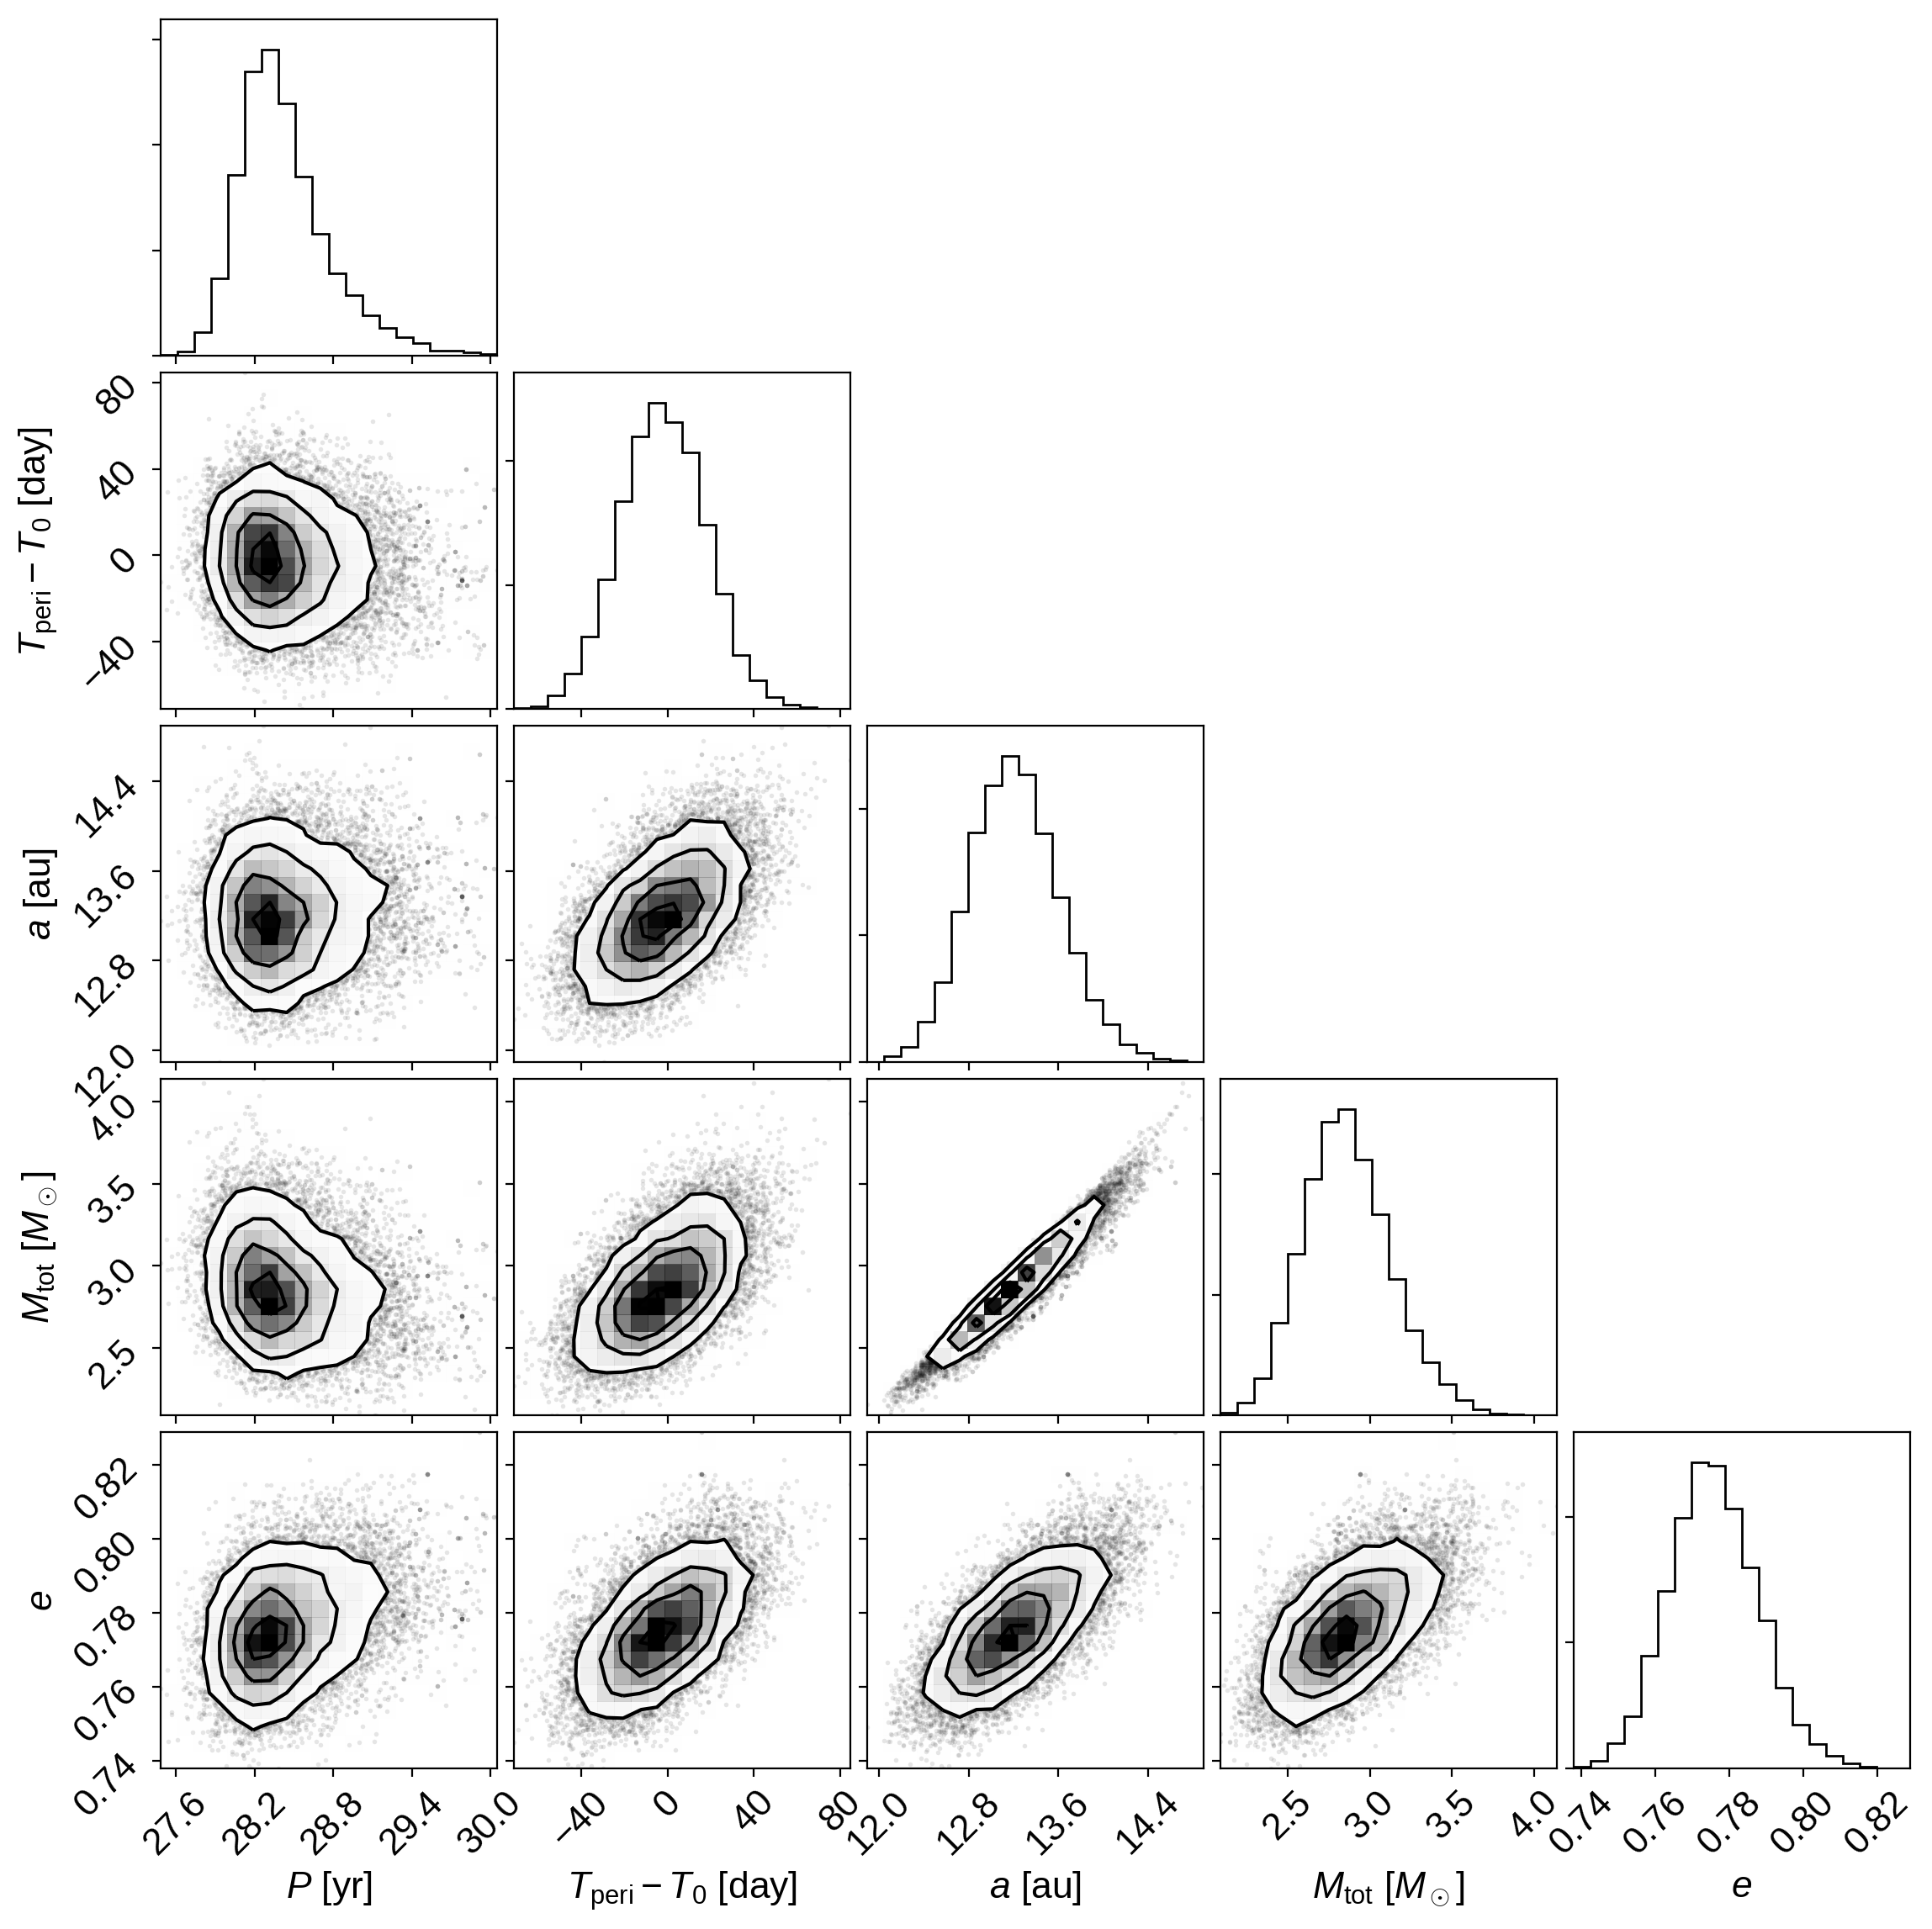

In [17]:
samples = pm.trace_to_dataframe(plx_trace, varnames=["ecc"])
samples["$P$ [yr]"] = plx_trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = plx_trace["tperi"] - T0
samples["$a$ [au]"] = plx_trace["a"]
samples["$M_\mathrm{tot}$ [$M_\odot$]"] = plx_trace["M_tot"]
samples["$e$"] = plx_trace["ecc"]
del samples["ecc"]
corner.corner(samples);

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [18]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [19]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Eric Agol and
            Rodrigo Luger and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.2.0},
   month = aug,
    year = 2019,
     doi = {10.5281/zenodo.3359880},
     url = {https://doi.org/10.5281/zenodo.3359880}
}
...
